<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_6_Accuracy_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this module, we will import

# Step 1: Import packages

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import ee
import geemap

In [ ]:
ee.Authenticate()

ee.Initialize(project='servir-sco-assets')

# MODIFIABLE VARIABLE ALERT

In [ ]:
my_gee_folder = "users/mickymags/flood_intercomparison_chad_09_26_take2/"
aoi = ee.FeatureCollection(my_gee_folder + "aoi")
doi = "2024-09-26"

In [ ]:
roi = aoi.geometry()
aoi_centroid = aoi.geometry().centroid()             # Get the center of the AOI
lon = aoi_centroid.coordinates().get(0).getInfo()    # Extract the longitude from the centroid
lat = aoi_centroid.coordinates().get(1).getInfo()    # Extract the latitude from the centroid

# Step 2: Import Flood Maps

In [ ]:
#!pip install geemap

Import each of the flood maps we exported at the end of Module 6, and the reference data we collected in Collect Earth Online.  

In [ ]:
#dswx = ee.Image("projects/servir-sco-assets/assets/flood_intercomparison/pk_case_study/dswx/dswx_mosaic")
#vfm = ee.Image("projects/servir-sco-assets/assets/flood_intercomparison/pk_case_study/vfm/vfm_mosaic")
#mcdwd= ee.Image("projects/servir-sco-assets/assets/flood_intercomparison/pk_case_study/mcdwd/mcdwd_mosaic")
#gfm = ee.Image("projects/servir-sco-assets/assets/flood_intercomparison/pk_case_study/gfm/gfm_mosaic")
#hf = ee.Image("users/mickymags/fmi/hf_pk_06162023")
#hydrosar = ee.Image(parent_directory + '/hydrosar/hydrosar_mosaic')

In [ ]:
my_ref_data = ee.FeatureCollection(my_gee_folder + "reference_data_delta_chad_09_26")
dswx_hls = ee.Image(my_gee_folder + "dswxhls_harmonized_30")
dswx_s1 = ee.Image(my_gee_folder + "dswxs1_harmonized_30")
mcdwd = ee.Image(my_gee_folder + "mcdwd_harmonized_30_03_17_2025")
hf = ee.Image(my_gee_folder + "hydrafloods_harmonized_30_del")
hydrosar = ee.Image(my_gee_folder + "hydrosar_harmonized")
gfm = ee.Image(my_gee_folder + "gfm_harmonized")
vfm = ee.Image(my_gee_folder + "vfm_harmonized")

In [ ]:
# Get the projection and scale from one of the products
my_projection = dswx_hls.projection()
my_proj_string = my_projection.getInfo()['crs']
my_scale = my_projection.nominalScale().getInfo()

In [ ]:
water_viz = {
    "min": 0,
    "max": 2,
    "palette": ['D3D3D3', '000080', 'FFFFFF']
}

In [ ]:
gfm_mask = gfm.neq(2)
mcdwd_mask = mcdwd.neq(2)
vfm_mask = vfm.neq(2)
dswxhls_mask = dswx_hls.neq(2)
dswxs1_mask = dswx_s1.neq(2)
hf_mask = hf.neq(2)
hydrosar_mask = hydrosar.neq(2)

In [ ]:
gfm_final = gfm.updateMask(gfm_mask)
vfm_final = vfm.updateMask(vfm_mask)
mcdwd_final = mcdwd.updateMask(mcdwd_mask)
dswxhls_final = dswx_hls.updateMask(dswxhls_mask)
dswxs1_final = dswx_s1.updateMask(dswxs1_mask)
hydrosar_final = hydrosar.updateMask(hydrosar_mask)
hf_final = hf.updateMask(hf_mask)

In [ ]:
Map = geemap.Map(center = (lat, lon), zoom = 7)
Map.addLayer(gfm_final, water_viz, 'GFM')
Map.addLayer(vfm_final, water_viz, 'VFM')
Map.addLayer(dswxhls_final, water_viz, 'DSWx-HLS')
Map.addLayer(dswxs1_final, water_viz, 'DSWx-S1')
Map.addLayer(mcdwd_final, water_viz, 'MCDWD')
Map.addLayer(hf_final, water_viz, 'HYDRAFloods')
Map.addLayer(hydrosar_final, water_viz, 'HydroSAR')
Map.addLayer(my_ref_data, {}, 'Reference Data')
Map.addLayerControl()
Map

Map(center=[11.603838129040273, 18.61979504880998], controls=(WidgetControl(options=['position', 'transparent_…

Now let's bring in our reference data and flood maps.

Filter our reference data to two different feature collections, one that has points that were identified as water, and one that has points that were identified as nonwater.

In [ ]:
my_ref_data.first().getInfo()

{'type': 'Feature',
 'geometry': {'type': 'Point',
  'coordinates': [18.195241452857466, 9.445067191861655]},
 'id': '00000000000000000304',
 'properties': {'analysis_duration': '278.8 secs',
  'collection_time': '2025-03-03 18:16',
  'common_securewatch_date': None,
  'confidence': 1,
  'email': 'amw0039@uah.edu',
  'flagged': False,
  'flagged_reason': None,
  'sample_points': 1,
  'shape': 'square',
  'size_m': 30,
  'total_securewatch_dates': 0,
  'water?:cloud': 100,
  'water?:no': 0,
  'water?:yes': 0,
  '\ufeffplotid': 771}}

In [ ]:
first_feat = my_ref_data.first()
first_prop = first_feat.get('water?:yes')
#first_feat.set('water_binary': 1)

In [ ]:
#water_points = ref_data.filter(ee.Filter.eq("water?:cloud", 1))
#nonwater_points = ref_data.filter(ee.Filter.eq("water_or_not", 0))

In [ ]:
def property_setter(feature_collection):
  fc_size = feature_collection.size().getInfo()

  feats = []
  for q in range(fc_size):
    feat_of_int = ee.Feature(feature_collection.toList(fc_size).get(q))
    property_of_int = feat_of_int.get('water?:yes')
    if q % 100 == 0:
      print(q)
    #print(property_of_int.getInfo())
    if property_of_int.getInfo() == 100:
      feat_of_int = feat_of_int.set('reference_water', 1)
      feats.append(feat_of_int)
    else:
      feat_of_int = feat_of_int.set('reference_water', 0)
      feats.append(feat_of_int)

  new_fc = ee.FeatureCollection(feats)
  return new_fc

In [ ]:
#noncloud_points_v2.first().getInfo()

In [ ]:
#noncloud_points_v2.first().getInfo()

In [ ]:
noncloud_points = my_ref_data.filter(ee.Filter.neq("water?:cloud", 100))
noncloud_points_v2 = property_setter(noncloud_points)

all_water_points = noncloud_points.filter(ee.Filter.eq("water?:yes", 100))
all_nonwater_points = noncloud_points.filter(ee.Filter.eq("water?:no", 100))

all_water_points_v2 = noncloud_points_v2.filter(ee.Filter.eq("reference_water", 1))
all_nonwater_points_v2 = noncloud_points_v2.filter(ee.Filter.eq("reference_water", 0))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


In [ ]:
my_ref_data.size().getInfo()
noncloud_points.size().getInfo()

2229

In [ ]:
noncloud_points_v2.size

<bound method Collection.size of <ee.featurecollection.FeatureCollection object at 0x780578f2ad50>>

In [ ]:
noncloud_points_v2.size().getInfo()
#print(all_water_points.size().getInfo())
#all_water_points_v2.size().getInfo()

2229

In [ ]:
'''
for j in range(ncp_size):
  feat_of_int = ee.Feature(noncloud_points.toList(ncp_size).get(j))
  property_of_int
  break
'''

'\nfor j in range(ncp_size):\n  feat_of_int = ee.Feature(noncloud_points.toList(ncp_size).get(j))\n  property_of_int\n  break\n'

In [ ]:
highconf_points = noncloud_points_v2.filter(ee.Filter.gt("confidence", 76))
#highconf_water_points = highconf_points.filter(ee.Filter.eq("reference_water", 1))
#highconf_nonwater_points = highconf_points.filter(ee.Filter.eq("reference_water", 0))

In [ ]:
mediumconf_points = noncloud_points_v2.filter(ee.Filter.gt("confidence", 51))
#mediumconf_water_points = mediumconf_points.filter(ee.Filter.eq("reference_water", 1))
#mediumconf_nonwater_points = mediumconf_points.filter(ee.Filter.eq("reference_water", 0))

In [ ]:
lowconf_points = noncloud_points_v2.filter(ee.Filter.gt("confidence", 26))
#lowconf_water_points = lowconf_points.filter(ee.Filter.eq("reference_water", 1))
#lowconf_nonwater_points = lowconf_points.filter(ee.Filter.eq("reference_water", 0))

In [ ]:
print(my_ref_data.size().getInfo())
print(noncloud_points.size().getInfo())
print(highconf_points.size().getInfo())
print(mediumconf_points.size().getInfo())
print(lowconf_points.size().getInfo())

2276
2229
1916
2055
2125


In [ ]:
#Water visualization Parameters
water_vp = {'min': 0,
          'max': 2,
          'palette': ['000000', '0000FF', 'FFFFFF']
}

In [ ]:
plv = {
    'bands': ['b3', 'b2', 'b1'],
    'min': 0,
    'max': 2400,
    'gamma': 0.75
}

In [ ]:
'''
################## Get masked area for each optical flood map ##################

# VIIRS Flood Map
vfm_mask = vfm.eq(2)       # VFM is the vfm map we exported at the end of module 6.

# Copernicus Flood Map
gfm_mask = gfm.eq(2)       # GFM is the GFM map we exported at the end of module 6.

# MCDWD Flood Map
mcdwd_mask = mcdwd.eq(2)

# DSWx-HLS Flood Map
dswxhls_mask = dswx_hls.eq(2)

# DSWx-S1 Flood Map
dswxs1_mask = dswx_s1.eq(2)

# HYDRAFloods Map
hydrafloods_mask = hf.eq(2)

# HYDROSAR

mymask = vfm_mask.eq(1).Or(gfm_mask.eq(1)).Or(mcdwd_mask.eq(1)).Or(dswx_mask.eq(1))
#finalmask = mymask.eq(0)
'''

'\n################## Get masked area for each optical flood map ##################\n\n# VIIRS Flood Map\nvfm_mask = vfm.eq(2)       # VFM is the vfm map we exported at the end of module 6.\n\n# Copernicus Flood Map\ngfm_mask = gfm.eq(2)       # GFM is the GFM map we exported at the end of module 6.\n\n# MCDWD Flood Map\nmcdwd_mask = mcdwd.eq(2)\n\n# DSWx-HLS Flood Map\ndswxhls_mask = dswx_hls.eq(2)\n\n# DSWx-S1 Flood Map\ndswxs1_mask = dswx_s1.eq(2)\n\n# HYDRAFloods Map\nhydrafloods_mask = hf.eq(2)\n\n# HYDROSAR\n\nmymask = vfm_mask.eq(1).Or(gfm_mask.eq(1)).Or(mcdwd_mask.eq(1)).Or(dswx_mask.eq(1))\n#finalmask = mymask.eq(0)\n'

In [ ]:
#gfm_masked = gfm.updateMask(mymask)

In [ ]:
'''
Map = geemap.Map(center = (lat, lon), zoom = 7)
Map.addLayer(aoi, {}, 'Area of interest')
#Map.addLayer(plum, pluvp, 'Planet Usable Data Mask')
#Map.addLayer(ref_data, {}, 'Planet Imagery')
Map.addLayer(gfm, water_vp, 'GFM')
Map.addLayer(mcdwd, water_vp, 'MCDWD')
Map.addLayer(hydrosar, water_vp, 'Hydrosar')
Map.addLayer(hydrafloods, water_vp, 'Hydrafloods')
Map.addLayer(vfm, water_vp, 'VFM')
Map.addLayer(dswx, water_vp, 'DSWx')
Map.addLayer(pl, plv, 'Planet Visualization Parameters')
Map.addLayer(water_points, {'color':'FFFFFF'}, 'Water Points')         # Display Water Points as blue
Map.addLayer(nonwater_points, {'color': 'FF0000'}, 'Nonwater Points')  # Display Nonwater Points as red

Map.addLayerControl()
Map
'''

"\nMap = geemap.Map(center = (lat, lon), zoom = 7)\nMap.addLayer(aoi, {}, 'Area of interest')\n#Map.addLayer(plum, pluvp, 'Planet Usable Data Mask')\n#Map.addLayer(ref_data, {}, 'Planet Imagery')\nMap.addLayer(gfm, water_vp, 'GFM')\nMap.addLayer(mcdwd, water_vp, 'MCDWD')\nMap.addLayer(hydrosar, water_vp, 'Hydrosar')\nMap.addLayer(hydrafloods, water_vp, 'Hydrafloods')\nMap.addLayer(vfm, water_vp, 'VFM')\nMap.addLayer(dswx, water_vp, 'DSWx')\nMap.addLayer(pl, plv, 'Planet Visualization Parameters')\nMap.addLayer(water_points, {'color':'FFFFFF'}, 'Water Points')         # Display Water Points as blue\nMap.addLayer(nonwater_points, {'color': 'FF0000'}, 'Nonwater Points')  # Display Nonwater Points as red\n\nMap.addLayerControl()\nMap\n"

In [ ]:
hydrafloods_renamed = hf.rename('hydrafloods_water')
hydrosar_renamed = hydrosar.rename('hydrosar_water')
gfm_renamed = gfm.rename('gfm_water')
dswxhls_renamed = dswx_hls.rename('dswxhls_water')
dswxs1_renamed = dswx_s1.rename('dswxs1_water')
mcdwd_renamed = mcdwd.rename('mcdwd_water')
vfm_renamed = vfm.rename('vfm_water')

In [ ]:
# ALL POINTS
hf_sampled_allpoints = hydrafloods_renamed.sampleRegions(noncloud_points_v2, geometries=True)
hs_sampled_allpoints = hydrosar_renamed.sampleRegions(noncloud_points_v2, geometries=True)
gfm_sampled_allpoints = gfm_renamed.sampleRegions(noncloud_points_v2, geometries=True)
dswxhls_sampled_allpoints = dswxhls_renamed.sampleRegions(noncloud_points_v2, geometries=True)
dswxs1_sampled_allpoints = dswxs1_renamed.sampleRegions(noncloud_points_v2, geometries=True)
mcdwd_sampled_allpoints = mcdwd_renamed.sampleRegions(noncloud_points_v2, geometries=True)
vfm_sampled_allpoints = vfm_renamed.sampleRegions(noncloud_points_v2, geometries=True)

# HIGH CONFIDENCE POINTS
hf_sampled_highconf = hydrafloods_renamed.sampleRegions(highconf_points, geometries=True)
hs_sampled_highconf = hydrosar_renamed.sampleRegions(highconf_points, geometries=True)
gfm_sampled_highconf = gfm_renamed.sampleRegions(highconf_points, geometries=True)
dswxhls_sampled_highconf = dswxhls_renamed.sampleRegions(highconf_points, geometries=True)
dswxs1_sampled_highconf = dswxs1_renamed.sampleRegions(highconf_points, geometries=True)
mcdwd_sampled_highconf = mcdwd_renamed.sampleRegions(highconf_points, geometries=True)
vfm_sampled_highconf = vfm_renamed.sampleRegions(highconf_points, geometries=True)

# MEDIUM CONFIDENCE POINTS

# LOW CONFIDENCE POINTS

In [ ]:
test_matrix = hf_sampled_allpoints.errorMatrix('reference_water', "hydrafloods_water", [1, 0]).getInfo()
test_matrix

[[409, 117], [24, 1675]]

In [ ]:
#hydrafloods_allpoints = hydrafloods_renamed.sampleRegions(noncloud_points, geometries=True)
#matrix = hydrafloods_allpoints.errorMatrix('reference_water', "hydrafloods_water", [1, 0]).getInfo()
#matrix

Add the slope information to the feature collections above.

In [ ]:
#hs_s.first().getInfo()

We want to write a function that takes a featurecollection as input, and calculates the confusion matrix, prints the overall accuracy and consumer accuracy for each class. The function will take as an optional parameter a property to filter for. This will allow us to examine statistics for different land cover and/or slope classes more easily.

In [ ]:
def precision(tp, fp, tn, fn):
  prec = tp / (tp + fp)
  return prec


In [ ]:
def recall(tp, fp, tn, fn):
  reca = fp (tp + fn)
  return reca

In [ ]:
def f1_score(tp, fp, tn, fn):
  numerator = 2 * tp
  denominator = (2 * tp) + fp + fn
  f1 = numerator / denominator
  return f1

In [ ]:
def normalized_mcc(tp, fp, tn, fn):
  numerator = (tp * tn) - (fp * fn)
  denominator = np.sqrt((tp+fp) * (tp + fn) * (tn + fp) * (tn+fn))
  term = (numerator / denominator) + 1
  mcc = term / 2
  return mcc

# Testing out SK Learn

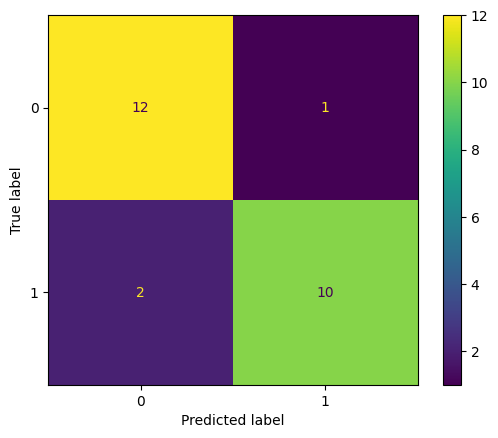

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

In [ ]:
clf.classes_

array([0, 1])

In [ ]:
y_test

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0])

In [ ]:
predictions

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0])

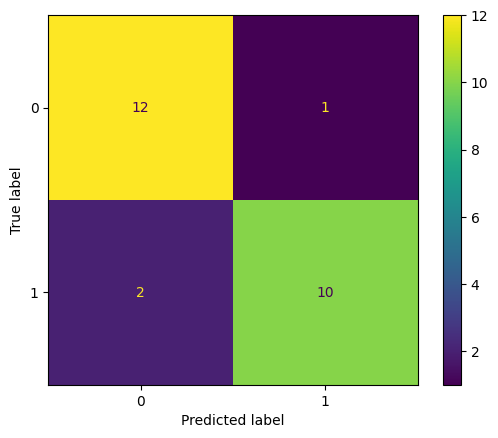

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
X, y = make_classification(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
        X, y, random_state=0)
clf = SVC(random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
ConfusionMatrixDisplay.from_predictions(
   y_test, y_pred)
plt.show()

In [ ]:
y_pred

array([1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 0])

In [ ]:
y_test

array([1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0])

In [ ]:
import sklearn.metrics

In [ ]:
def confusion_matrix_reporter(fc, map_label, description, filter_prop = None, filter_value = None):

  references_list = []
  classifications_list = []

  classes = np.array([1, 0])
  my_display_labels = np.array(['water', 'nonwater'])
  classes_v2 = ['water', 'nonwater']

  if filter_prop != None:
    fc_new = fc.filter(ee.Filter.eq(filter_prop, filter_value))
    print('path1')
  else:
    fc_new = fc
    print('path2')
  fc_size = fc_new.size().getInfo()                           #fc.size().getInfo()
  my_feat_listed = fc_new.toList(fc_size).getInfo()                                           #fc.toList(fc.size().getInfo()).getInfo()
  for r in range(fc_size):                                       # fc.size().getInfo()
    my_feat = my_feat_listed[r]['properties']
    reference = my_feat['reference_water']
    classification = my_feat[map_label]
    test1 = classification == 0 or classification == 1
    test2 = reference == 0 or reference == 1
    if test1 and test2:
      classifications_list.append(classification)
      references_list.append(reference)

  references_array = np.array(references_list)
  classifications_array = np.array(classifications_list)

  accuracy = sklearn.metrics.accuracy_score(references_array, classifications_array)
  acc_string = "{0} accuracy: {1:0.3f}".format(description, accuracy)

  f1 = sklearn.metrics.f1_score(references_array, classifications_array)
  f1_string = "{0} f1 score: {1:0.3f}".format(description, f1)

  prec = sklearn.metrics.precision_score(references_array, classifications_array)
  prec_string = "{0} Precision (aka user's accuracy for water): {1:0.3f}".format(description, prec)

  reca = sklearn.metrics.recall_score(references_array, classifications_array)
  reca_string = "{0} Recall (aka producer's accuracy for water): {1:0.3f}".format(description, reca)

  my_cm = sklearn.metrics.confusion_matrix(references_array, classifications_array, labels = classes)
  tp = my_cm[0][0]
  fn = my_cm[0][1]
  fp = my_cm[1][0]
  tn = my_cm[1][1]

  sample_size = tp + fp + fn + tn

  specificity = tn / (tn + fp)
  spec_string = "{0} Specificity (aka producer's accuracy for nonwater): {1:0.3f}".format(description, specificity)

  npv = tn / (tn + fn)
  npv_string = "{0} Negative Predictive Value (aka nonwater user's accuracy): {1: 0.3f}".format(description, npv)

  mcc = sklearn.metrics.matthews_corrcoef(references_array, classifications_array)
  nmcc = (mcc + 1) / 2
  nmcc_string = "{0} Normalized Matthew's Correlation Coefficien: {1:0.3f}".format(description, nmcc)

  #print(my_cm)
  #print('true pos', tp)
  #print('false pos', fp)
  #print('false negative', fn)
  #print('true negative', tn)

  disp2 = ConfusionMatrixDisplay.from_predictions(references_array,
                              classifications_array,
                              labels = classes,
                              display_labels = my_display_labels,
                              cmap = plt.cm.Blues)
  print(acc_string)
  print(f1_string)
  print(prec_string)
  print(reca_string)
  print(spec_string)
  print(nmcc_string)
  stats_list = [description, sample_size, accuracy, prec, reca, specificity, npv, f1, nmcc]

  return stats_list

In [ ]:
'''
def confusion_matrix_reporter(fc, map_label, description):

  references_list = []
  classifications_list = []

  #print(type(fc))
  #first_fc = fc.first().getInfo()
  #print(first_fc)

  classes = np.array([1, 0])
  my_display_labels = np.array(['water', 'nonwater'])
  classes_v2 = ['water', 'nonwater']
  fc_size = fc.size().getInfo()
  my_feat_listed = fc.toList(fc.size().getInfo()).getInfo()
  for r in range(fc.size().getInfo()):
    my_feat = my_feat_listed[r]['properties']
    reference = my_feat['reference_water']
    classification = my_feat[map_label]
    test1 = classification == 0 or classification == 1
    test2 = reference == 0 or reference == 1
    if test1 and test2:
      classifications_list.append(classification)
      references_list.append(reference)

  references_array = np.array(references_list)
  classifications_array = np.array(classifications_list)

  accuracy = sklearn.metrics.accuracy_score(references_array, classifications_array)
  acc_string = "{0} accuracy: {1:0.3f}".format(description, accuracy)

  f1 = sklearn.metrics.f1_score(references_array, classifications_array)
  f1_string = "{0} f1 score: {1:0.3f}".format(description, f1)

  prec = sklearn.metrics.precision_score(references_array, classifications_array)
  prec_string = "{0} Precision (aka user's accuracy for water): {1:0.3f}".format(description, prec)

  reca = sklearn.metrics.recall_score(references_array, classifications_array)
  reca_string = "{0} Recall (aka producer's accuracy for water): {1:0.3f}".format(description, reca)

  my_cm = sklearn.metrics.confusion_matrix(references_array, classifications_array, labels = classes)
  tp = my_cm[0][0]
  fn = my_cm[0][1]
  fp = my_cm[1][0]
  tn = my_cm[1][1]

  specificity = tn / (tn + fp)
  spec_string = "{0} Specificity (aka producer's accuracy for nonwater): {1:0.3f}".format(description, specificity)

  npv = tn / (tn + fn)
  npv_string = "{0} Negative Predictive Value (aka nonwater user's accuracy): {1: 0.3f}".format(description, npv)

  mcc = sklearn.metrics.matthews_corrcoef(references_array, classifications_array)
  nmcc = (mcc + 1) / 2
  nmcc_string = "{0} Normalized Matthew's Correlation Coefficien: {1:0.3f}".format(description, nmcc)
  #prec_sc = tp / (tp + fp)
  #f1_sc = (2 * tp) / ((2 * tp) + fp + fn)
  print(my_cm)
  print('true pos', tp)
  print('false pos', fp)
  print('false negative', fn)
  print('true negative', tn)

  #disp1 = ConfusionMatrixDisplay(confusion_matrix = my_cm,
  #                               display_labels = classes)
                                 #cmap = cm.Blues())

  disp2 = ConfusionMatrixDisplay.from_predictions(references_array,
                              classifications_array,
                              labels = classes,
                              display_labels = my_display_labels,
                              cmap = plt.cm.Blues)

  #disp2.plot()
  #plt.title(f"{description} Confusion Matrix")
  #plt.plot(disp2)
  #plt.show()
  print(acc_string)
  print(f1_string)
  #print(f1_sc)
  print(prec_string)
  #print(prec_sc)
  print(reca_string)
  print(spec_string)
  print(nmcc_string)
  stats_list = [description, accuracy, prec, reca, specificity, npv, f1, nmcc]

  return stats_list
'''

'\ndef confusion_matrix_reporter(fc, map_label, description):\n\n  references_list = []\n  classifications_list = []\n\n  #print(type(fc))\n  #first_fc = fc.first().getInfo()\n  #print(first_fc)\n\n  classes = np.array([1, 0])\n  my_display_labels = np.array([\'water\', \'nonwater\'])\n  classes_v2 = [\'water\', \'nonwater\']\n  fc_size = fc.size().getInfo()\n  my_feat_listed = fc.toList(fc.size().getInfo()).getInfo()\n  for r in range(fc.size().getInfo()):\n    my_feat = my_feat_listed[r][\'properties\']\n    reference = my_feat[\'reference_water\']\n    classification = my_feat[map_label]\n    test1 = classification == 0 or classification == 1\n    test2 = reference == 0 or reference == 1\n    if test1 and test2:\n      classifications_list.append(classification)\n      references_list.append(reference)\n\n  references_array = np.array(references_list)\n  classifications_array = np.array(classifications_list)\n\n  accuracy = sklearn.metrics.accuracy_score(references_array, classifica

path2
HYDRAFloods All Points accuracy: 0.937
HYDRAFloods All Points f1 score: 0.853
HYDRAFloods All Points Precision (aka user's accuracy for water): 0.945
HYDRAFloods All Points Recall (aka producer's accuracy for water): 0.778
HYDRAFloods All Points Specificity (aka producer's accuracy for nonwater): 0.986
HYDRAFloods All Points Normalized Matthew's Correlation Coefficien: 0.910


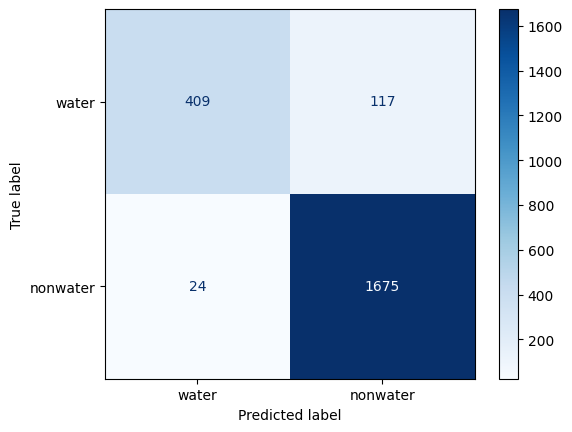

In [ ]:
hydrafloods_allconf = confusion_matrix_reporter(hf_sampled_allpoints, 'hydrafloods_water', 'HYDRAFloods All Points')

In [ ]:
#for j in range(hf_sampled_allpoints.size().getInfo()):
#  my_feat = hf_sampled_allpoints.toList(hf_sampled_allpoints.size().getInfo()).get(j)
  #classification = hf_sampled_a


In [ ]:
#hf_sampled_allpoints.getInfo()

# End testing out SK Learn

In [ ]:
'''
def accuracy_reporter(fc_input, ref_label, map_label, description, filter_bool=False, filter_prop = None, filter_value = None):

  #fc_input will be the feature collection of points. Each point should contain a reference property and a map property.
  # Both properties should have a 1 where water was noted as present and a 0 where water was absent.
  # ref_label will be the property name in fc_input that contains the reference label of water/nonwater that we collected in Collect Earth Online.
  # map_label will be the property name in fc_input that contains the reference label of water/nonwater according to one of our flood map products.

  if filter_bool == True:   # Add filter_prop code later.
    fc_input_new = fc_input.filter(ee.Filter.eq(filter_prop, filter_value))
    matrix = fc_input_new.errorMatrix(ref_label, map_label, [1, 0])
    #tru_pos = matrix.getInfo()[0][0]
    #fal_pos = matrix.getInfo()[0][1]
    #fal_neg = matrix.getInfo()[1][0]
    #tru_neg = matrix.getInfo()[1][1]
    #oat = ((tru_pos + tru_neg) / (tru_pos + fal_pos + fal_neg + tru_neg)) * 100
    #overall_acc = matrix.accuracy().getInfo() * 100
    #producers_acc =  matrix.producersAccuracy().getInfo()
    #pa_water = producers_acc[0][0]* 100
    #pa_nonwater = producers_acc[1][0] * 100
    #users_acc = matrix.consumersAccuracy().getInfo()
    #ua_water = users_acc[0][0] * 100
    #ua_nonwater = users_acc[0][1] * 100
  else:
    matrix = fc_input.errorMatrix(ref_label, map_label, [1, 0])        # Run the errorMatrix method using the reference label and map label of the feature collection
    #overall_acc = matrix.accuracy().getInfo() * 100                    # Get the overall accuracy for this matrix in terms of percent (multiply by 100 to convert from fraction to percent)
    #tru_pos = matrix.getInfo()[0][0]
    #fal_pos = matrix.getInfo()[0][1]
    #fal_neg = matrix.getInfo()[1][0]
    #tru_neg = matrix.getInfo()[1][1]
    #oat = ((tru_pos + tru_neg) / (tru_pos + fal_pos + fal_neg + tru_neg)) * 100
    #producers_acc =  matrix.producersAccuracy().getInfo()              # Get the producer's accuracy for this matrix. This will be a list of producer's accuracy for each class (water & nonwater)
    #pa_water = producers_acc[0][0]* 100                                # Get the producer's accuracy for the water class.
    #pa_nonwater = producers_acc[1][0] * 100                            # Get the producer's accuracy for the nonwater class.
    #users_acc = matrix.consumersAccuracy().getInfo()
    #ua_water = users_acc[0][0] * 100
    #ua_nonwater = users_acc[0][1] * 100

  overall_acc = matrix.accuracy().getInfo() * 100                    # Get the overall accuracy for this matrix in terms of percent (multiply by 100 to convert from fraction to percent)
  tru_pos = matrix.getInfo()[0][0]
  fal_pos = matrix.getInfo()[0][1]
  fal_neg = matrix.getInfo()[1][0]
  tru_neg = matrix.getInfo()[1][1]
  pawater_test = (tru_pos / (tru_pos + fal_neg)) * 100
  panonwater_test = (tru_neg / (fal_pos + tru_neg)) * 100
  #oat = ((tru_pos + tru_neg) / (tru_pos + fal_pos + fal_neg + tru_neg)) * 100
  producers_acc =  matrix.producersAccuracy().getInfo()              # Get the producer's accuracy for this matrix. This will be a list of producer's accuracy for each class (water & nonwater)
  pa_water = producers_acc[0][0]* 100                                # Get the producer's accuracy for the water class.
  pa_nonwater = producers_acc[1][0] * 100                            # Get the producer's accuracy for the nonwater class.
  users_acc = matrix.consumersAccuracy().getInfo()
  ua_water = users_acc[0][0] * 100
  ua_nonwater = users_acc[0][1] * 100


  # Print the statistics
  #print(oat)
  #print("True Positives:", matrix.getInfo()[0][0])
  #print("False Positives", matrix.getInfo()[0][1])
  #print("False Negatives", matrix.getInfo()[1][0])
  #print("True Negatives:", matrix.getInfo()[1][1])
  print("{} Error Matrix: {}".format(description, matrix.getInfo()))                          # Print the error matrix.
  print("{0} Overall Accuracy: {1:0.2f} %".format(description, overall_acc))
  #print("{0} Overall Accuracy sanity check: {1:0.2f} %".format(description, oat))
  print("{0} sanity check producer's accuracy for water: {1:0.2f} %".format(description, pawater_test))
  #print("{0} sanity check producer's accuracy for nonwater: {1:0.2f} %".format(description, panonwater_test))
  print("{0} Producer's Accuracy for the Water Class: {1:0.2f} %".format(description, pa_water))
  print(producers_acc)
  #print("{0} Producer's Accuracy for the Nonwater Class: {1:0.2f} %".format(description, pa_nonwater))
  #print("{0} User's Accuracy for the Water Class: {1:0.2f} %".format(description, ua_water))
  #print("{0} User's Accuracy for the Nonwater Class: {1:0.2f} %".format(description, ua_nonwater))
'''

'\ndef accuracy_reporter(fc_input, ref_label, map_label, description, filter_bool=False, filter_prop = None, filter_value = None):\n\n  #fc_input will be the feature collection of points. Each point should contain a reference property and a map property.\n  # Both properties should have a 1 where water was noted as present and a 0 where water was absent.\n  # ref_label will be the property name in fc_input that contains the reference label of water/nonwater that we collected in Collect Earth Online.\n  # map_label will be the property name in fc_input that contains the reference label of water/nonwater according to one of our flood map products.\n\n  if filter_bool == True:   # Add filter_prop code later.\n    fc_input_new = fc_input.filter(ee.Filter.eq(filter_prop, filter_value))\n    matrix = fc_input_new.errorMatrix(ref_label, map_label, [1, 0])\n    #tru_pos = matrix.getInfo()[0][0]\n    #fal_pos = matrix.getInfo()[0][1]\n    #fal_neg = matrix.getInfo()[1][0]\n    #tru_neg = matrix

# ALL POINTS ACCURACY REPORTING

path2
HYDRAFloods All Points accuracy: 0.937
HYDRAFloods All Points f1 score: 0.853
HYDRAFloods All Points Precision (aka user's accuracy for water): 0.945
HYDRAFloods All Points Recall (aka producer's accuracy for water): 0.778
HYDRAFloods All Points Specificity (aka producer's accuracy for nonwater): 0.986
HYDRAFloods All Points Normalized Matthew's Correlation Coefficien: 0.910


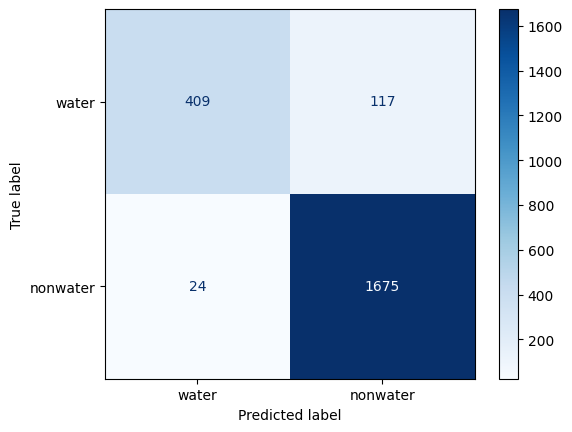

In [ ]:
#accuracy_reporter(hf_sampled_allpoints, 'reference_water', 'hydrafloods_water', 'HYDRAFloods All Points')
hydrafloods_allconf = confusion_matrix_reporter(hf_sampled_allpoints, 'hydrafloods_water', 'HYDRAFloods All Points')

path2
HYDROSAR All Points accuracy: 0.907
HYDROSAR All Points f1 score: 0.763
HYDROSAR All Points Precision (aka user's accuracy for water): 0.960
HYDROSAR All Points Recall (aka producer's accuracy for water): 0.633
HYDROSAR All Points Specificity (aka producer's accuracy for nonwater): 0.992
HYDROSAR All Points Normalized Matthew's Correlation Coefficien: 0.866


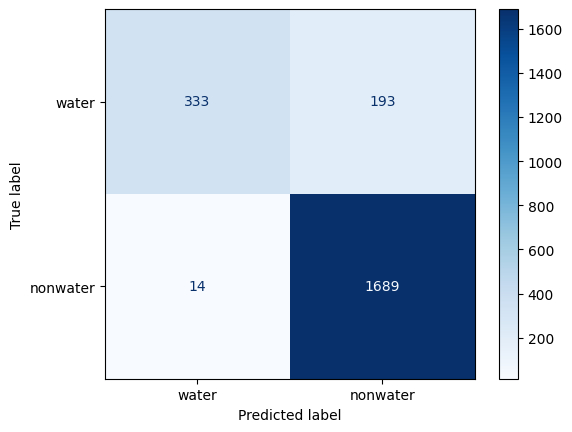

In [ ]:
#accuracy_reporter(hs_sampled_allpoints, 'reference_water', 'hydrosar_water', 'HYDROSAR ALL POINTS')
hydrosar_allconf = confusion_matrix_reporter(hs_sampled_allpoints, 'hydrosar_water', 'HYDROSAR All Points')

path2
GFM All Points accuracy: 0.939
GFM All Points f1 score: 0.862
GFM All Points Precision (aka user's accuracy for water): 0.935
GFM All Points Recall (aka producer's accuracy for water): 0.798
GFM All Points Specificity (aka producer's accuracy for nonwater): 0.983
GFM All Points Normalized Matthew's Correlation Coefficien: 0.914


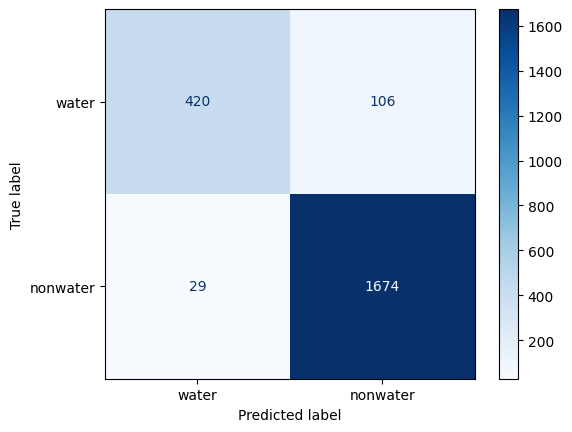

In [ ]:
#accuracy_reporter(gfm_sampled_allpoints, 'reference_water', 'gfm_water', 'GFM ALL POINTS')
gfm_allconf = confusion_matrix_reporter(gfm_sampled_allpoints, 'gfm_water', 'GFM All Points')

path2
DSWX-HLs All Points accuracy: 0.829
DSWX-HLs All Points f1 score: 0.489
DSWX-HLs All Points Precision (aka user's accuracy for water): 0.831
DSWX-HLs All Points Recall (aka producer's accuracy for water): 0.346
DSWX-HLs All Points Specificity (aka producer's accuracy for nonwater): 0.978
DSWX-HLs All Points Normalized Matthew's Correlation Coefficien: 0.731


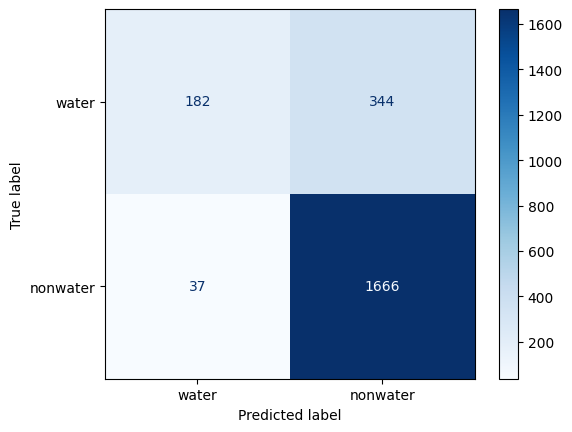

In [ ]:
#accuracy_reporter(dswxhls_sampled_allpoints, 'reference_water', 'dswxhls_water', 'DSWXHLS ALL POINTS')
dswxhls_allconf = confusion_matrix_reporter(dswxhls_sampled_allpoints, 'dswxhls_water', 'DSWX-HLs All Points')

path2
DSWx-S1 All Points accuracy: 0.776
DSWx-S1 All Points f1 score: 0.123
DSWx-S1 All Points Precision (aka user's accuracy for water): 0.795
DSWx-S1 All Points Recall (aka producer's accuracy for water): 0.067
DSWx-S1 All Points Specificity (aka producer's accuracy for nonwater): 0.995
DSWx-S1 All Points Normalized Matthew's Correlation Coefficien: 0.593


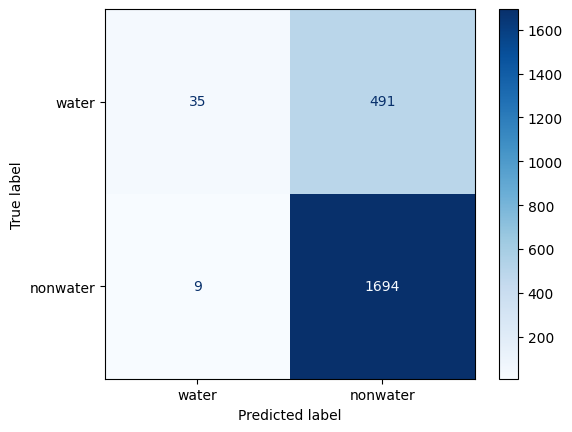

In [ ]:
#accuracy_reporter(dswxs1_sampled_allpoints, 'reference_water', 'dswxs1_water', 'DSWx-S1 ALL POINTS')
dswxs1_allconf = confusion_matrix_reporter(dswxs1_sampled_allpoints, 'dswxs1_water', 'DSWx-S1 All Points')

path2
MCDWD All Points accuracy: 0.828
MCDWD All Points f1 score: 0.446
MCDWD All Points Precision (aka user's accuracy for water): 0.933
MCDWD All Points Recall (aka producer's accuracy for water): 0.293
MCDWD All Points Specificity (aka producer's accuracy for nonwater): 0.994
MCDWD All Points Normalized Matthew's Correlation Coefficien: 0.732


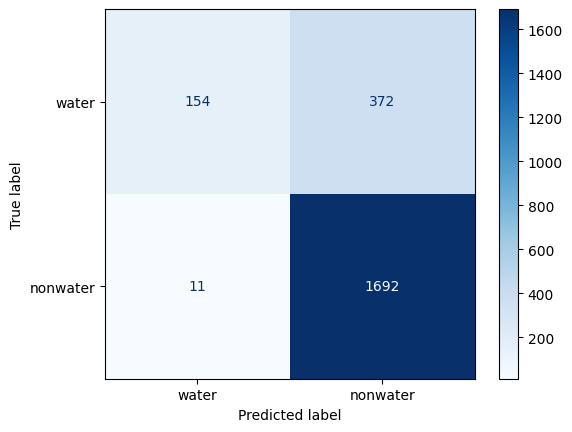

In [ ]:
#accuracy_reporter(mcdwd_sampled_allpoints, 'reference_water', 'mcdwd_water', 'MCDWD ALL POINTS')
mcdwd_allconf = confusion_matrix_reporter(mcdwd_sampled_allpoints, 'mcdwd_water', 'MCDWD All Points')

path2
VFM All Points accuracy: 0.876
VFM All Points f1 score: 0.707
VFM All Points Precision (aka user's accuracy for water): 0.797
VFM All Points Recall (aka producer's accuracy for water): 0.635
VFM All Points Specificity (aka producer's accuracy for nonwater): 0.950
VFM All Points Normalized Matthew's Correlation Coefficien: 0.818


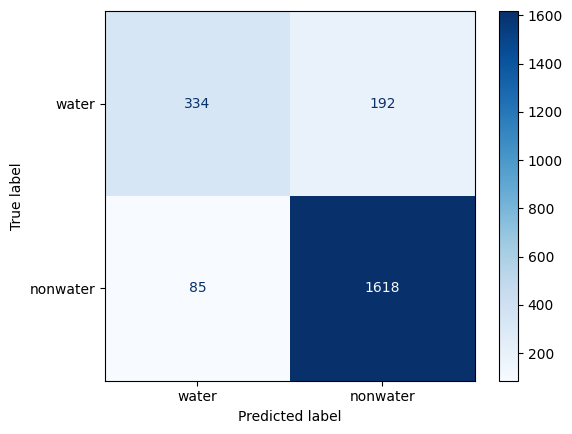

In [ ]:
#accuracy_reporter(vfm_sampled_allpoints, 'reference_water', 'vfm_water', 'VFM ALL POINTS')
vfm_allconf = confusion_matrix_reporter(vfm_sampled_allpoints, 'vfm_water', 'VFM All Points')

# HIGH CONFIDENCE POINTS ACCURACY REPORTING

path2
HYDRAFloods High Confidence accuracy: 0.973
HYDRAFloods High Confidence f1 score: 0.924
HYDRAFloods High Confidence Precision (aka user's accuracy for water): 0.975
HYDRAFloods High Confidence Recall (aka producer's accuracy for water): 0.879
HYDRAFloods High Confidence Specificity (aka producer's accuracy for nonwater): 0.995
HYDRAFloods High Confidence Normalized Matthew's Correlation Coefficien: 0.955


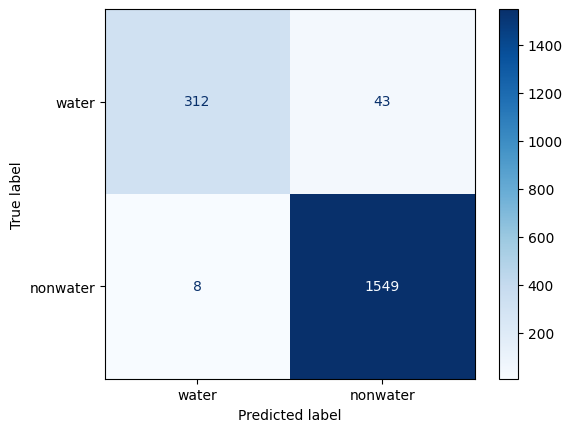

In [ ]:
#accuracy_reporter(hf_sampled_highconf, 'reference_water', 'hydrafloods_water', 'HYDRAFloods High Confidence')
hydrafloods_highconf = confusion_matrix_reporter(hf_sampled_highconf, 'hydrafloods_water', 'HYDRAFloods High Confidence')

path2
HYDROSAR High Confidence accuracy: 0.949
HYDROSAR High Confidence f1 score: 0.844
HYDROSAR High Confidence Precision (aka user's accuracy for water): 0.981
HYDROSAR High Confidence Recall (aka producer's accuracy for water): 0.741
HYDROSAR High Confidence Specificity (aka producer's accuracy for nonwater): 0.997
HYDROSAR High Confidence Normalized Matthew's Correlation Coefficien: 0.913


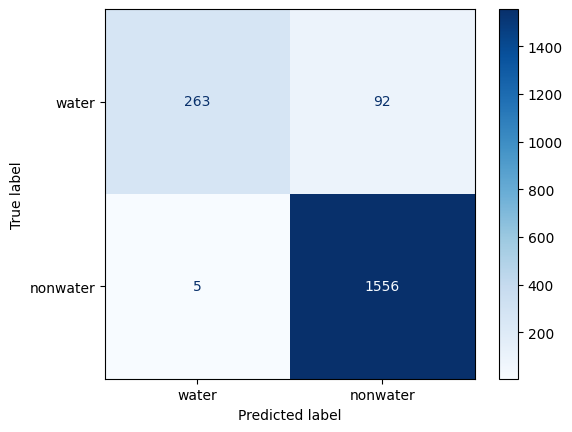

In [ ]:
#accuracy_reporter(hs_sampled_highconf, 'reference_water', 'hydrosar_water', 'HYDROSAR High Confidence')
hydrosar_highconf = confusion_matrix_reporter(hs_sampled_highconf, 'hydrosar_water', 'HYDROSAR High Confidence')

path2
GFM High Confidence accuracy: 0.977
GFM High Confidence f1 score: 0.934
GFM High Confidence Precision (aka user's accuracy for water): 0.981
GFM High Confidence Recall (aka producer's accuracy for water): 0.890
GFM High Confidence Specificity (aka producer's accuracy for nonwater): 0.996
GFM High Confidence Normalized Matthew's Correlation Coefficien: 0.960


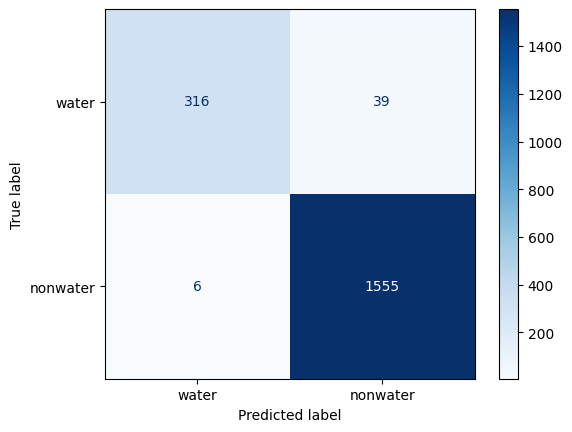

In [ ]:
#accuracy_reporter(gfm_sampled_highconf, 'reference_water', 'gfm_water', 'GFM High Confidence')
gfm_highconf = confusion_matrix_reporter(gfm_sampled_highconf, 'gfm_water', 'GFM High Confidence')

path2
DSWx-HLS High Confidence accuracy: 0.882
DSWx-HLS High Confidence f1 score: 0.559
DSWx-HLS High Confidence Precision (aka user's accuracy for water): 0.911
DSWx-HLS High Confidence Recall (aka producer's accuracy for water): 0.403
DSWx-HLS High Confidence Specificity (aka producer's accuracy for nonwater): 0.991
DSWx-HLS High Confidence Normalized Matthew's Correlation Coefficien: 0.779


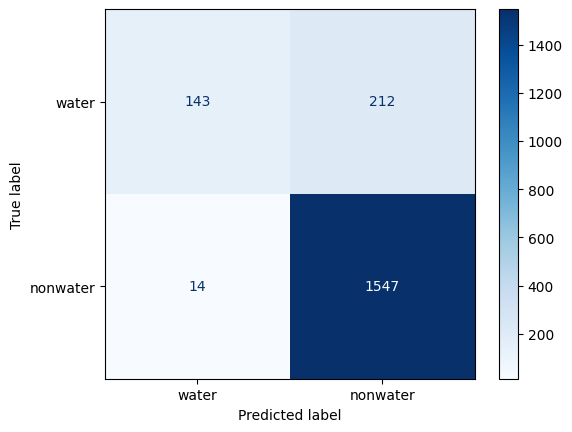

In [ ]:
#accuracy_reporter(dswxhls_sampled_highconf, 'reference_water', 'dswxhls_water', 'DSWx-HLS High Confidence')
dswxhls_highconf = confusion_matrix_reporter(dswxhls_sampled_highconf, 'dswxhls_water', 'DSWx-HLS High Confidence')

path2
DSWx-S1 High Confidence accuracy: 0.828
DSWx-S1 High Confidence f1 score: 0.149
DSWx-S1 High Confidence Precision (aka user's accuracy for water): 0.879
DSWx-S1 High Confidence Recall (aka producer's accuracy for water): 0.082
DSWx-S1 High Confidence Specificity (aka producer's accuracy for nonwater): 0.997
DSWx-S1 High Confidence Normalized Matthew's Correlation Coefficien: 0.618


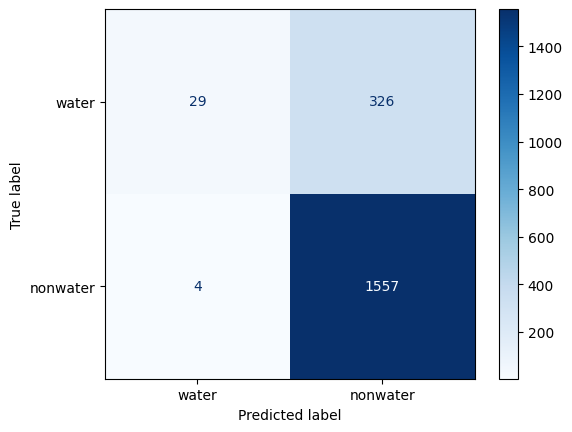

In [ ]:
#accuracy_reporter(dswxs1_sampled_highconf, 'reference_water', 'dswxs1_water', 'DSWx-S1 High Confidence')
dswxs1_highconf = confusion_matrix_reporter(dswxs1_sampled_highconf, 'dswxs1_water', 'DSWx-S1 High Confidence')

path2
MCDWD High Confidence accuracy: 0.874
MCDWD High Confidence f1 score: 0.485
MCDWD High Confidence Precision (aka user's accuracy for water): 0.991
MCDWD High Confidence Recall (aka producer's accuracy for water): 0.321
MCDWD High Confidence Specificity (aka producer's accuracy for nonwater): 0.999
MCDWD High Confidence Normalized Matthew's Correlation Coefficien: 0.762


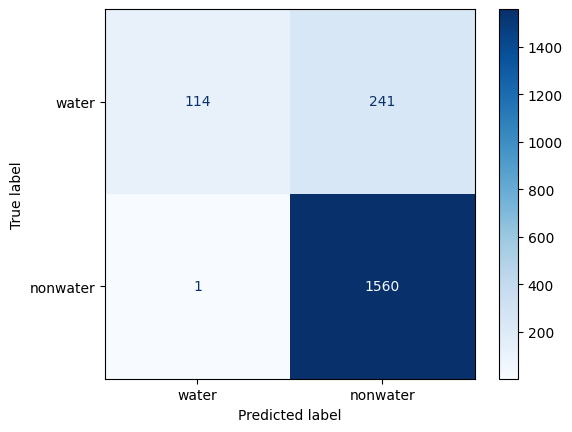

In [ ]:
#accuracy_reporter(mcdwd_sampled_highconf, 'reference_water', 'mcdwd_water', 'MCDWD HIGH CONFIDENCE')
mcdwd_highconf = confusion_matrix_reporter(mcdwd_sampled_highconf, 'mcdwd_water', 'MCDWD High Confidence')

path2
VFM High Confidence accuracy: 0.920
VFM High Confidence f1 score: 0.762
VFM High Confidence Precision (aka user's accuracy for water): 0.843
VFM High Confidence Recall (aka producer's accuracy for water): 0.696
VFM High Confidence Specificity (aka producer's accuracy for nonwater): 0.971
VFM High Confidence Normalized Matthew's Correlation Coefficien: 0.860


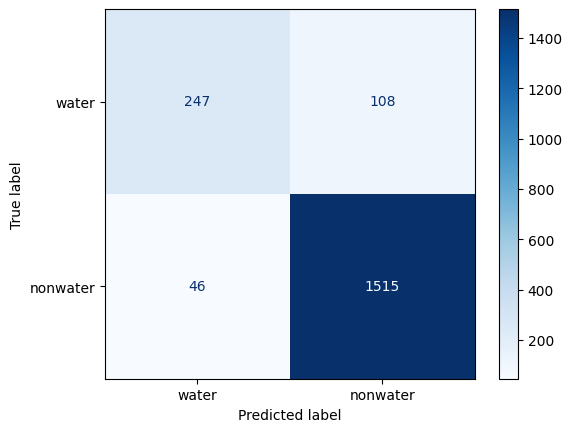

In [ ]:
#accuracy_reporter(vfm_sampled_highconf, 'reference_water', 'vfm_water', 'VFM HIGH CONFIDENCE')
vfm_highconf = confusion_matrix_reporter(vfm_sampled_highconf, 'vfm_water', 'VFM High Confidence')

In [ ]:
'''
def accuracy_reporter(fc_input, ref_label, map_label, description, filter_bool=False, filter_prop = None, filter_value = None):

  #fc_input will be the feature collection of points. Each point should contain a reference property and a map property.
  # Both properties should have a 1 where water was noted as present and a 0 where water was absent.
  # ref_label will be the property name in fc_input that contains the reference label of water/nonwater that we collected in Collect Earth Online.
  # map_label will be the property name in fc_input that contains the reference label of water/nonwater according to one of our flood map products.

  if filter_prop == True:   # Add filter_prop code later.
    fc_input = fc_input.filter(ee.Filter.eq(filter_prop, filter_value))
  matrix = fc_input.errorMatrix(ref_label, map_label, [1, 0])        # Run the errorMatrix method using the reference label and map label of the feature collection
  overall_acc = matrix.accuracy().getInfo() * 100                    # Get the overall accuracy for this matrix in terms of percent (multiply by 100 to convert from fraction to percent)
  producers_acc =  matrix.producersAccuracy().getInfo()              # Get the producer's accuracy for this matrix. This will be a list of producer's accuracy for each class (water & nonwater)
  pa_water = producers_acc[0][0]* 100                                # Get the producer's accuracy for the water class.
  pa_nonwater = producers_acc[1][0] * 100                            # Get the producer's accuracy for the nonwater class.
  users_acc = matrix.consumersAccuracy().getInfo()
  ua_water = users_acc[0][0] * 100
  ua_nonwater = users_acc[0][1] * 100

  # Print the statistics
  print("{} Error Matrix: {}".format(description, matrix.getInfo()))                          # Print the error matrix.
  print("{0} Overall Accuracy: {1:0.2f} %".format(description, overall_acc))
  print("{0} Producer's Accuracy for the Water Class: {1:0.2f} %".format(description, pa_water))
  print("{0} Producer's Accuracy for the Nonwater Class: {1:0.2f} %".format(description, pa_nonwater))
  print("{0} User's Accuracy for the Water Class: {1:0.2f} %".format(description, ua_water))
  print("{0} User's Accuracy for the Nonwater Class: {1:0.2f} %".format(description, ua_nonwater))
'''

'\ndef accuracy_reporter(fc_input, ref_label, map_label, description, filter_bool=False, filter_prop = None, filter_value = None):\n\n  #fc_input will be the feature collection of points. Each point should contain a reference property and a map property.\n  # Both properties should have a 1 where water was noted as present and a 0 where water was absent.\n  # ref_label will be the property name in fc_input that contains the reference label of water/nonwater that we collected in Collect Earth Online.\n  # map_label will be the property name in fc_input that contains the reference label of water/nonwater according to one of our flood map products.\n\n  if filter_prop == True:   # Add filter_prop code later.\n    fc_input = fc_input.filter(ee.Filter.eq(filter_prop, filter_value))\n  matrix = fc_input.errorMatrix(ref_label, map_label, [1, 0])        # Run the errorMatrix method using the reference label and map label of the feature collection\n  overall_acc = matrix.accuracy().getInfo() * 

In [ ]:
#accuracy_reporter(hf_s, 'water_or_not', 'hydrafloods_water', 'Hydrafloods General')

In [ ]:
#accuracy_reporter(hf_sws, 'water_or_not', 'hydrafloods_water', 'HYDRAFloods Very Low Slope', filter_bool=True,
#                  filter_prop='slope_class', filter_value=2)

# Step 4: Statistical Analysis

- Error Matrix for each product versus truth
- Statistics for subpopulations

For each flood map, we have a feature collection of points where we have a reference classification and the map classification. To obtain a confusion matrix of these points, we can use the `errorMatrix` method in Google Earth Engine. As menti

In [ ]:
'''
hf_error_matrix = hf_s.errorMatrix('water_or_not', 'hydrafloods_water', [1,0])
hs_error_matrix = hs_s.errorMatrix('water_or_not', 'hydrosar_water', [1, 0])
gfm_error_matrix = gfm_s.errorMatrix('water_or_not', 'gfm_water', [1, 0])
dswx_error_matrix = dswx_s.errorMatrix('water_or_not', 'dswxhls_water', [1, 0])
mcdwd_error_matrix = mcdwd_s.errorMatrix('water_or_not', 'mcdwd_water', [1, 0])
vfm_error_matrix = vfm_s.errorMatrix('water_or_not', 'vfm_water', [1, 0])
'''

"\nhf_error_matrix = hf_s.errorMatrix('water_or_not', 'hydrafloods_water', [1,0])\nhs_error_matrix = hs_s.errorMatrix('water_or_not', 'hydrosar_water', [1, 0])\ngfm_error_matrix = gfm_s.errorMatrix('water_or_not', 'gfm_water', [1, 0])\ndswx_error_matrix = dswx_s.errorMatrix('water_or_not', 'dswxhls_water', [1, 0])\nmcdwd_error_matrix = mcdwd_s.errorMatrix('water_or_not', 'mcdwd_water', [1, 0])\nvfm_error_matrix = vfm_s.errorMatrix('water_or_not', 'vfm_water', [1, 0])\n"

In [ ]:
'''
print(hf_error_matrix.getInfo())
print(hs_error_matrix.getInfo())
print(gfm_error_matrix.getInfo())
print(dswx_error_matrix.getInfo())
print(mcdwd_error_matrix.getInfo())
print(vfm_error_matrix.getInfo())
'''

'\nprint(hf_error_matrix.getInfo())\nprint(hs_error_matrix.getInfo())\nprint(gfm_error_matrix.getInfo())\nprint(dswx_error_matrix.getInfo())\nprint(mcdwd_error_matrix.getInfo())\nprint(vfm_error_matrix.getInfo())\n'

In [ ]:
'''
# Sanity Check by making sure the sum of the matrices adds up to the same number

hf_num = hf_error_matrix.getInfo()[0][0] + hf_error_matrix.getInfo()[0][1] + hf_error_matrix.getInfo()[1][0] + hf_error_matrix.getInfo()[1][1]
hs_num = hs_error_matrix.getInfo()[0][0] + hs_error_matrix.getInfo()[0][1] + hs_error_matrix.getInfo()[1][0] + hs_error_matrix.getInfo()[1][1]
gfm_num = gfm_error_matrix.getInfo()[0][0] + gfm_error_matrix.getInfo()[0][1] + gfm_error_matrix.getInfo()[1][0] + gfm_error_matrix.getInfo()[1][1]
dswx_num = dswx_error_matrix.getInfo()[0][0] + dswx_error_matrix.getInfo()[0][1] + dswx_error_matrix.getInfo()[1][0] + dswx_error_matrix.getInfo()[1][1]
mcdwd_num = mcdwd_error_matrix.getInfo()[0][0] + mcdwd_error_matrix.getInfo()[0][1] + mcdwd_error_matrix.getInfo()[1][0] + mcdwd_error_matrix.getInfo()[1][1]
vfm_num = vfm_error_matrix.getInfo()[0][0] + vfm_error_matrix.getInfo()[0][1] + vfm_error_matrix.getInfo()[1][0] + vfm_error_matrix.getInfo()[1][1]

print(hf_num)
print(hs_num)
print(gfm_num)
print(dswx_num)
print(mcdwd_num)
print(vfm_num)
'''

'\n# Sanity Check by making sure the sum of the matrices adds up to the same number\n\nhf_num = hf_error_matrix.getInfo()[0][0] + hf_error_matrix.getInfo()[0][1] + hf_error_matrix.getInfo()[1][0] + hf_error_matrix.getInfo()[1][1]\nhs_num = hs_error_matrix.getInfo()[0][0] + hs_error_matrix.getInfo()[0][1] + hs_error_matrix.getInfo()[1][0] + hs_error_matrix.getInfo()[1][1]\ngfm_num = gfm_error_matrix.getInfo()[0][0] + gfm_error_matrix.getInfo()[0][1] + gfm_error_matrix.getInfo()[1][0] + gfm_error_matrix.getInfo()[1][1]\ndswx_num = dswx_error_matrix.getInfo()[0][0] + dswx_error_matrix.getInfo()[0][1] + dswx_error_matrix.getInfo()[1][0] + dswx_error_matrix.getInfo()[1][1]\nmcdwd_num = mcdwd_error_matrix.getInfo()[0][0] + mcdwd_error_matrix.getInfo()[0][1] + mcdwd_error_matrix.getInfo()[1][0] + mcdwd_error_matrix.getInfo()[1][1]\nvfm_num = vfm_error_matrix.getInfo()[0][0] + vfm_error_matrix.getInfo()[0][1] + vfm_error_matrix.getInfo()[1][0] + vfm_error_matrix.getInfo()[1][1]\n\nprint(hf_num

In [ ]:
'''
hf_acc = hf_error_matrix.accuracy().getInfo() * 100
hs_acc = hs_error_matrix.accuracy().getInfo()
gfm_acc = gfm_error_matrix.accuracy().getInfo() * 100
dswx_acc = dswx_error_matrix.accuracy().getInfo() * 100
mcdwd_acc = mcdwd_error_matrix.accuracy().getInfo() * 100
vfm_acc = vfm_error_matrix.accuracy().getInfo() * 100

print('Hydrafloods Accuracy: {0:.3f} %'.format(hf_acc))
print('HydroSAR Accuracy:', hs_acc)
print('GFM Accuracy:{0:.3f} %'.format(gfm_acc))
print('DSWx Accuracy:{0:.3f} %'.format(dswx_acc))
print('MCDWD Accuracy:{0:.3f} %'.format(mcdwd_acc))
print('VFM Accuracy:{0:.3f} %'.format(vfm_acc))
'''

"\nhf_acc = hf_error_matrix.accuracy().getInfo() * 100\nhs_acc = hs_error_matrix.accuracy().getInfo()\ngfm_acc = gfm_error_matrix.accuracy().getInfo() * 100\ndswx_acc = dswx_error_matrix.accuracy().getInfo() * 100\nmcdwd_acc = mcdwd_error_matrix.accuracy().getInfo() * 100\nvfm_acc = vfm_error_matrix.accuracy().getInfo() * 100\n\nprint('Hydrafloods Accuracy: {0:.3f} %'.format(hf_acc))\nprint('HydroSAR Accuracy:', hs_acc)\nprint('GFM Accuracy:{0:.3f} %'.format(gfm_acc))\nprint('DSWx Accuracy:{0:.3f} %'.format(dswx_acc))\nprint('MCDWD Accuracy:{0:.3f} %'.format(mcdwd_acc))\nprint('VFM Accuracy:{0:.3f} %'.format(vfm_acc))\n"

In [ ]:
'''
hf_pa = hf_error_matrix.producersAccuracy().getInfo()
hs_pa = hs_error_matrix.producersAccuracy().getInfo()
gfm_pa = gfm_error_matrix.producersAccuracy().getInfo()
dswx_pa = dswx_error_matrix.producersAccuracy().getInfo()
mcdwd_pa = mcdwd_error_matrix.producersAccuracy().getInfo()
vfm_pa = vfm_error_matrix.producersAccuracy().getInfo()

print("HydraFloods Producer's Accuracy for Water: {0:.2f}%".format(float(hf_pa[0][0]) * 100))
print("HydraFloods Producer's Accuracy for Nonwater: {0:.2f}%".format(float(hf_pa[1][0]) * 100))

print("\nHydrosar Producer's Accuracy for Water: {0:.2f}%".format(float(hs_pa[0][0]) * 100))
print("Hydrosar Producer's Accuracy for Nonwater: {0:.2f}%".format(float(hs_pa[1][0]) * 100))

print("\nGFM Producer's Accuracy for Water: {0:.2f}%".format(float(gfm_pa[0][0]) * 100))
print("GFM Producer's Accuracy for Nonwater: {0:.2f}%".format(float(gfm_pa[1][0]) * 100))

print("\nDSWX-HLS Producer's Accuracy for Water: {0:.2f}%".format(float(dswx_pa[0][0]) * 100))
print("DSWX-HLS Producer's Accuracy for Nonwater: {0:.2f}%".format(float(dswx_pa[1][0]) * 100))

print("\nMCDWD Producer's Accuracy for Water: {0:.2f}%".format(float(mcdwd_pa[0][0]) * 100))
print("MCDWD Producer's Accuracy for Nonwater: {0:.2f}%".format(float(mcdwd_pa[1][0]) * 100))

print("\nVFM Producer's Accuracy for Water: {0:.2f}%".format(float(vfm_pa[0][0]) * 100))
print("VFM Producer's Accuracy for Nonwater: {0:.2f}%".format(float(vfm_pa[1][0]) * 100))'''

'\nhf_pa = hf_error_matrix.producersAccuracy().getInfo()\nhs_pa = hs_error_matrix.producersAccuracy().getInfo()\ngfm_pa = gfm_error_matrix.producersAccuracy().getInfo()\ndswx_pa = dswx_error_matrix.producersAccuracy().getInfo()\nmcdwd_pa = mcdwd_error_matrix.producersAccuracy().getInfo()\nvfm_pa = vfm_error_matrix.producersAccuracy().getInfo()\n\nprint("HydraFloods Producer\'s Accuracy for Water: {0:.2f}%".format(float(hf_pa[0][0]) * 100))\nprint("HydraFloods Producer\'s Accuracy for Nonwater: {0:.2f}%".format(float(hf_pa[1][0]) * 100))\n\nprint("\nHydrosar Producer\'s Accuracy for Water: {0:.2f}%".format(float(hs_pa[0][0]) * 100))\nprint("Hydrosar Producer\'s Accuracy for Nonwater: {0:.2f}%".format(float(hs_pa[1][0]) * 100))\n\nprint("\nGFM Producer\'s Accuracy for Water: {0:.2f}%".format(float(gfm_pa[0][0]) * 100))\nprint("GFM Producer\'s Accuracy for Nonwater: {0:.2f}%".format(float(gfm_pa[1][0]) * 100))\n\nprint("\nDSWX-HLS Producer\'s Accuracy for Water: {0:.2f}%".format(float(dsw

In [ ]:
'''
hf_ca = hf_error_matrix.consumersAccuracy().getInfo()
hs_ca = hs_error_matrix.consumersAccuracy().getInfo()
gfm_ca = gfm_error_matrix.consumersAccuracy().getInfo()
dswx_ca = dswx_error_matrix.consumersAccuracy().getInfo()
mcdwd_ca = mcdwd_error_matrix.consumersAccuracy().getInfo()
vfm_ca = vfm_error_matrix.consumersAccuracy().getInfo()


print("HydraFloods User's Accuracy for Water: {0:.2f}%".format(float(hf_ca[0][0]) * 100))
print("HydraFloods User's Accuracy for Nonwater: {0:.2f}%".format(float(hf_ca[0][1]) * 100))


print("\nHydrosar User's Accuracy for Water: {0:.2f}%".format(float(hs_ca[0][0]) * 100))
print("Hydrosar User's Accuracy for Nonwater: {0:.2f}%".format(float(hs_ca[0][1]) * 100))

print("\nGFM User's Accuracy for Water: {0:.2f}%".format(float(gfm_ca[0][0]) * 100))
print("GFM User's Accuracy for Nonwater: {0:.2f}%".format(float(gfm_ca[0][1]) * 100))

print("\nDSWX-HLS User's Accuracy for Water: {0:.2f}%".format(float(dswx_ca[0][0]) * 100))
print("DSWX-HLS User's Accuracy for Nonwater: {0:.2f}%".format(float(dswx_ca[0][1]) * 100))

print("\nMCDWD User's Accuracy for Water: {0:.2f}%".format(float(mcdwd_ca[0][0]) * 100))
print("MCDWD User's Accuracy for Nonwater: {0:.2f}%".format(float(mcdwd_ca[0][1]) * 100))

print("\nVFM User's Accuracy for Water: {0:.2f}%".format(float(vfm_ca[0][0]) * 100))
print("VFM User's Accuracy for Nonwater: {0:.2f}%".format(float(vfm_ca[0][1]) * 100))
'''

'\nhf_ca = hf_error_matrix.consumersAccuracy().getInfo()\nhs_ca = hs_error_matrix.consumersAccuracy().getInfo()\ngfm_ca = gfm_error_matrix.consumersAccuracy().getInfo()\ndswx_ca = dswx_error_matrix.consumersAccuracy().getInfo()\nmcdwd_ca = mcdwd_error_matrix.consumersAccuracy().getInfo()\nvfm_ca = vfm_error_matrix.consumersAccuracy().getInfo()\n\n\nprint("HydraFloods User\'s Accuracy for Water: {0:.2f}%".format(float(hf_ca[0][0]) * 100))\nprint("HydraFloods User\'s Accuracy for Nonwater: {0:.2f}%".format(float(hf_ca[0][1]) * 100))\n\n\nprint("\nHydrosar User\'s Accuracy for Water: {0:.2f}%".format(float(hs_ca[0][0]) * 100))\nprint("Hydrosar User\'s Accuracy for Nonwater: {0:.2f}%".format(float(hs_ca[0][1]) * 100))\n\nprint("\nGFM User\'s Accuracy for Water: {0:.2f}%".format(float(gfm_ca[0][0]) * 100))\nprint("GFM User\'s Accuracy for Nonwater: {0:.2f}%".format(float(gfm_ca[0][1]) * 100))\n\nprint("\nDSWX-HLS User\'s Accuracy for Water: {0:.2f}%".format(float(dswx_ca[0][0]) * 100))\npri

# Step 4 Part 2: Error Matrices by Elevation Class

We want to go through the entire reference dataset, and add a column for its elevation class as well as its slope class. The elevation data used will be the Copernicus GLO30 DEM, and we will determine the slope based on the `ee.Algorithms.Terrain` method offered by Google Earth Engine.

The slopes and elevations were split into four classes each based on a statistical analysis of slopes and elevations across SERVIR regions. The code for this analysis uses open data and can be found [here](https://colab.research.google.com/drive/1TW1u7O6ha2A2puuZ0JcI5MZaLZzD7Zm0?usp=sharing)

In [ ]:
copernicus = ee.ImageCollection("COPERNICUS/DEM/GLO30")
srtm = ee.Image("USGS/SRTMGL1_003")
srtm_clip = srtm.clip(aoi)
srtm_projection = srtm_clip.projection()

In [ ]:
cop_mos = copernicus.filterBounds(aoi).mosaic().clip(aoi)
cop_mos = cop_mos.select(['DEM']).rename(['elevation']).reproject(srtm_projection)

In [ ]:
elc1 = cop_mos.select('DEM').lt(140)                            # Elevation Class 1
elc2 = cop_mos.select('DEM').gte(140).And(cop_mos.lt(300))      # Elevation Class 2
elc3 = cop_mos.select('DEM').gte(300).And(cop_mos.lt(496))      # Elevation Class 3
elc4 = cop_mos.select('DEM').gte(496)                           # Elevation Class 4

In [ ]:
elc1.bandNames()

In [ ]:
vp = {
    'bands': ['DEM'],
    'min': 0,
    'max': 1
}

vp2 = {
    'band': ['DEM'],
    'min': 0,
    'max':4
}

In [ ]:
el1test = elc1.select('DEM').eq(1)
el2test = elc2.select('DEM').eq(1)
el3test = elc3.select('DEM').eq(1)
el4test = elc4.select('DEM').eq(1)

el_v1 = elc1.where(el1test, ee.Image(1))
el_v2 = el_v1.where(el2test, ee.Image(2))
el_v3 = el_v2.where(el3test, ee.Image(3))
el_v4 = el_v3.where(el4test, ee.Image(4))

In [ ]:
el_v4.bandNames()

In [ ]:
el_class = el_v4.rename("elevation_class")

In [ ]:
#Map = geemap.Map(center = (lat, lon), zoom = 7)
#Map.addLayer(aoi, {}, 'Area of interest')
#Map.addLayer(plum, pluvp, 'Planet Usable Data Mask')
#Map.addLayer(my_ref_data, {}, 'Reference Data')
#Map.addLayer(cop_mos, {'bands': ['DEM']}, 'DEM')
#Map.addLayer(el_class, vp2, 'Elevation')
#Map.addLayer(elc2, vp, 'Elevation 2')
#Map.addLayer(elc3, vp, 'Elevation 3')
#Map.addLayer(elc4, vp, 'Elevation 4')

#Map.addLayerControl()
#Map

Now we have created a raster that has a value of 1 where there is low elevation (< 300 meters), a value of 2 where there is moderately low elevation (300 < x < 500 meters), a value of 3 where there is moderately high elevation (500 < x < 1,000 meters), and a value of 4 where there is very high elevation ( > 1,000 meters).

Now, let's use the .sampleRegions() region to add the elevation information to the map.

In [ ]:
#el_class.projection().nominalScale().getInfo()

In [ ]:
#vfm_highconf_points = confusion_matrix_reporter(vfm_sampled_highconf, 'vfm_water', 'VFM High Confidence')

In [ ]:
hf_swe_allpoints = el_class.sampleRegions(hf_sampled_allpoints, geometries=True, projection = my_proj_string, scale = my_scale) # hydrafloods sampled with slope information

Now we want to find out how many elevation classes are present in our reference data

In [ ]:
my_scale

30

In [ ]:
feat_listed = hf_swe_allpoints.toList(hf_swe_allpoints.size().getInfo()).getInfo()

EEException: Image.select: Band pattern 'DEM' did not match any bands. Available bands: [elevation]

In [ ]:
el_classes_present = []

for j in range(len(feat_listed)):
  feat_mine = feat_listed[j]['properties']
  el_class = feat_mine['elevation_class']
  #print(feat_mine.keys())
  #break
  el_class = feat_mine['elevation_class']
  if el_class not in el_classes_present and el_class != None:
    el_classes_present.append(el_class)

In [ ]:
print("There is/are {0} elevation class(es) present in the sample points".format(len(el_classes_present)))
print("The elevation class(es) present are: ",el_classes_present)

For this case study, we do not have more than one elevation class present in our same points, so we will skip to the next section

In [ ]:
#el_classes_present

In [ ]:
#vfm_highconf_points = confusion_matrix_reporter(hf_swe_allpoints, 'hydrafloods_water', 'HYDRAFloods moderate_elevation', filter_prop = 'slope_class', filter_value = 4)

In [ ]:
#hf_high_el = accuracy_reporter(hf_allpoints, 'reference_water', 'hydrafloods_water', 'hydrafloods moderately high elevation', filter_bool=True, filter_prop='slope_class', filter_value=3)

In [ ]:
#hf_swlc.first()

# **Step 4 Part 3: Slope**

Now let's do the same for the slope information

In [ ]:
cop_slope = ee.Algorithms.Terrain(cop_mos).select('slope').clip(aoi)
#cop_mod.bandNames().getInfo()

In [ ]:
slc1 = cop_slope.lt(1.39)
slc2 = cop_slope.gte(1.39).And(cop_slope.lt(3.97))
slc3 = cop_slope.gte(3.97).And(cop_slope.lt(12))
slc4 = cop_slope.gte(12)

sl1test = slc1.select('slope').eq(1)
sl2test = slc2.select('slope').eq(1)
sl3test = slc3.select('slope').eq(1)
sl4test = slc4.select('slope').eq(1)

sl_v1 = slc1.where(sl1test, ee.Image(1))
sl_v2 = sl_v1.where(sl2test, ee.Image(2))
sl_v3 = sl_v2.where(sl3test, ee.Image(3))
sl_v4 = sl_v3.where(sl4test, ee.Image(4))

In [ ]:
sl_class = sl_v4.rename('slope_class')

In [ ]:
Map = geemap.Map(center = (lat, lon), zoom = 7)
Map.addLayer(aoi, {}, 'Area of interest')
#Map.addLayer(plum, pluvp, 'Planet Usable Data Mask')
Map.addLayer(my_ref_data, {}, 'Reference Data')
#Map.addLayer(cop_slope, {}, 'Copernicus')
#Map.addLayer(cop_mos, {'bands': ['DEM']}, 'DEM')
Map.addLayer(sl_v4, vp2, 'Elevation')

Map.addLayerControl()
Map

Map(center=[11.603838129040273, 18.61979504880998], controls=(WidgetControl(options=['position', 'transparent_…

## Step 4 Part 3.1: Slope analysis of points with all confidence levels

In [ ]:
#hydrafloods sampled with elevation and slope
hf_swsl_allpoints = sl_class.sampleRegions(hf_sampled_allpoints, geometries=True, projection = my_proj_string, scale = my_scale) # hydrafloods sampled with slope information

In [ ]:
slopes_listed = hf_swsl_allpoints.toList(hf_swsl_allpoints.size().getInfo()).getInfo()

In [ ]:
sl_classes_present = []

for t in range(len(slopes_listed)):
  this_feat = slopes_listed[t]['properties']
  sl_class = this_feat['slope_class']
  #el_class = this_feat['slope_class']
  if sl_class not in sl_classes_present and sl_class != None:
    sl_classes_present.append(sl_class)

In [ ]:
sl_classes_present

[1, 3, 2]

In [ ]:
print("There is/are {0} slope class(es) present in the sample points".format(len(sl_classes_present)))
print("The slope class(es) present are: ",sl_classes_present)

There is/are 3 slope class(es) present in the sample points
The slope class(es) present are:  [1, 3, 2]


### HYDRAFloods Slope -- All Confidences

path1
hydrafloods slope class 1 (low slope) accuracy: 0.939
hydrafloods slope class 1 (low slope) f1 score: 0.868
hydrafloods slope class 1 (low slope) Precision (aka user's accuracy for water): 0.944
hydrafloods slope class 1 (low slope) Recall (aka producer's accuracy for water): 0.803
hydrafloods slope class 1 (low slope) Specificity (aka producer's accuracy for nonwater): 0.984
hydrafloods slope class 1 (low slope) Normalized Matthew's Correlation Coefficien: 0.917


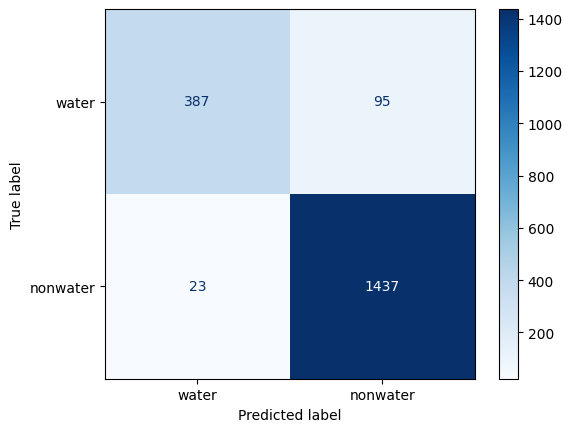

In [ ]:
hf_lowslope_allconf = confusion_matrix_reporter(hf_swsl_allpoints, 'hydrafloods_water', 'hydrafloods slope class 1 (low slope)', filter_prop = 'slope_class', filter_value = 1)

path1
hydrafloods slope class 2 (moderately low slope) accuracy: 0.942
hydrafloods slope class 2 (moderately low slope) f1 score: 0.632
hydrafloods slope class 2 (moderately low slope) Precision (aka user's accuracy for water): 1.000
hydrafloods slope class 2 (moderately low slope) Recall (aka producer's accuracy for water): 0.462
hydrafloods slope class 2 (moderately low slope) Specificity (aka producer's accuracy for nonwater): 1.000
hydrafloods slope class 2 (moderately low slope) Normalized Matthew's Correlation Coefficien: 0.829


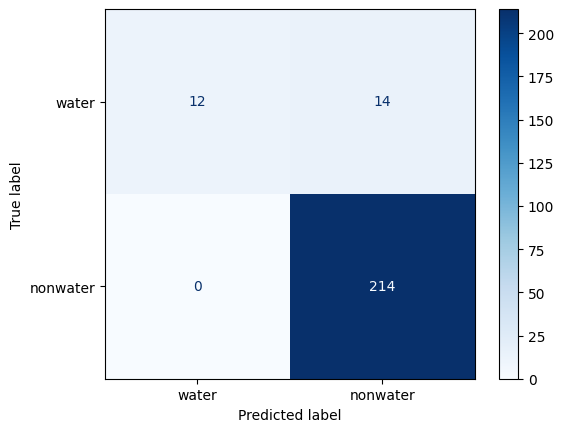

In [ ]:
hf_modlowslope_allconf = confusion_matrix_reporter(hf_swsl_allpoints, 'hydrafloods_water', 'hydrafloods slope class 2 (moderately low slope)', filter_prop = 'slope_class', filter_value = 2)

path1
hydrafloods slope class 3 (moderately high slope) accuracy: 0.791
hydrafloods slope class 3 (moderately high slope) f1 score: 0.690
hydrafloods slope class 3 (moderately high slope) Precision (aka user's accuracy for water): 0.909
hydrafloods slope class 3 (moderately high slope) Recall (aka producer's accuracy for water): 0.556
hydrafloods slope class 3 (moderately high slope) Specificity (aka producer's accuracy for nonwater): 0.960
hydrafloods slope class 3 (moderately high slope) Normalized Matthew's Correlation Coefficien: 0.791


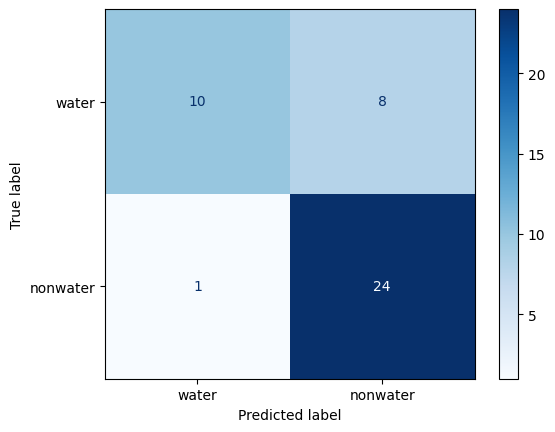

In [ ]:
hf_modhighslope_allconf = confusion_matrix_reporter(hf_swsl_allpoints, 'hydrafloods_water', 'hydrafloods slope class 3 (moderately high slope)', filter_prop = 'slope_class', filter_value = 3)

### HYDROSAR Slope -- All Confidences

In [ ]:
# HYDROSAR Sampled with Slope Information
#hs_swsl_allpoints = sl_class.sampleRegions(hs_sampled_allpoints, geometries=True, projection = my_proj_string, scale = my_scale)

AttributeError: 'int' object has no attribute 'sampleRegions'

path1
hydrosar slope class 1 (low slope) accuracy: 0.907
hydrosar slope class 1 (low slope) f1 score: 0.777
hydrosar slope class 1 (low slope) Precision (aka user's accuracy for water): 0.957
hydrosar slope class 1 (low slope) Recall (aka producer's accuracy for water): 0.654
hydrosar slope class 1 (low slope) Specificity (aka producer's accuracy for nonwater): 0.990
hydrosar slope class 1 (low slope) Normalized Matthew's Correlation Coefficien: 0.871


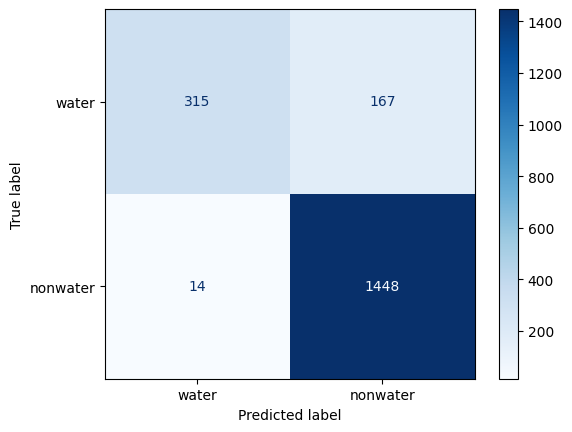

In [ ]:
hs_lowslo_allconf = confusion_matrix_reporter(hs_swsl_allpoints, 'hydrosar_water', 'hydrosar slope class 1 (low slope)', filter_prop = 'slope_class', filter_value = 1)

path1
hydrosar slope class 2 (moderately low slope) accuracy: 0.929
hydrosar slope class 2 (moderately low slope) f1 score: 0.514
hydrosar slope class 2 (moderately low slope) Precision (aka user's accuracy for water): 1.000
hydrosar slope class 2 (moderately low slope) Recall (aka producer's accuracy for water): 0.346
hydrosar slope class 2 (moderately low slope) Specificity (aka producer's accuracy for nonwater): 1.000
hydrosar slope class 2 (moderately low slope) Normalized Matthew's Correlation Coefficien: 0.783


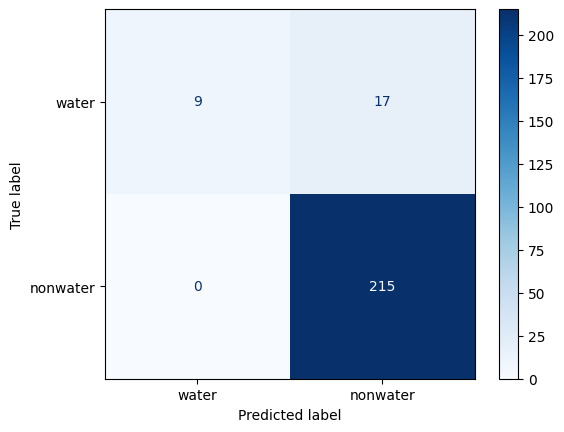

In [ ]:
hs_modlowslo_allconf = confusion_matrix_reporter(hs_swsl_allpoints, 'hydrosar_water', 'hydrosar slope class 2 (moderately low slope)',
                                           filter_prop = 'slope_class', filter_value = 2)

path1
hydrosar slope class 3 (moderately high slope) accuracy: 0.791
hydrosar slope class 3 (moderately high slope) f1 score: 0.667
hydrosar slope class 3 (moderately high slope) Precision (aka user's accuracy for water): 1.000
hydrosar slope class 3 (moderately high slope) Recall (aka producer's accuracy for water): 0.500
hydrosar slope class 3 (moderately high slope) Specificity (aka producer's accuracy for nonwater): 1.000
hydrosar slope class 3 (moderately high slope) Normalized Matthew's Correlation Coefficien: 0.803


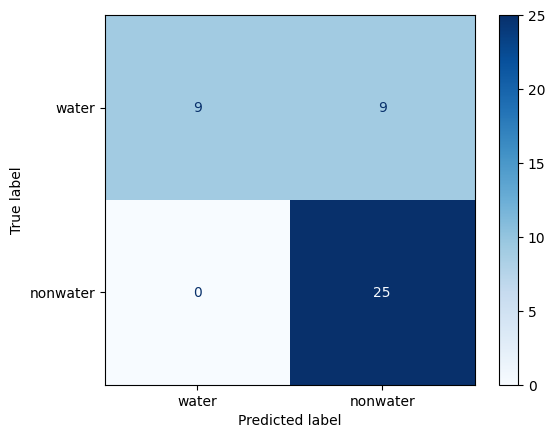

In [ ]:
hs_modhighslo_allconf = confusion_matrix_reporter(hs_swsl_allpoints, 'hydrosar_water', 'hydrosar slope class 3 (moderately high slope)', filter_prop = 'slope_class', filter_value = 3)

### GFM Slope -- All Confidences

In [ ]:
# GFM Sampled with Slope Information
#gfm_swsl_allpoints = sl_class.sampleRegions(gfm_sampled_allpoints, geometries=True, projection = my_proj_string, scale = my_scale)

path1
GFM slope class 1 (low slope) accuracy: 0.939
GFM slope class 1 (low slope) f1 score: 0.867
GFM slope class 1 (low slope) Precision (aka user's accuracy for water): 0.946
GFM slope class 1 (low slope) Recall (aka producer's accuracy for water): 0.801
GFM slope class 1 (low slope) Specificity (aka producer's accuracy for nonwater): 0.985
GFM slope class 1 (low slope) Normalized Matthew's Correlation Coefficien: 0.917


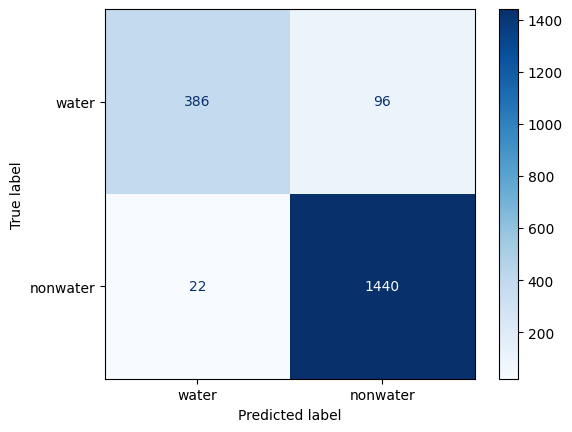

In [ ]:
gfm_loslo_allconf = confusion_matrix_reporter(gfm_swsl_allpoints, 'gfm_water', 'GFM slope class 1 (low slope)', filter_prop = 'slope_class', filter_value = 1)

path1
GFM slope class 2 (moderately low slope) accuracy: 0.950
GFM slope class 2 (moderately low slope) f1 score: 0.760
GFM slope class 2 (moderately low slope) Precision (aka user's accuracy for water): 0.792
GFM slope class 2 (moderately low slope) Recall (aka producer's accuracy for water): 0.731
GFM slope class 2 (moderately low slope) Specificity (aka producer's accuracy for nonwater): 0.977
GFM slope class 2 (moderately low slope) Normalized Matthew's Correlation Coefficien: 0.867


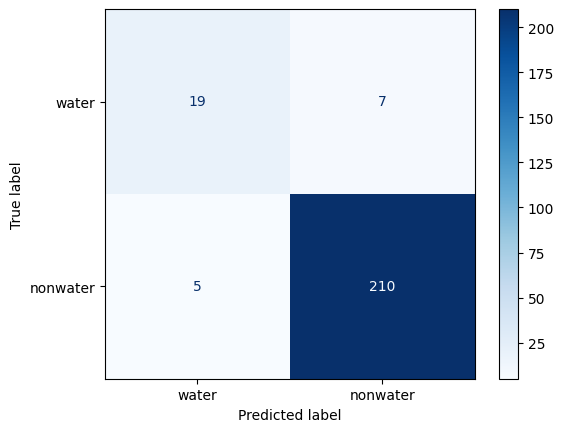

In [ ]:
gfm_modloslo_allconf = confusion_matrix_reporter(gfm_swsl_allpoints, 'gfm_water', 'GFM slope class 2 (moderately low slope)', filter_prop = 'slope_class', filter_value = 2)

path1
GFM slope class 3 (moderately high slope) accuracy: 0.884
GFM slope class 3 (moderately high slope) f1 score: 0.857
GFM slope class 3 (moderately high slope) Precision (aka user's accuracy for water): 0.882
GFM slope class 3 (moderately high slope) Recall (aka producer's accuracy for water): 0.833
GFM slope class 3 (moderately high slope) Specificity (aka producer's accuracy for nonwater): 0.920
GFM slope class 3 (moderately high slope) Normalized Matthew's Correlation Coefficien: 0.880


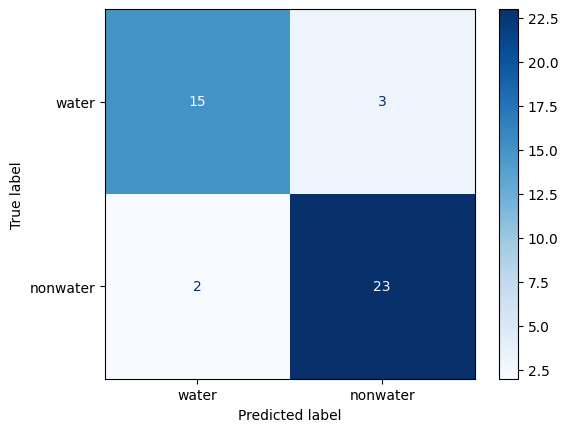

In [ ]:
gfm_modhislo_allconf = confusion_matrix_reporter(gfm_swsl_allpoints, 'gfm_water', 'GFM slope class 3 (moderately high slope)', filter_prop = 'slope_class', filter_value = 3)

### DSWx-HLS Slope -- All Confidences

In [ ]:
# DSWx-HLS Sampled with Slope Information
#dswxhls_swsl_allpoints = sl_class.sampleRegions(dswxhls_sampled_allpoints, geometries=True, projection = my_proj_string, scale = my_scale)

path1
DSWx-HLS slope class 1 (low slope) accuracy: 0.826
DSWx-HLS slope class 1 (low slope) f1 score: 0.499
DSWx-HLS slope class 1 (low slope) Precision (aka user's accuracy for water): 0.867
DSWx-HLS slope class 1 (low slope) Recall (aka producer's accuracy for water): 0.351
DSWx-HLS slope class 1 (low slope) Specificity (aka producer's accuracy for nonwater): 0.982
DSWx-HLS slope class 1 (low slope) Normalized Matthew's Correlation Coefficien: 0.739


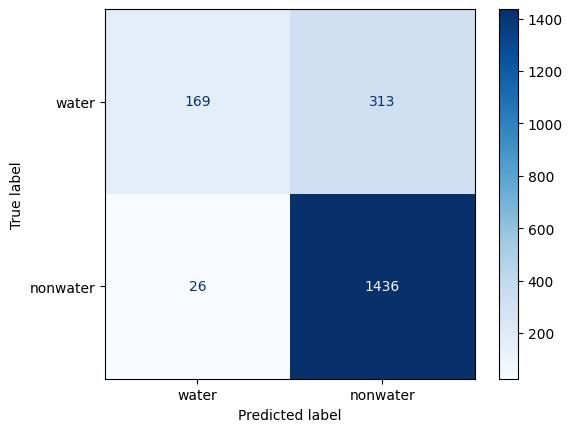

In [ ]:
dswxhls_loslo_allconf = confusion_matrix_reporter(dswxhls_swsl_allpoints, 'dswxhls_water', 'DSWx-HLS slope class 1 (low slope)', filter_prop = 'slope_class', filter_value = 1)

path1
DSWx-HLS slope class 2 (moderately low slope) accuracy: 0.905
DSWx-HLS slope class 2 (moderately low slope) f1 score: 0.439
DSWx-HLS slope class 2 (moderately low slope) Precision (aka user's accuracy for water): 0.600
DSWx-HLS slope class 2 (moderately low slope) Recall (aka producer's accuracy for water): 0.346
DSWx-HLS slope class 2 (moderately low slope) Specificity (aka producer's accuracy for nonwater): 0.972
DSWx-HLS slope class 2 (moderately low slope) Normalized Matthew's Correlation Coefficien: 0.704


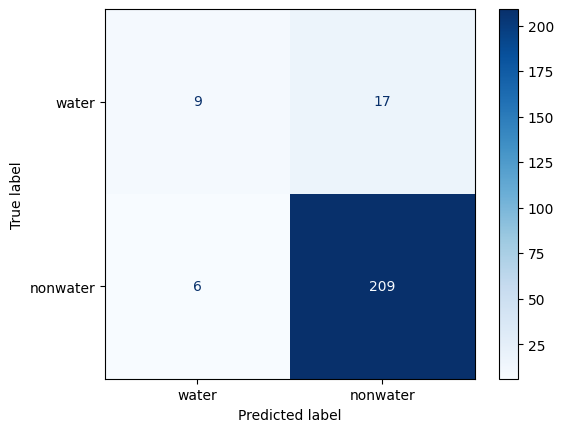

In [ ]:
dswxhls_modloslo_allconf = confusion_matrix_reporter(dswxhls_swsl_allpoints, 'dswxhls_water', 'DSWx-HLS slope class 2 (moderately low slope)', filter_prop = 'slope_class', filter_value = 2)

path1
DSWx-HLS slope class 3 (moderately high slope) accuracy: 0.558
DSWx-HLS slope class 3 (moderately high slope) f1 score: 0.296
DSWx-HLS slope class 3 (moderately high slope) Precision (aka user's accuracy for water): 0.444
DSWx-HLS slope class 3 (moderately high slope) Recall (aka producer's accuracy for water): 0.222
DSWx-HLS slope class 3 (moderately high slope) Specificity (aka producer's accuracy for nonwater): 0.800
DSWx-HLS slope class 3 (moderately high slope) Normalized Matthew's Correlation Coefficien: 0.513


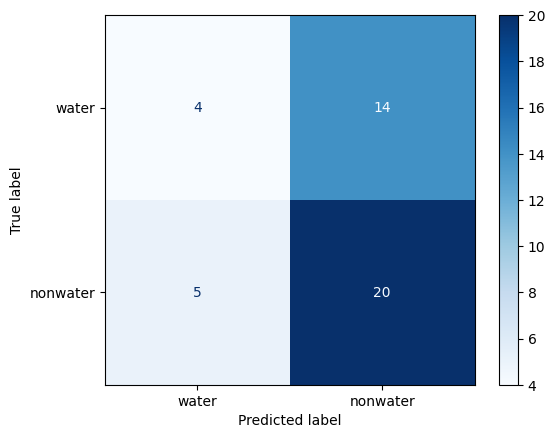

In [ ]:
dswxhls_modhislo_allconf = confusion_matrix_reporter(dswxhls_swsl_allpoints, 'dswxhls_water', 'DSWx-HLS slope class 3 (moderately high slope)', filter_prop = 'slope_class', filter_value = 3)

### DSWx-S1 Slope -- All Confidences

In [ ]:
# DSWx-S1 Sampled with Slope Information, all confidence points
#dswxs1_swsl_allconf = sl_class.sampleRegions(dswxs1_sampled_allpoints, geometries=True, projection = my_proj_string, scale = my_scale)

path1
DSWx-S1 slope class 1 (low slope) accuracy: 0.765
DSWx-S1 slope class 1 (low slope) f1 score: 0.109
DSWx-S1 slope class 1 (low slope) Precision (aka user's accuracy for water): 0.933
DSWx-S1 slope class 1 (low slope) Recall (aka producer's accuracy for water): 0.058
DSWx-S1 slope class 1 (low slope) Specificity (aka producer's accuracy for nonwater): 0.999
DSWx-S1 slope class 1 (low slope) Normalized Matthew's Correlation Coefficien: 0.599


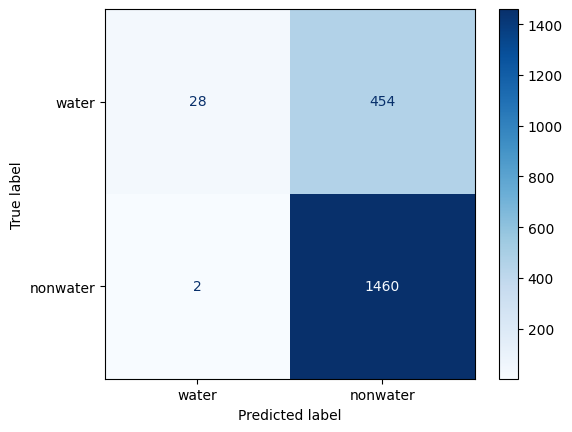

In [ ]:
dswxs1_loslo_allconf = confusion_matrix_reporter(dswxs1_swsl_allconf, 'dswxs1_water', 'DSWx-S1 slope class 1 (low slope)',
                                                 filter_prop = 'slope_class', filter_value = 1)

path1
DSWx-S1 slope class 2 (moderately low slope) accuracy: 0.892
DSWx-S1 slope class 2 (moderately low slope) f1 score: 0.188
DSWx-S1 slope class 2 (moderately low slope) Precision (aka user's accuracy for water): 0.500
DSWx-S1 slope class 2 (moderately low slope) Recall (aka producer's accuracy for water): 0.115
DSWx-S1 slope class 2 (moderately low slope) Specificity (aka producer's accuracy for nonwater): 0.986
DSWx-S1 slope class 2 (moderately low slope) Normalized Matthew's Correlation Coefficien: 0.601


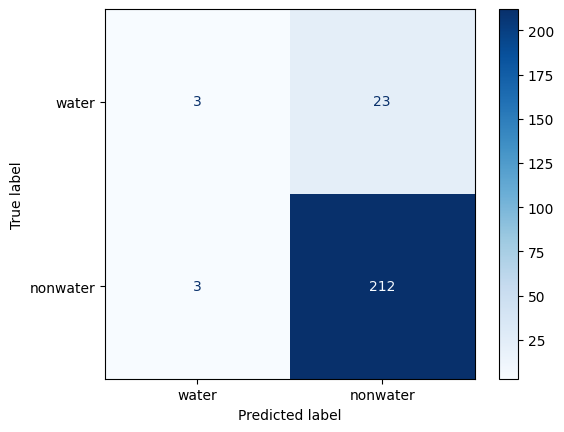

In [ ]:
dswxs1_modloslo_allconf = confusion_matrix_reporter(dswxs1_swsl_allconf, 'dswxs1_water', 'DSWx-S1 slope class 2 (moderately low slope)',
                                                    filter_prop = 'slope_class', filter_value = 2)

path1
DSWx-S1 slope class 3 (moderately high slope) accuracy: 0.581
DSWx-S1 slope class 3 (moderately high slope) f1 score: 0.308
DSWx-S1 slope class 3 (moderately high slope) Precision (aka user's accuracy for water): 0.500
DSWx-S1 slope class 3 (moderately high slope) Recall (aka producer's accuracy for water): 0.222
DSWx-S1 slope class 3 (moderately high slope) Specificity (aka producer's accuracy for nonwater): 0.840
DSWx-S1 slope class 3 (moderately high slope) Normalized Matthew's Correlation Coefficien: 0.539


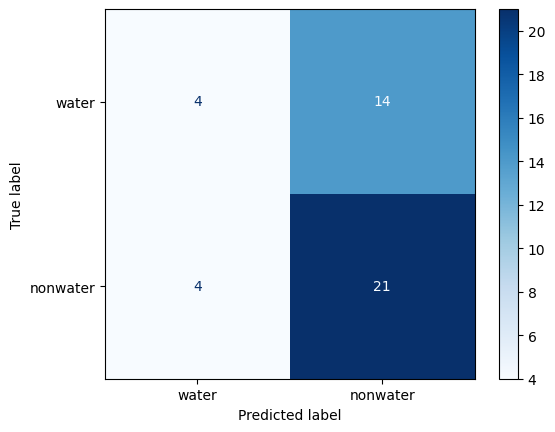

In [ ]:
dswxs1_modhislo_allconf = confusion_matrix_reporter(dswxs1_swsl_allconf, 'dswxs1_water', 'DSWx-S1 slope class 3 (moderately high slope)',
                                                    filter_prop = 'slope_class', filter_value = 3)

### MCDWD Slope -- All Confidences

In [ ]:
# MCDWD Sampled with Slope Information
#mcdwd_swsl_allconf = sl_class.sampleRegions(mcdwd_sampled_allpoints, geometries=True, projection = my_proj_string, scale = my_scale)

path1
DSWx-HLS slope class 1 (low slope) accuracy: 0.819
DSWx-HLS slope class 1 (low slope) f1 score: 0.440
DSWx-HLS slope class 1 (low slope) Precision (aka user's accuracy for water): 0.952
DSWx-HLS slope class 1 (low slope) Recall (aka producer's accuracy for water): 0.286
DSWx-HLS slope class 1 (low slope) Specificity (aka producer's accuracy for nonwater): 0.995
DSWx-HLS slope class 1 (low slope) Normalized Matthew's Correlation Coefficien: 0.731


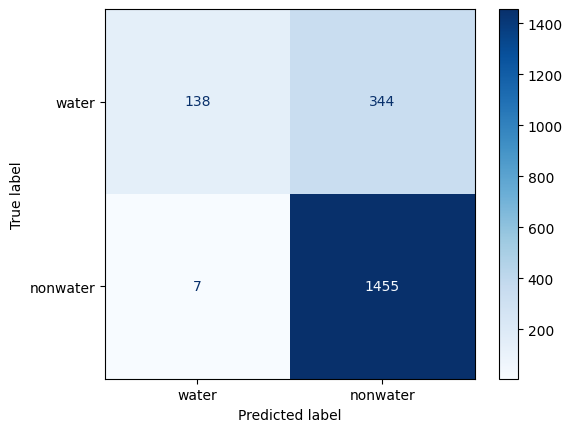

In [ ]:
# MCDWD Low Slope All Confidences
mcdwd_loslo_allconf = confusion_matrix_reporter(mcdwd_swsl_allpoints, 'mcdwd_water', 'DSWx-HLS slope class 1 (low slope)', filter_prop = 'slope_class', filter_value = 1)

path1
MCDWD slope class 2 (moderately low slope) accuracy: 0.913
MCDWD slope class 2 (moderately low slope) f1 score: 0.462
MCDWD slope class 2 (moderately low slope) Precision (aka user's accuracy for water): 0.692
MCDWD slope class 2 (moderately low slope) Recall (aka producer's accuracy for water): 0.346
MCDWD slope class 2 (moderately low slope) Specificity (aka producer's accuracy for nonwater): 0.981
MCDWD slope class 2 (moderately low slope) Normalized Matthew's Correlation Coefficien: 0.725


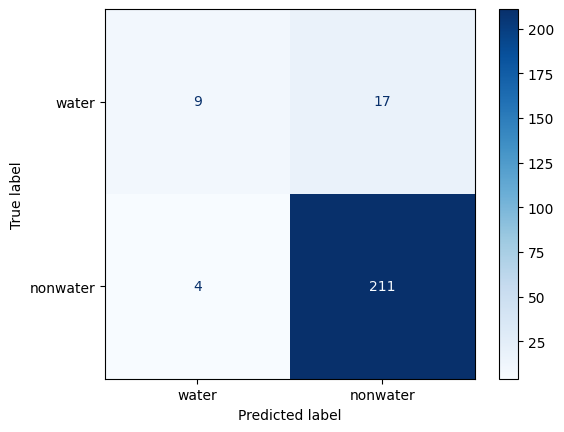

In [ ]:
mcdwd_modloslo_allconf = confusion_matrix_reporter(mcdwd_swsl_allconf, 'mcdwd_water', 'MCDWD slope class 2 (moderately low slope)', filter_prop = 'slope_class', filter_value = 2)

path1
MCDWD slope class 3 (moderately high slope) accuracy: 0.744
MCDWD slope class 3 (moderately high slope) f1 score: 0.560
MCDWD slope class 3 (moderately high slope) Precision (aka user's accuracy for water): 1.000
MCDWD slope class 3 (moderately high slope) Recall (aka producer's accuracy for water): 0.389
MCDWD slope class 3 (moderately high slope) Specificity (aka producer's accuracy for nonwater): 1.000
MCDWD slope class 3 (moderately high slope) Normalized Matthew's Correlation Coefficien: 0.760


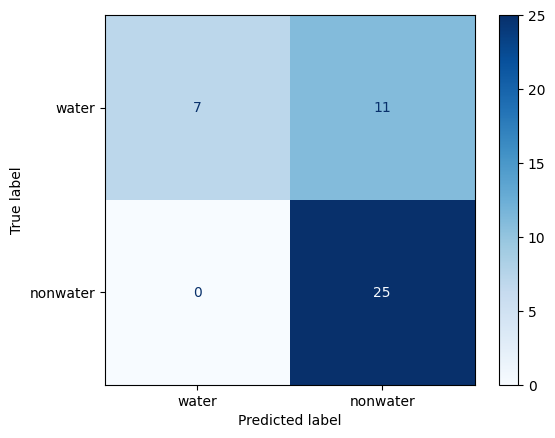

In [ ]:
mcdwd_modhislo_allconf = confusion_matrix_reporter(mcdwd_swsl_allpoints, 'mcdwd_water', 'MCDWD slope class 3 (moderately high slope)', filter_prop = 'slope_class', filter_value = 3)

### VFM Slope -- All Confidences

In [ ]:
# VFM Sampled with Slope Information
#vfm_swsl_allpoints = sl_class.sampleRegions(vfm_sampled_allpoints, geometries=True, projection = my_proj_string, scale = my_scale)

path1
VFM slope class 1 (low slope) accuracy: 0.868
VFM slope class 1 (low slope) f1 score: 0.691
VFM slope class 1 (low slope) Precision (aka user's accuracy for water): 0.793
VFM slope class 1 (low slope) Recall (aka producer's accuracy for water): 0.613
VFM slope class 1 (low slope) Specificity (aka producer's accuracy for nonwater): 0.949
VFM slope class 1 (low slope) Normalized Matthew's Correlation Coefficien: 0.809


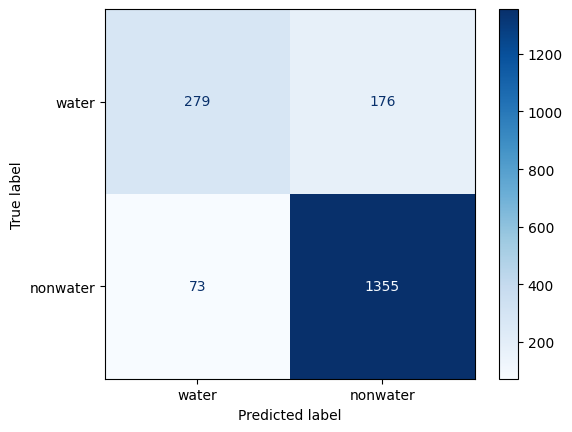

In [ ]:
vfm_loslo_allconf = confusion_matrix_reporter(vfm_swsl_allpoints, 'vfm_water', 'VFM slope class 1 (low slope)', filter_prop = 'slope_class', filter_value = 1)

path1
VFM slope class 2 (moderately low slope) accuracy: 0.921
VFM slope class 2 (moderately low slope) f1 score: 0.763
VFM slope class 2 (moderately low slope) Precision (aka user's accuracy for water): 0.755
VFM slope class 2 (moderately low slope) Recall (aka producer's accuracy for water): 0.771
VFM slope class 2 (moderately low slope) Specificity (aka producer's accuracy for nonwater): 0.951
VFM slope class 2 (moderately low slope) Normalized Matthew's Correlation Coefficien: 0.858


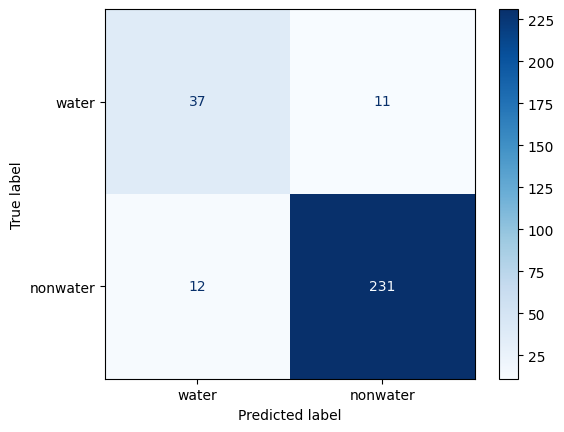

In [ ]:
vfm_modloslo_allconf = confusion_matrix_reporter(vfm_swsl_allpoints, 'vfm_water', 'VFM slope class 2 (moderately low slope)', filter_prop = 'slope_class', filter_value = 2)

path1
VFM slope class 3 (moderately high slope) accuracy: 0.896
VFM slope class 3 (moderately high slope) f1 score: 0.878
VFM slope class 3 (moderately high slope) Precision (aka user's accuracy for water): 1.000
VFM slope class 3 (moderately high slope) Recall (aka producer's accuracy for water): 0.783
VFM slope class 3 (moderately high slope) Specificity (aka producer's accuracy for nonwater): 1.000
VFM slope class 3 (moderately high slope) Normalized Matthew's Correlation Coefficien: 0.904


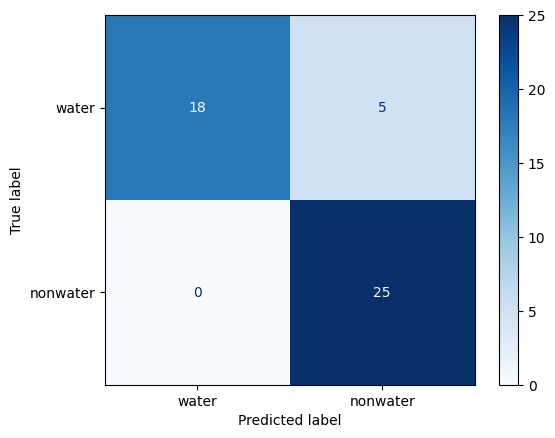

In [ ]:
vfm_modhislo_allconf = confusion_matrix_reporter(vfm_swsl_allpoints, 'vfm_water', 'VFM slope class 3 (moderately high slope)', filter_prop = 'slope_class', filter_value = 3)

## Step 4 Part 3.2: Slope analysis of points with High Confidence Points

### HYDRAFloods Slope -- High Confidence

In [ ]:
#hf_swsl_highconf = sl_class.sampleRegions(hf_sampled_highconf, geometries=True, projection = my_proj_string, scale = my_scale) # hydrafloods sampled with slope information

path1
HYDRAFloods Low Slope High Confidence) accuracy: 0.975
HYDRAFloods Low Slope High Confidence) f1 score: 0.934
HYDRAFloods Low Slope High Confidence) Precision (aka user's accuracy for water): 0.974
HYDRAFloods Low Slope High Confidence) Recall (aka producer's accuracy for water): 0.897
HYDRAFloods Low Slope High Confidence) Specificity (aka producer's accuracy for nonwater): 0.994
HYDRAFloods Low Slope High Confidence) Normalized Matthew's Correlation Coefficien: 0.960


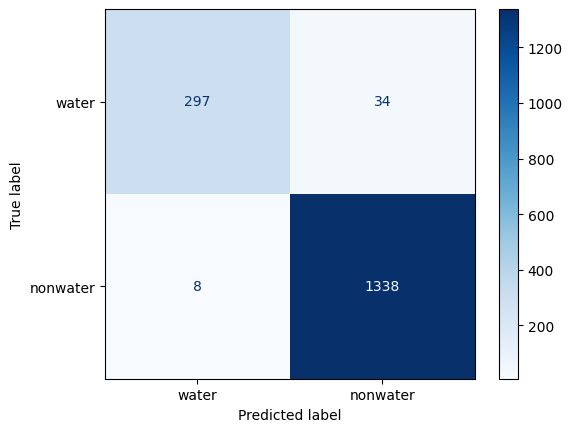

In [ ]:
# HYDRAFloods Low Slope High Confidence
hf_loslo_highconf = confusion_matrix_reporter(hf_swsl_highconf, 'hydrafloods_water', 'HYDRAFloods Low Slope High Confidence)',
                                               filter_prop = 'slope_class', filter_value = 1)

path1
HYDRAFloods Moderately Low Slope  accuracy: 0.971
HYDRAFloods Moderately Low Slope  f1 score: 0.727
HYDRAFloods Moderately Low Slope  Precision (aka user's accuracy for water): 1.000
HYDRAFloods Moderately Low Slope  Recall (aka producer's accuracy for water): 0.571
HYDRAFloods Moderately Low Slope  Specificity (aka producer's accuracy for nonwater): 1.000
HYDRAFloods Moderately Low Slope  Normalized Matthew's Correlation Coefficien: 0.872


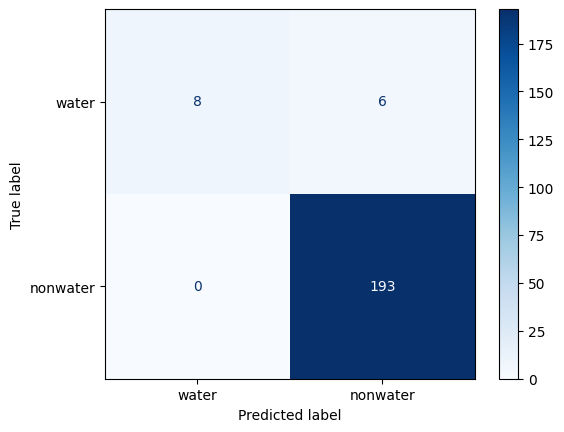

In [ ]:
hf_modlowslo_highconf = confusion_matrix_reporter(hf_swsl_highconf, 'hydrafloods_water', 'HYDRAFloods Moderately Low Slope ',
                                                  filter_prop = 'slope_class', filter_value = 2)

path1
HYDRAFloods Moderately High Slope  accuracy: 0.893
HYDRAFloods Moderately High Slope  f1 score: 0.824
HYDRAFloods Moderately High Slope  Precision (aka user's accuracy for water): 1.000
HYDRAFloods Moderately High Slope  Recall (aka producer's accuracy for water): 0.700
HYDRAFloods Moderately High Slope  Specificity (aka producer's accuracy for nonwater): 1.000
HYDRAFloods Moderately High Slope  Normalized Matthew's Correlation Coefficien: 0.887


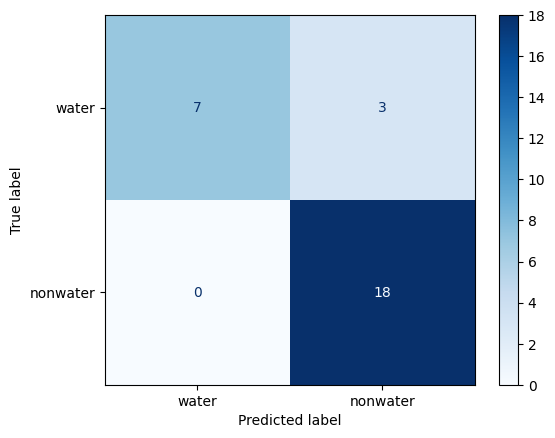

In [ ]:
hf_modhislo_highconf = confusion_matrix_reporter(hf_swsl_highconf, 'hydrafloods_water', 'HYDRAFloods Moderately High Slope ',
                                                  filter_prop = 'slope_class', filter_value = 3)

### HYDROSAR Slope -- High Confidence

In [ ]:
#hs_swsl_highconf = sl_class.sampleRegions(hs_sampled_highconf, geometries=True,
#                                          projection = my_proj_string, scale = my_scale) # hydrafloods sampled with slope information

path1
HYDRAFloods Low Slope  accuracy: 0.949
HYDRAFloods Low Slope  f1 score: 0.853
HYDRAFloods Low Slope  Precision (aka user's accuracy for water): 0.980
HYDRAFloods Low Slope  Recall (aka producer's accuracy for water): 0.755
HYDRAFloods Low Slope  Specificity (aka producer's accuracy for nonwater): 0.996
HYDRAFloods Low Slope  Normalized Matthew's Correlation Coefficien: 0.917


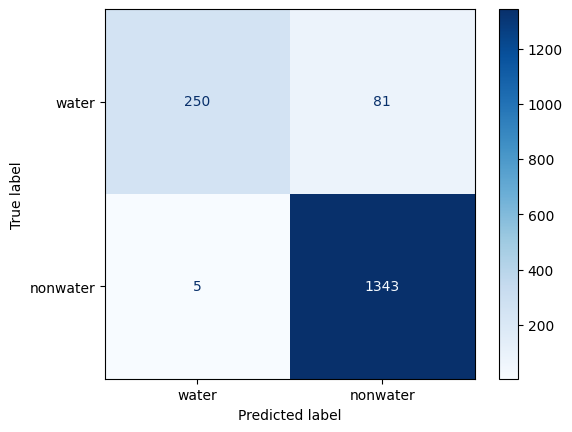

In [ ]:
hs_lowslo_highconf = confusion_matrix_reporter(hs_swsl_highconf, 'hydrosar_water', 'HYDRAFloods Low Slope ',
                                                  filter_prop = 'slope_class', filter_value = 1)

path1
HYDRAFloods Moderately Low Slope  accuracy: 0.962
HYDRAFloods Moderately Low Slope  f1 score: 0.600
HYDRAFloods Moderately Low Slope  Precision (aka user's accuracy for water): 1.000
HYDRAFloods Moderately Low Slope  Recall (aka producer's accuracy for water): 0.429
HYDRAFloods Moderately Low Slope  Specificity (aka producer's accuracy for nonwater): 1.000
HYDRAFloods Moderately Low Slope  Normalized Matthew's Correlation Coefficien: 0.821


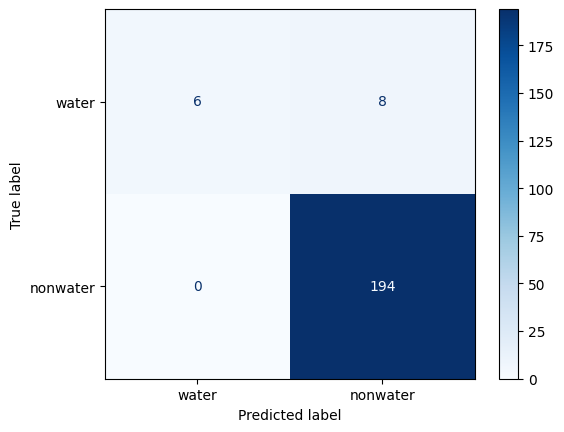

In [ ]:
hs_modlowslo_highconf = confusion_matrix_reporter(hs_swsl_highconf, 'hydrosar_water', 'HYDRAFloods Moderately Low Slope ',
                                                  filter_prop = 'slope_class', filter_value = 2)

path1
HYDRAFloods High Slope  accuracy: 0.893
HYDRAFloods High Slope  f1 score: 0.824
HYDRAFloods High Slope  Precision (aka user's accuracy for water): 1.000
HYDRAFloods High Slope  Recall (aka producer's accuracy for water): 0.700
HYDRAFloods High Slope  Specificity (aka producer's accuracy for nonwater): 1.000
HYDRAFloods High Slope  Normalized Matthew's Correlation Coefficien: 0.887


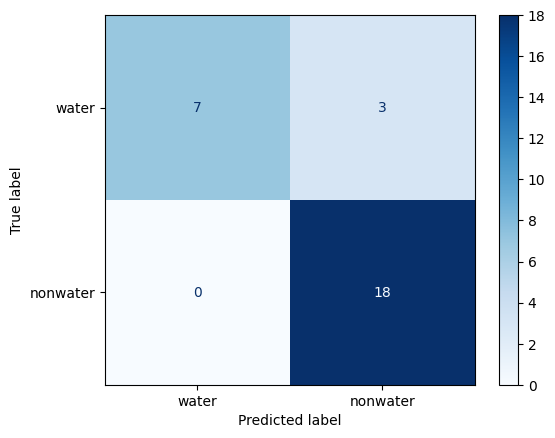

In [ ]:
hs_modhighslo_highconf = confusion_matrix_reporter(hs_swsl_highconf, 'hydrosar_water', 'HYDRAFloods High Slope ',
                                                  filter_prop = 'slope_class', filter_value = 3)

### GFM Slope -- High Confidence

In [ ]:
#gfm_swsl_highconf = sl_class.sampleRegions(gfm_sampled_highconf, geometries=True,
#                                          projection = my_proj_string, scale = my_scale)

path1
GFM Low Slope  accuracy: 0.976
GFM Low Slope  f1 score: 0.935
GFM Low Slope  Precision (aka user's accuracy for water): 0.983
GFM Low Slope  Recall (aka producer's accuracy for water): 0.891
GFM Low Slope  Specificity (aka producer's accuracy for nonwater): 0.996
GFM Low Slope  Normalized Matthew's Correlation Coefficien: 0.961


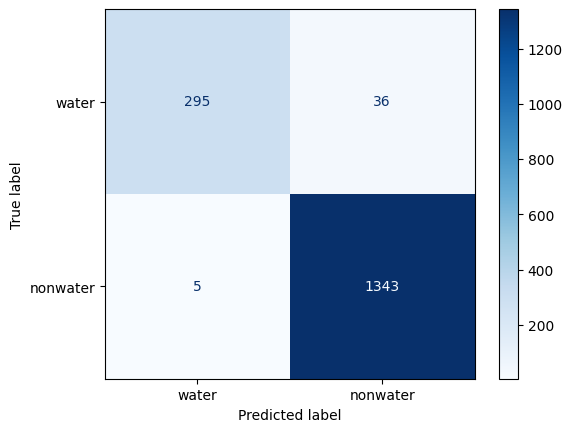

In [ ]:
gfm_lowslo_highconf = confusion_matrix_reporter(gfm_swsl_highconf, 'gfm_water', 'GFM Low Slope ',
                                                  filter_prop = 'slope_class', filter_value = 1)

path1
GFM Moderately Low Slope  accuracy: 0.990
GFM Moderately Low Slope  f1 score: 0.929
GFM Moderately Low Slope  Precision (aka user's accuracy for water): 0.929
GFM Moderately Low Slope  Recall (aka producer's accuracy for water): 0.929
GFM Moderately Low Slope  Specificity (aka producer's accuracy for nonwater): 0.995
GFM Moderately Low Slope  Normalized Matthew's Correlation Coefficien: 0.962


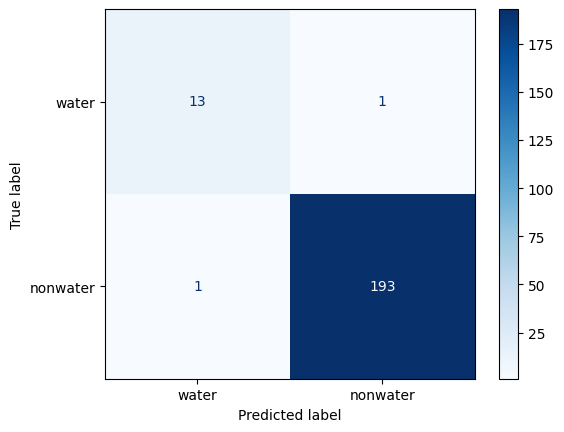

In [ ]:
gfm_modlowslo_highconf = confusion_matrix_reporter(gfm_swsl_highconf, 'gfm_water', 'GFM Moderately Low Slope ',
                                                  filter_prop = 'slope_class', filter_value = 2)

path1
GFM Moderately High Slope accuracy: 0.929
GFM Moderately High Slope f1 score: 0.889
GFM Moderately High Slope Precision (aka user's accuracy for water): 1.000
GFM Moderately High Slope Recall (aka producer's accuracy for water): 0.800
GFM Moderately High Slope Specificity (aka producer's accuracy for nonwater): 1.000
GFM Moderately High Slope Normalized Matthew's Correlation Coefficien: 0.924


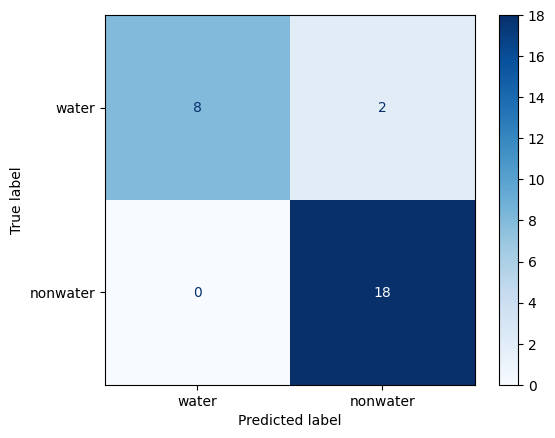

In [ ]:
gfm_modhighslo_highconf = confusion_matrix_reporter(gfm_swsl_highconf, 'gfm_water', 'GFM Moderately High Slope',
                                                  filter_prop = 'slope_class', filter_value = 3)

### DSWx-HLS Slope -- High Confidence

In [ ]:
# DSWxHLS Sampled with Slope -- High Confidence Points Only
#dswxhls_swsl_highconf = sl_class.sampleRegions(dswxhls_sampled_highconf, geometries=True,
#                                          projection = my_proj_string, scale = my_scale)

path1
DSWx-HLS Low Slope  accuracy: 0.877
DSWx-HLS Low Slope  f1 score: 0.567
DSWx-HLS Low Slope  Precision (aka user's accuracy for water): 0.931
DSWx-HLS Low Slope  Recall (aka producer's accuracy for water): 0.408
DSWx-HLS Low Slope  Specificity (aka producer's accuracy for nonwater): 0.993
DSWx-HLS Low Slope  Normalized Matthew's Correlation Coefficien: 0.784


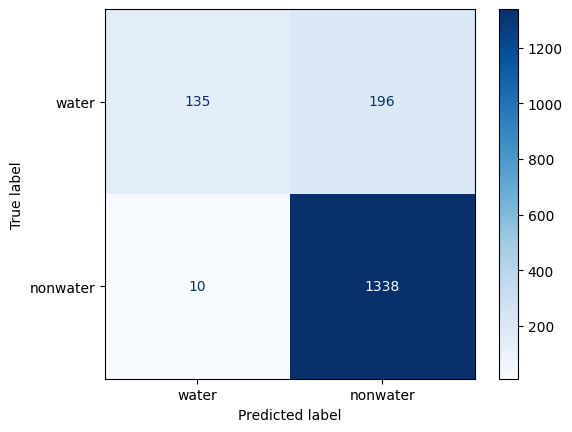

In [ ]:
dswxhls_lowslo_highconf = confusion_matrix_reporter(dswxhls_swsl_highconf, 'dswxhls_water', 'DSWx-HLS Low Slope ',
                                                  filter_prop = 'slope_class', filter_value = 1)

path1
DSWx-HLS Moderately Low Slope High Confidence accuracy: 0.947
DSWx-HLS Moderately Low Slope High Confidence f1 score: 0.476
DSWx-HLS Moderately Low Slope High Confidence Precision (aka user's accuracy for water): 0.714
DSWx-HLS Moderately Low Slope High Confidence Recall (aka producer's accuracy for water): 0.357
DSWx-HLS Moderately Low Slope High Confidence Specificity (aka producer's accuracy for nonwater): 0.990
DSWx-HLS Moderately Low Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.741


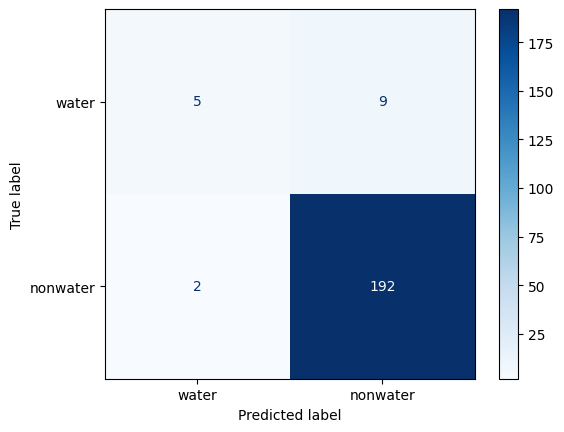

In [ ]:
dswxhls_modlowslo_highconf = confusion_matrix_reporter(dswxhls_swsl_highconf, 'dswxhls_water',
                                                       'DSWx-HLS Moderately Low Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 2)

path1
DSWx-HLS Moderately High Slope High Confidence accuracy: 0.679
DSWx-HLS Moderately High Slope High Confidence f1 score: 0.400
DSWx-HLS Moderately High Slope High Confidence Precision (aka user's accuracy for water): 0.600
DSWx-HLS Moderately High Slope High Confidence Recall (aka producer's accuracy for water): 0.300
DSWx-HLS Moderately High Slope High Confidence Specificity (aka producer's accuracy for nonwater): 0.889
DSWx-HLS Moderately High Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.618


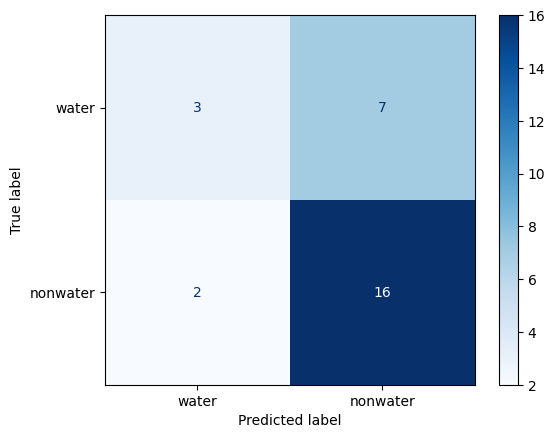

In [ ]:
dswxhls_modhighslo_highconf = confusion_matrix_reporter(dswxhls_swsl_highconf, 'dswxhls_water',
                                                       'DSWx-HLS Moderately High Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 3)

### DSWx-S1 Slope -- High Confidence

In [ ]:
# DSWxS1 Sampled with Slope -- High Confidence Points Only
#dswxs1_swsl_highconf = sl_class.sampleRegions(dswxs1_sampled_highconf, geometries=True,
#                                          projection = my_proj_string, scale = my_scale)

AttributeError: 'int' object has no attribute 'sampleRegions'

path1
DSWx-S1 Low Slope High Confidence accuracy: 0.816
DSWx-S1 Low Slope High Confidence f1 score: 0.130
DSWx-S1 Low Slope High Confidence Precision (aka user's accuracy for water): 0.958
DSWx-S1 Low Slope High Confidence Recall (aka producer's accuracy for water): 0.069
DSWx-S1 Low Slope High Confidence Specificity (aka producer's accuracy for nonwater): 0.999
DSWx-S1 Low Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.615


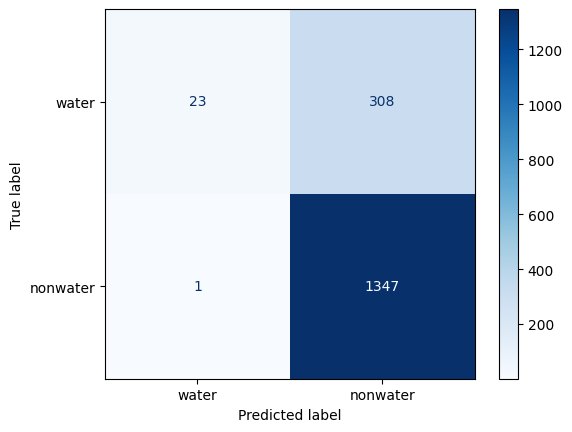

In [ ]:
dswxs1_lowslo_highconf = confusion_matrix_reporter(dswxs1_swsl_highconf, 'dswxs1_water',
                                                       'DSWx-S1 Low Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 1)

path1
DSWx-S1 Moderately Low Slope High Confidence accuracy: 0.942
DSWx-S1 Moderately Low Slope High Confidence f1 score: 0.333
DSWx-S1 Moderately Low Slope High Confidence Precision (aka user's accuracy for water): 0.750
DSWx-S1 Moderately Low Slope High Confidence Recall (aka producer's accuracy for water): 0.214
DSWx-S1 Moderately Low Slope High Confidence Specificity (aka producer's accuracy for nonwater): 0.995
DSWx-S1 Moderately Low Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.691


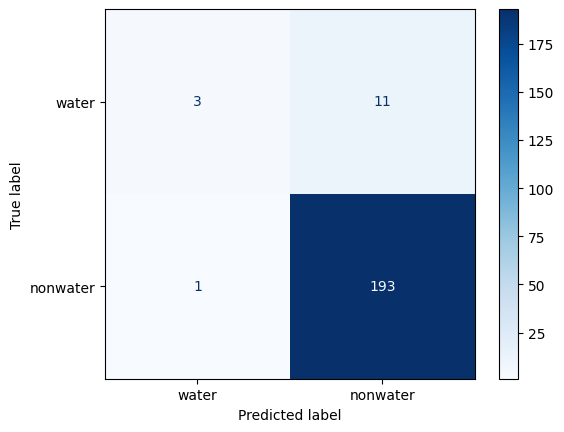

In [ ]:
dswxs1_modlowslo_highconf = confusion_matrix_reporter(dswxs1_swsl_highconf, 'dswxs1_water',
                                                       'DSWx-S1 Moderately Low Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 2)

path1
DSWx-S1 Moderately High Slope High Confidence accuracy: 0.679
DSWx-S1 Moderately High Slope High Confidence f1 score: 0.400
DSWx-S1 Moderately High Slope High Confidence Precision (aka user's accuracy for water): 0.600
DSWx-S1 Moderately High Slope High Confidence Recall (aka producer's accuracy for water): 0.300
DSWx-S1 Moderately High Slope High Confidence Specificity (aka producer's accuracy for nonwater): 0.889
DSWx-S1 Moderately High Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.618


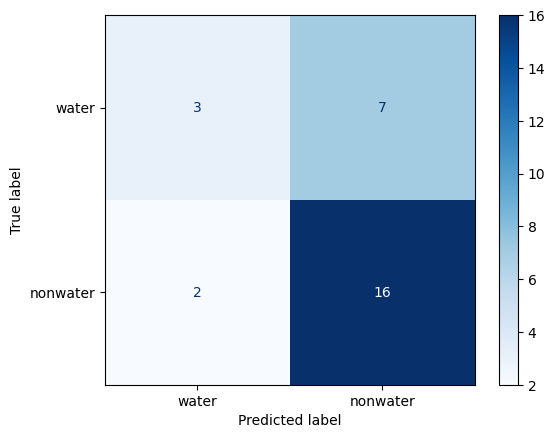

In [ ]:
dswxs1_modhighslo_highconf = confusion_matrix_reporter(dswxs1_swsl_highconf, 'dswxs1_water',
                                                       'DSWx-S1 Moderately High Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 3)

### MCDWD Slope -- High Confidence

In [ ]:
# MCDWD Sampled with Slope -- High Confidence Points Only
#mcdwd_swsl_highconf = sl_class.sampleRegions(mcdwd_sampled_highconf, geometries=True,
#                                          projection = my_proj_string, scale = my_scale)

path1
MCDWD Low Slope High Confidence accuracy: 0.865
MCDWD Low Slope High Confidence f1 score: 0.484
MCDWD Low Slope High Confidence Precision (aka user's accuracy for water): 0.991
MCDWD Low Slope High Confidence Recall (aka producer's accuracy for water): 0.320
MCDWD Low Slope High Confidence Specificity (aka producer's accuracy for nonwater): 0.999
MCDWD Low Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.760


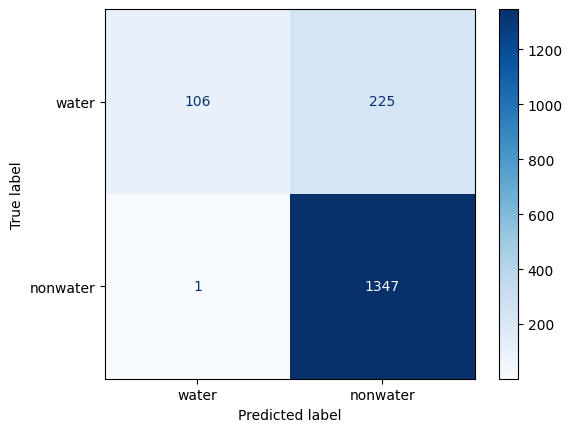

In [ ]:
mcdwd_lowslo_highconf = confusion_matrix_reporter(mcdwd_swsl_highconf, 'mcdwd_water',
                                                       'MCDWD Low Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 1)

path1
MCDWD Moderately Low Slope High Confidence accuracy: 0.952
MCDWD Moderately Low Slope High Confidence f1 score: 0.444
MCDWD Moderately Low Slope High Confidence Precision (aka user's accuracy for water): 1.000
MCDWD Moderately Low Slope High Confidence Recall (aka producer's accuracy for water): 0.286
MCDWD Moderately Low Slope High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
MCDWD Moderately Low Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.761


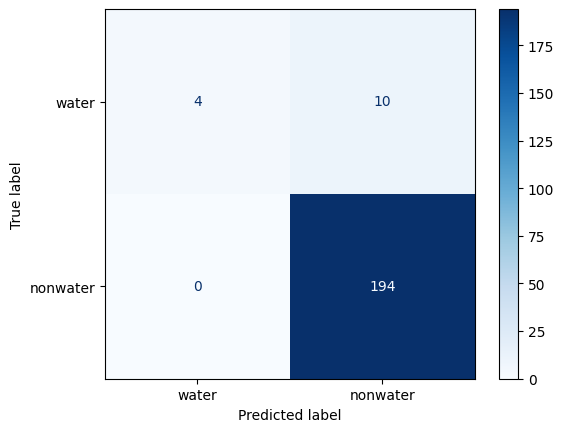

In [ ]:
mcdwd_modlowslo_highconf = confusion_matrix_reporter(mcdwd_swsl_highconf, 'mcdwd_water',
                                                       'MCDWD Moderately Low Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 2)

path1
MCDWD Moderately High Slope High Confidence accuracy: 0.786
MCDWD Moderately High Slope High Confidence f1 score: 0.571
MCDWD Moderately High Slope High Confidence Precision (aka user's accuracy for water): 1.000
MCDWD Moderately High Slope High Confidence Recall (aka producer's accuracy for water): 0.400
MCDWD Moderately High Slope High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
MCDWD Moderately High Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.774


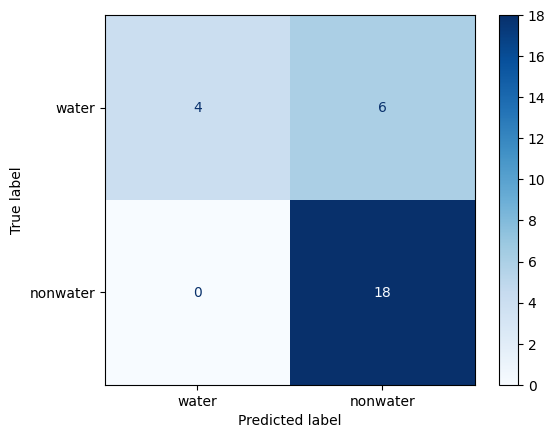

In [ ]:
mcdwd_modhighslo_highconf = confusion_matrix_reporter(mcdwd_swsl_highconf, 'mcdwd_water',
                                                       'MCDWD Moderately High Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 3)

### VFM Slope -- High Confidence

In [ ]:
# VFM Sampled with Slope -- High Confidence Points Only
#vfm_swsl_highconf = sl_class.sampleRegions(vfm_sampled_highconf, geometries=True,
#                                          projection = my_proj_string, scale = my_scale)

path1
VFM Low Slope High Confidence accuracy: 0.913
VFM Low Slope High Confidence f1 score: 0.749
VFM Low Slope High Confidence Precision (aka user's accuracy for water): 0.845
VFM Low Slope High Confidence Recall (aka producer's accuracy for water): 0.673
VFM Low Slope High Confidence Specificity (aka producer's accuracy for nonwater): 0.970
VFM Low Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.852


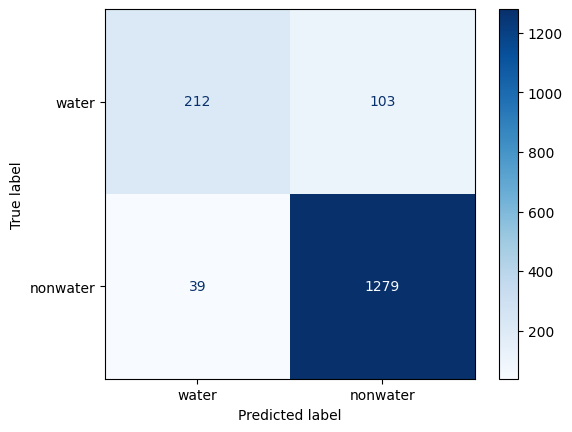

In [ ]:
vfm_lowslo_highconf = confusion_matrix_reporter(vfm_swsl_highconf, 'vfm_water',
                                                       'VFM Low Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 1)

path1
VFM Moderately Low Slope High Confidence accuracy: 0.952
VFM Moderately Low Slope High Confidence f1 score: 0.806
VFM Moderately Low Slope High Confidence Precision (aka user's accuracy for water): 0.781
VFM Moderately Low Slope High Confidence Recall (aka producer's accuracy for water): 0.833
VFM Moderately Low Slope High Confidence Specificity (aka producer's accuracy for nonwater): 0.968
VFM Moderately Low Slope High Confidence Normalized Matthew's Correlation Coefficien: 0.890


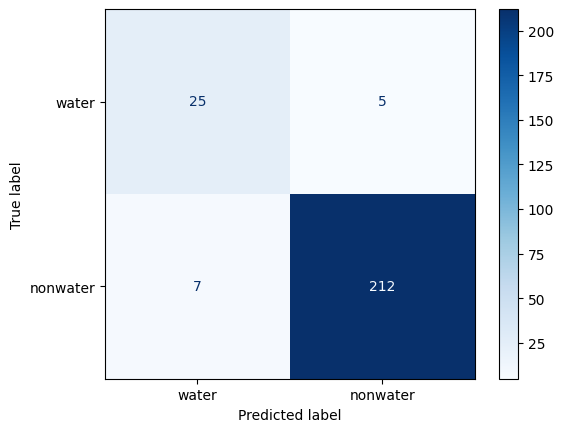

In [ ]:
vfm_modlowslo_highconf = confusion_matrix_reporter(vfm_swsl_highconf, 'vfm_water',
                                                       'VFM Moderately Low Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 2)

path1
VFM Moderately High Slope High Confidence accuracy: 1.000
VFM Moderately High Slope High Confidence f1 score: 1.000
VFM Moderately High Slope High Confidence Precision (aka user's accuracy for water): 1.000
VFM Moderately High Slope High Confidence Recall (aka producer's accuracy for water): 1.000
VFM Moderately High Slope High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
VFM Moderately High Slope High Confidence Normalized Matthew's Correlation Coefficien: 1.000


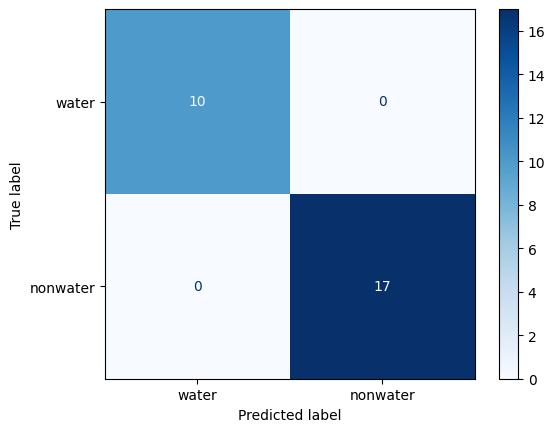

In [ ]:
vfm_modhighslo_highconf = confusion_matrix_reporter(vfm_swsl_highconf, 'vfm_water',
                                                       'VFM Moderately High Slope High Confidence',
                                                       filter_prop = 'slope_class', filter_value = 3)

# Step 4 Part 4

Now, let's use the .sampleRegions() region to add the landcover information to the map.

In [ ]:
# Date at which the flood event starts
#doi = "2023-06-16"

# Get the date from a week prior
#week = ee.Date(doi).advance(-1, 'week')

# Get the date from six months prior
#month6 = ee.Date(doi).advance(-6, 'month')

szn = ee.Date(doi).advance(-3, 'month')

dw = ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")

#dw_filt = dw.filterBounds(aoi).filterDate(week, doi)

# Filter the Dynamic World Image Collection to the area of interest and to the time period from 6 months before the flood event starts
#dw_filt_6 = dw.filterBounds(aoi).filterDate(month6, doi)

# Filter the Dynamic World Image to the beginning of the prior season
dw_filt_seasonal = dw.filterBounds(aoi).filterDate(szn, doi).select(['label'])

# Apply a temporal median reducer at each pixel to dw_filt_6
#dw_redux_6 = dw_filt_6.mode()

dw_redux_sznl = dw_filt_seasonal.mode()

dw_discrete_sznl = dw_redux_sznl.clip(aoi)

In [ ]:
dw_discrete_sznl.bandNames()

In [ ]:
dw_renamed = dw_discrete_sznl.rename(["land_cover"])

In [ ]:
dw_renamed.projection().nominalScale().getInfo()

my_proj_string, my_scale

## Step 4 Part 4.1: Land Cover with All Confidences

In [ ]:
# HYDRAFloods sampled with Slope and Land Cover
hf_swlc_allpoints = dw_renamed.sampleRegions(hf_sampled_allpoints, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# Hydrosar sampled with Land Cover
hs_swlc_allpoints = dw_renamed.sampleRegions(hs_sampled_allpoints, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# GFM sampled with land cover
gfm_swlc_allpoints = dw_renamed.sampleRegions(gfm_sampled_allpoints, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# DSWx-HLS Sampled with Land Cover
dswxhls_swlc_allpoints = dw_renamed.sampleRegions(dswxhls_sampled_allpoints, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# DSWx-S1 sampled with land cover
dswxs1_swlc_allpoints = dw_renamed.sampleRegions(dswxs1_sampled_allpoints, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# VFM sampled with land cover
vfm_swlc_allpoints = dw_renamed.sampleRegions(vfm_sampled_allpoints, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# MCDWD sampled with land cover
mcdwd_swlc_allpoints = dw_renamed.sampleRegions(mcdwd_sampled_allpoints, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

In [ ]:
print(hs_swlc_allpoints.first().getInfo())

In [ ]:
#hf_swlc_all_poi.first().getInfo()

### HYDRAFloods Analysis by Land Cover, All Confidences

path1
HYDRAFloods cropland accuracy: 0.951
HYDRAFloods cropland f1 score: 0.800
HYDRAFloods cropland Precision (aka user's accuracy for water): 1.000
HYDRAFloods cropland Recall (aka producer's accuracy for water): 0.667
HYDRAFloods cropland Specificity (aka producer's accuracy for nonwater): 1.000
HYDRAFloods cropland Normalized Matthew's Correlation Coefficien: 0.897


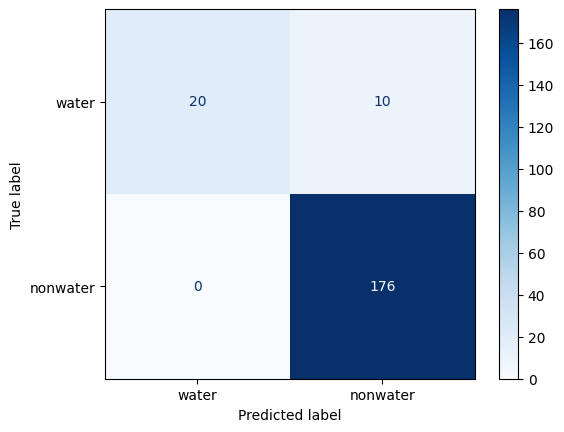

In [ ]:
#hf_cropland = accuracy_reporter(hf_swlc_allpoints, 'reference_water', 'hydrafloods_water', 'hydrafloods cropland all points', filter_bool=True, filter_prop='land_cover', filter_value=4)
hf_cropland_allconf = confusion_matrix_reporter(hf_swlc_allpoints, 'hydrafloods_water', 'HYDRAFloods cropland', filter_prop = 'land_cover', filter_value = 4)

path1
HYDRAFloods Built accuracy: 1.000
HYDRAFloods Built f1 score: 0.000
HYDRAFloods Built Precision (aka user's accuracy for water): 0.000
HYDRAFloods Built Recall (aka producer's accuracy for water): 0.000
HYDRAFloods Built Specificity (aka producer's accuracy for nonwater): 1.000
HYDRAFloods Built Normalized Matthew's Correlation Coefficien: 0.500


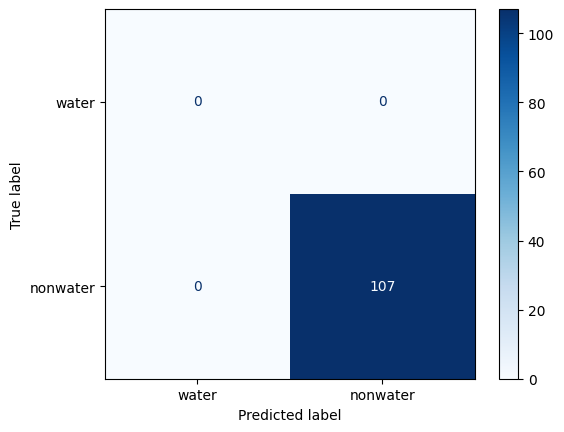

In [ ]:
#hf_built = accuracy_reporter(hf_swlc_allpoints, 'reference_water', 'hydrafloods_water', 'hydrafloods built all points', filter_bool=True, filter_prop='land_cover', filter_value=6)
hf_built_allconf = confusion_matrix_reporter(hf_swlc_allpoints, 'hydrafloods_water', 'HYDRAFloods Built', filter_prop = 'land_cover', filter_value = 6)

path1
HYDRAFloods bare accuracy: 0.855
HYDRAFloods bare f1 score: 0.815
HYDRAFloods bare Precision (aka user's accuracy for water): 0.906
HYDRAFloods bare Recall (aka producer's accuracy for water): 0.740
HYDRAFloods bare Specificity (aka producer's accuracy for nonwater): 0.942
HYDRAFloods bare Normalized Matthew's Correlation Coefficien: 0.854


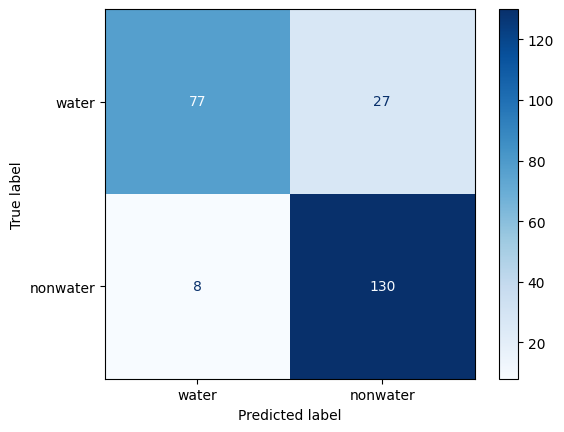

In [ ]:
#hf_bare = accuracy_reporter(hf_swlc_allpoints, 'reference_water', 'hydrafloods_water', 'hydrafloods bare all points', filter_bool=True, filter_prop='land_cover', filter_value=7)
hf_bare_allconf = confusion_matrix_reporter(hf_swlc_allpoints, 'hydrafloods_water', 'HYDRAFloods bare', filter_prop = 'land_cover', filter_value = 7)

### HYDROSAR Analysis by Land Cover, All Confidences

path1
HYDROSAR Cropland accuracy: 0.942
HYDROSAR Cropland f1 score: 0.750
HYDROSAR Cropland Precision (aka user's accuracy for water): 1.000
HYDROSAR Cropland Recall (aka producer's accuracy for water): 0.600
HYDROSAR Cropland Specificity (aka producer's accuracy for nonwater): 1.000
HYDROSAR Cropland Normalized Matthew's Correlation Coefficien: 0.875


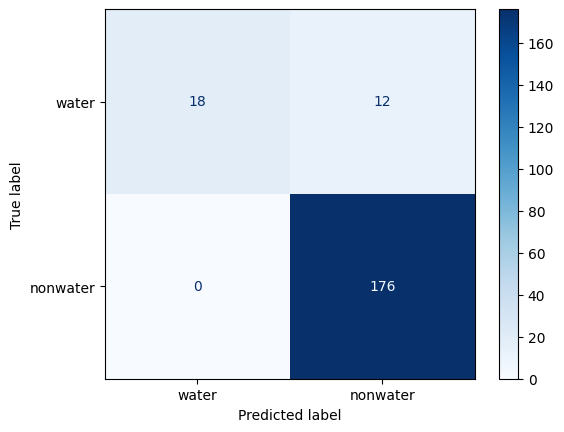

In [ ]:
#hs_cropland_allpoints = accuracy_reporter(hs_swlc_all_points, 'reference_water', 'hydrosar_water', 'hydrosar cropland all points',
#                                filter_bool=True, filter_prop='land_cover', filter_value = 4)

hs_cropland_allconf = confusion_matrix_reporter(hs_swlc_allpoints, 'hydrosar_water',
                                                  'HYDROSAR Cropland',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
HYDROSAR Built All Points accuracy: 1.000
HYDROSAR Built All Points f1 score: 0.000
HYDROSAR Built All Points Precision (aka user's accuracy for water): 0.000
HYDROSAR Built All Points Recall (aka producer's accuracy for water): 0.000
HYDROSAR Built All Points Specificity (aka producer's accuracy for nonwater): 1.000
HYDROSAR Built All Points Normalized Matthew's Correlation Coefficien: 0.500


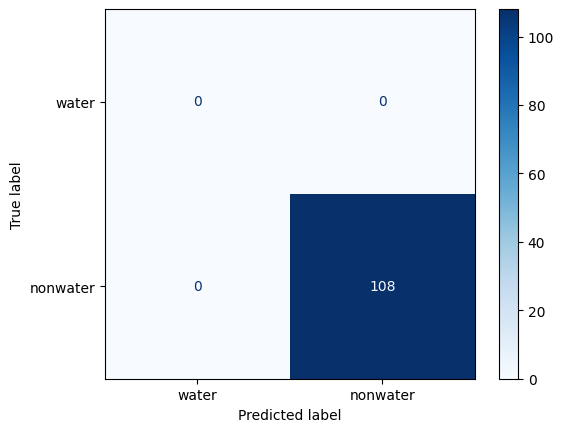

In [ ]:
#hs_built_allpoints = accuracy_reporter(hs_swlc_all_points, 'reference_water', 'hydrosar_water', 'hydrosar built all points',
#                             filter_bool=True, filter_prop='land_cover', filter_value = 6)

hs_built_allconf = confusion_matrix_reporter(hs_swlc_allpoints, 'hydrosar_water', 'HYDROSAR Built All Points',
                                               filter_prop = 'land_cover', filter_value = 6)

path1
HYDROSAR Bare All Confidences accuracy: 0.781
HYDROSAR Bare All Confidences f1 score: 0.675
HYDROSAR Bare All Confidences Precision (aka user's accuracy for water): 0.932
HYDROSAR Bare All Confidences Recall (aka producer's accuracy for water): 0.529
HYDROSAR Bare All Confidences Specificity (aka producer's accuracy for nonwater): 0.971
HYDROSAR Bare All Confidences Normalized Matthew's Correlation Coefficien: 0.788


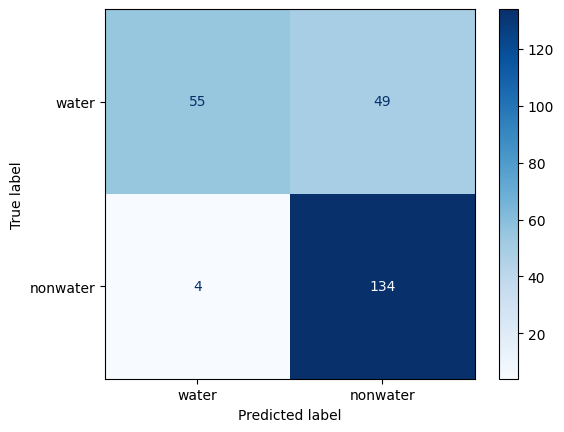

In [ ]:
#hs_bare_allpoints = accuracy_reporter(hs_swlc_all_points, 'reference_water', 'hydrosar_water', 'hydrosar bare all points',
#                            filter_bool=True, filter_prop='land_cover', filter_value=7)
hs_bare_allconf = confusion_matrix_reporter(hs_swlc_allpoints, 'hydrosar_water', 'HYDROSAR Bare All Confidences',
                                               filter_prop = 'land_cover', filter_value = 7)

### GFM Analysis by Land Cover, All Confidences

path1
GFM Cropland All Confidences accuracy: 0.966
GFM Cropland All Confidences f1 score: 0.873
GFM Cropland All Confidences Precision (aka user's accuracy for water): 0.960
GFM Cropland All Confidences Recall (aka producer's accuracy for water): 0.800
GFM Cropland All Confidences Specificity (aka producer's accuracy for nonwater): 0.994
GFM Cropland All Confidences Normalized Matthew's Correlation Coefficien: 0.929


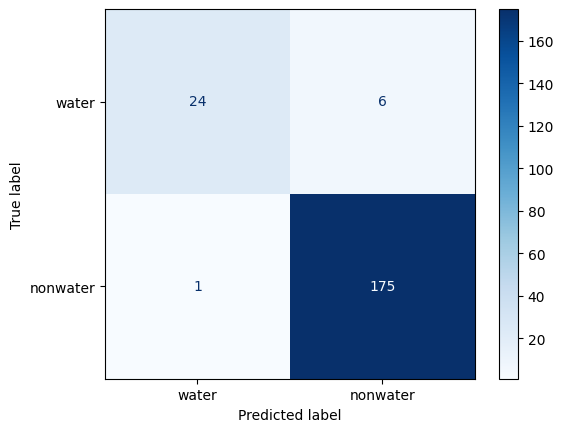

In [ ]:
#gfm_cropland = accuracy_reporter(gfm_swlc_all_points, 'reference_water', 'gfm_water', 'GFM Cropland All points',
#                                 filter_bool=True, filter_prop='land_cover', filter_value = 4)

gfm_cropland_allconf = confusion_matrix_reporter(gfm_swlc_allpoints, 'gfm_water',
                                                  'GFM Cropland All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
GFM Built All Confidences accuracy: 1.000
GFM Built All Confidences f1 score: 0.000
GFM Built All Confidences Precision (aka user's accuracy for water): 0.000
GFM Built All Confidences Recall (aka producer's accuracy for water): 0.000
GFM Built All Confidences Specificity (aka producer's accuracy for nonwater): 1.000
GFM Built All Confidences Normalized Matthew's Correlation Coefficien: 0.500


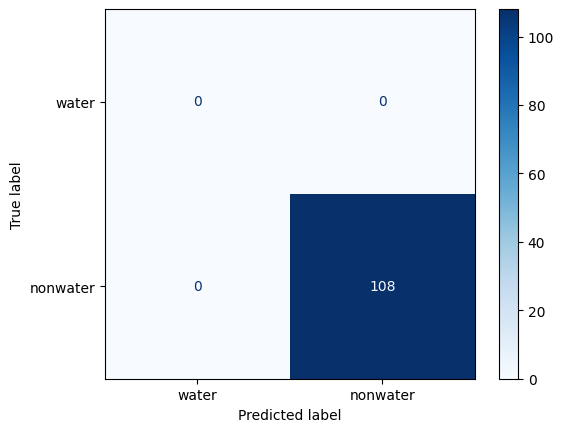

In [ ]:
#gfm_built_allpoints = accuracy_reporter(gfm_swlc_all_points, 'reference_water', 'gfm_water', 'GFM Built',
#                              filter_bool=True, filter_prop='land_cover', filter_value = 6)

gfm_built_allconf = confusion_matrix_reporter(gfm_swlc_allpoints, 'gfm_water',
                                                  'GFM Built All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
GFM Bare All Confidences accuracy: 0.897
GFM Bare All Confidences f1 score: 0.876
GFM Bare All Confidences Precision (aka user's accuracy for water): 0.907
GFM Bare All Confidences Recall (aka producer's accuracy for water): 0.846
GFM Bare All Confidences Specificity (aka producer's accuracy for nonwater): 0.935
GFM Bare All Confidences Normalized Matthew's Correlation Coefficien: 0.894


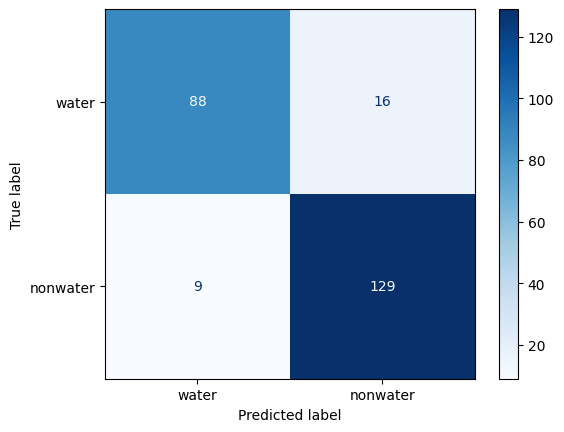

In [ ]:
#gfm_bare_allpoints = accuracy_reporter(gfm_swlc_all_points, 'reference_water', 'gfm_water', 'GFM Bare',
#                              filter_bool=True, filter_prop='land_cover', filter_value = 7)

gfm_bare_allconf = confusion_matrix_reporter(gfm_swlc_allpoints, 'gfm_water',
                                                  'GFM Bare All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 7)

### DSWx-HLS Analysis by Land Cover, All Confidences

path1
DSWx-HLS Cropland All Confidences accuracy: 0.937
DSWx-HLS Cropland All Confidences f1 score: 0.723
DSWx-HLS Cropland All Confidences Precision (aka user's accuracy for water): 1.000
DSWx-HLS Cropland All Confidences Recall (aka producer's accuracy for water): 0.567
DSWx-HLS Cropland All Confidences Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-HLS Cropland All Confidences Normalized Matthew's Correlation Coefficien: 0.863


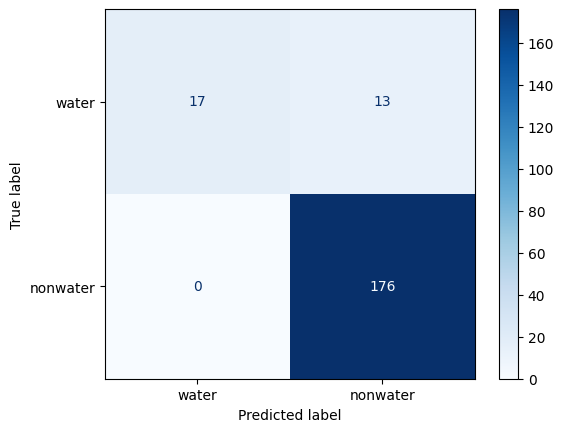

In [ ]:
#dswxhls_cropland = accuracy_reporter(dswxhls_swlc_all_points, 'reference_water', 'dswxhls_water', 'DSWx-HLS Cropland All confidences',
#                                     filter_bool=True, filter_prop='land_cover', filter_value = 4)

dswxhls_cropland_allconf = confusion_matrix_reporter(dswxhls_swlc_allpoints, 'dswxhls_water',
                                                  'DSWx-HLS Cropland All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
DSWx-HLS Built All Confidences accuracy: 1.000
DSWx-HLS Built All Confidences f1 score: 0.000
DSWx-HLS Built All Confidences Precision (aka user's accuracy for water): 0.000
DSWx-HLS Built All Confidences Recall (aka producer's accuracy for water): 0.000
DSWx-HLS Built All Confidences Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-HLS Built All Confidences Normalized Matthew's Correlation Coefficien: 0.500


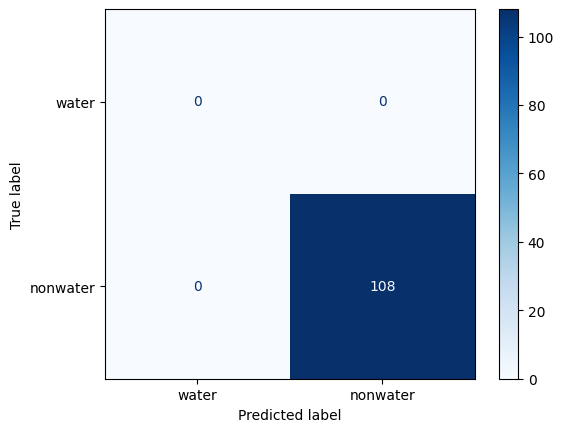

In [ ]:
#dswxhls_built = accuracy_reporter(dswxhls_swlc_all_points, 'reference_water', 'dswxhls_water', 'DSWx-HLS Built All confidence',
#                                  filter_bool=True, filter_prop='land_cover', filter_value = 6)

dswxhls_built_allconf = confusion_matrix_reporter(dswxhls_swlc_allpoints, 'dswxhls_water',
                                                  'DSWx-HLS Built All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 6)

In [ ]:
#dswxhls_bare_allpoints = accuracy_reporter(dswxhls_swlc_all_points, 'reference_water', 'dswxhls_water', 'DSWx-HLS Bare All confidence',
#                              filter_bool=True, filter_prop='land_cover', filter_value = 7)

path1
DSWx-HLS Bare All Confidences accuracy: 0.607
DSWx-HLS Bare All Confidences f1 score: 0.159
DSWx-HLS Bare All Confidences Precision (aka user's accuracy for water): 1.000
DSWx-HLS Bare All Confidences Recall (aka producer's accuracy for water): 0.087
DSWx-HLS Bare All Confidences Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-HLS Bare All Confidences Normalized Matthew's Correlation Coefficien: 0.613


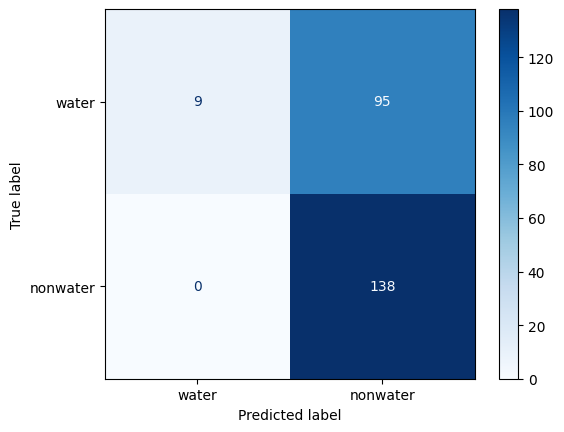

In [ ]:
dswxhls_bare_allconf = confusion_matrix_reporter(dswxhls_swlc_allpoints, 'dswxhls_water',
                                                  'DSWx-HLS Bare All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 7)

### DSWx-S1 Analysis by Land Cover, All Confidences

path1
DSWx-S1 Cropland All Confidences accuracy: 0.874
DSWx-S1 Cropland All Confidences f1 score: 0.278
DSWx-S1 Cropland All Confidences Precision (aka user's accuracy for water): 0.833
DSWx-S1 Cropland All Confidences Recall (aka producer's accuracy for water): 0.167
DSWx-S1 Cropland All Confidences Specificity (aka producer's accuracy for nonwater): 0.994
DSWx-S1 Cropland All Confidences Normalized Matthew's Correlation Coefficien: 0.669


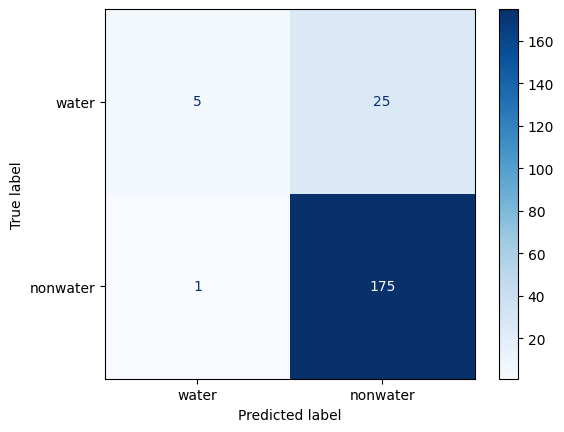

In [ ]:
#dswxs1_cropland = accuracy_reporter(dswxs1_swlc_all_points, 'reference_water', 'dswxs1_water', 'DSWx-S1 Cropland All confidences',
#                                     filter_bool=True, filter_prop='land_cover', filter_value = 4)

dswxs1_cropland_allconf = confusion_matrix_reporter(dswxs1_swlc_allpoints, 'dswxs1_water',
                                                  'DSWx-S1 Cropland All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 4)

In [ ]:
#dswxs1_built = accuracy_reporter(dswxs1_swlc_all_points, 'reference_water', 'dswxhls_water', 'DSWx-S1 Built All confidence',
#                                  filter_bool=True, filter_prop='land_cover', filter_value = 6)

path1
DSWx-S1 Built All Confidences accuracy: 1.000
DSWx-S1 Built All Confidences f1 score: 0.000
DSWx-S1 Built All Confidences Precision (aka user's accuracy for water): 0.000
DSWx-S1 Built All Confidences Recall (aka producer's accuracy for water): 0.000
DSWx-S1 Built All Confidences Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-S1 Built All Confidences Normalized Matthew's Correlation Coefficien: 0.500


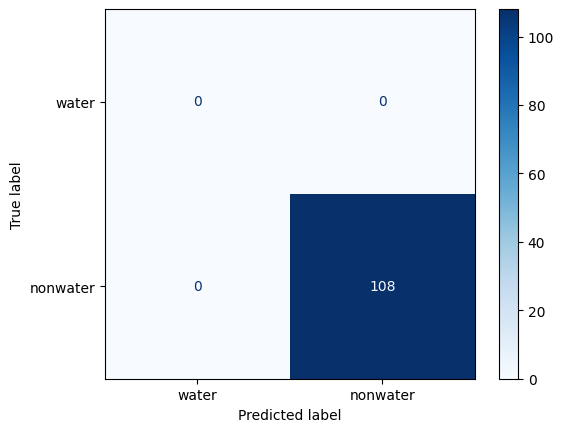

In [ ]:
dswxs1_built_allconf = confusion_matrix_reporter(dswxs1_swlc_allpoints, 'dswxs1_water',
                                                  'DSWx-S1 Built All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 6)

In [ ]:
#dswxs1_bare_allpoints = accuracy_reporter(dswxs1_swlc_all_points, 'reference_water', 'dswxs1_water', 'DSWx-S1 Bare All confidence',
#                              filter_bool=True, filter_prop='land_cover', filter_value = 7)

path1
DSWx-S1 Bare All Confidences accuracy: 0.574
DSWx-S1 Bare All Confidences f1 score: 0.019
DSWx-S1 Bare All Confidences Precision (aka user's accuracy for water): 1.000
DSWx-S1 Bare All Confidences Recall (aka producer's accuracy for water): 0.010
DSWx-S1 Bare All Confidences Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-S1 Bare All Confidences Normalized Matthew's Correlation Coefficien: 0.537


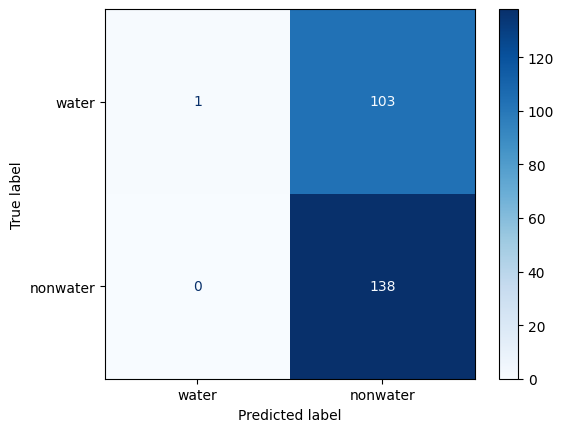

In [ ]:
dswxs1_bare_allconf = confusion_matrix_reporter(dswxs1_swlc_allpoints, 'dswxs1_water',
                                                  'DSWx-S1 Bare All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 7)

### MCDWD Analysis by Land Cover, All Confidences

In [ ]:
#mcdwd_cropland_all_points = accuracy_reporter(mcdwd_swlc_all_points, 'reference_water', 'mcdwd_water', 'MCDWD Cropland All points',
#                                   filter_bool=True, filter_prop='land_cover', filter_value = 4)

#mcdwd_built_all_points = accuracy_reporter(mcdwd_swlc_all_points, 'reference_water', 'mcdwd_water', 'MCDWD Built All points',
#                                           filter_bool=True, filter_prop='land_cover', filter_value = 6)

#mcdwd_bare_allpoints = accuracy_reporter(mcdwd_swlc_all_points, 'reference_water', 'mcdwd_water', 'MCDWD Bare',
#                              filter_bool=True, filter_prop='land_cover', filter_value = 7)

path1
MCDWD Cropland All Confidences accuracy: 0.903
MCDWD Cropland All Confidences f1 score: 0.524
MCDWD Cropland All Confidences Precision (aka user's accuracy for water): 0.917
MCDWD Cropland All Confidences Recall (aka producer's accuracy for water): 0.367
MCDWD Cropland All Confidences Specificity (aka producer's accuracy for nonwater): 0.994
MCDWD Cropland All Confidences Normalized Matthew's Correlation Coefficien: 0.772


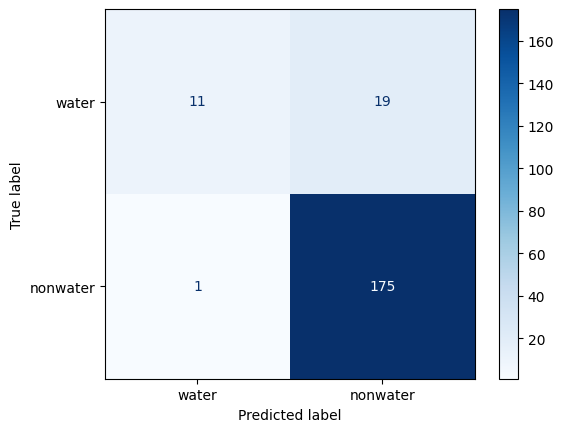

In [ ]:
mcdwd_cropland_allconf = confusion_matrix_reporter(mcdwd_swlc_allpoints, 'mcdwd_water',
                                                  'MCDWD Cropland All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
MCDWD Built All Confidences accuracy: 1.000
MCDWD Built All Confidences f1 score: 0.000
MCDWD Built All Confidences Precision (aka user's accuracy for water): 0.000
MCDWD Built All Confidences Recall (aka producer's accuracy for water): 0.000
MCDWD Built All Confidences Specificity (aka producer's accuracy for nonwater): 1.000
MCDWD Built All Confidences Normalized Matthew's Correlation Coefficien: 0.500


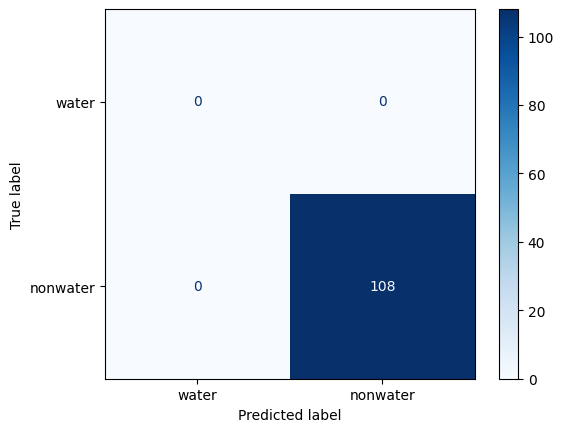

In [ ]:
mcdwd_built_allconf = confusion_matrix_reporter(mcdwd_swlc_allpoints, 'mcdwd_water',
                                                  'MCDWD Built All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
MCDWD Bare Ground All Confidences accuracy: 0.620
MCDWD Bare Ground All Confidences f1 score: 0.246
MCDWD Bare Ground All Confidences Precision (aka user's accuracy for water): 0.833
MCDWD Bare Ground All Confidences Recall (aka producer's accuracy for water): 0.144
MCDWD Bare Ground All Confidences Specificity (aka producer's accuracy for nonwater): 0.978
MCDWD Bare Ground All Confidences Normalized Matthew's Correlation Coefficien: 0.616


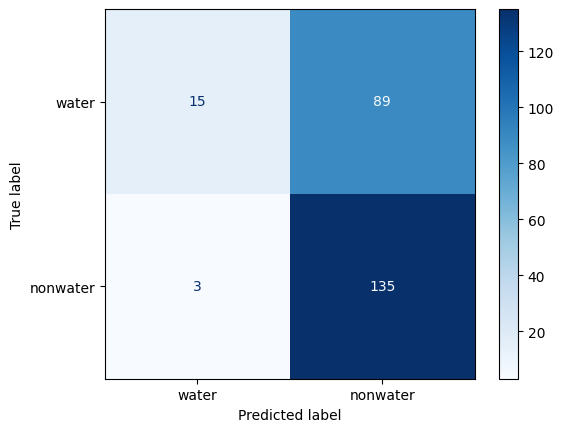

In [ ]:
mcdwd_bare_allconf = confusion_matrix_reporter(mcdwd_swlc_allpoints, 'mcdwd_water',
                                                  'MCDWD Bare Ground All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 7)

### VFM Analysis by Land Cover, All Confidences

In [ ]:
'''
vfm_cropland_allpoints = accuracy_reporter(vfm_swlc_all_points, 'reference_water', 'vfm_water', 'VFM Cropland All points',
                                           filter_bool=True, filter_prop='land_cover', filter_value = 4)
vfm_built_allpoints = accuracy_reporter(vfm_swlc_all_points, 'reference_water', 'vfm_water', 'VFM Built all points',
                                        filter_bool=True, filter_prop='land_cover', filter_value = 6)
vfm_bare_allpoints = accuracy_reporter(vfm_swlc_all_points, 'reference_water', 'vfm_water', 'VFM Bare All confidence',
                              filter_bool=True, filter_prop='land_cover', filter_value = 7)
'''

path1
VFM Cropland All Confidences accuracy: 0.964
VFM Cropland All Confidences f1 score: 0.877
VFM Cropland All Confidences Precision (aka user's accuracy for water): 0.862
VFM Cropland All Confidences Recall (aka producer's accuracy for water): 0.893
VFM Cropland All Confidences Specificity (aka producer's accuracy for nonwater): 0.976
VFM Cropland All Confidences Normalized Matthew's Correlation Coefficien: 0.928


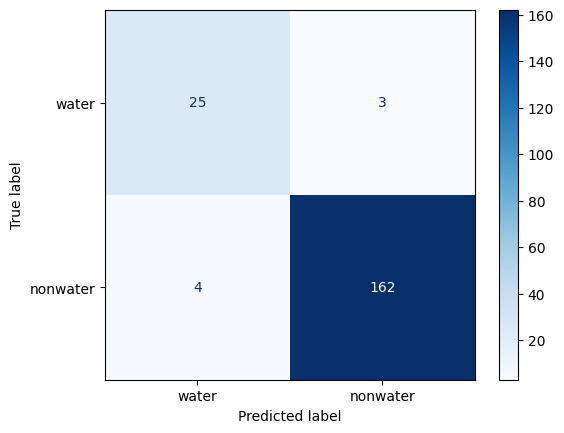

In [ ]:
vfm_cropland_allconf = confusion_matrix_reporter(vfm_swlc_allpoints, 'vfm_water',
                                                  'VFM Cropland All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
VFM Built-Up All Confidences accuracy: 1.000
VFM Built-Up All Confidences f1 score: 0.000
VFM Built-Up All Confidences Precision (aka user's accuracy for water): 0.000
VFM Built-Up All Confidences Recall (aka producer's accuracy for water): 0.000
VFM Built-Up All Confidences Specificity (aka producer's accuracy for nonwater): 1.000
VFM Built-Up All Confidences Normalized Matthew's Correlation Coefficien: 0.500


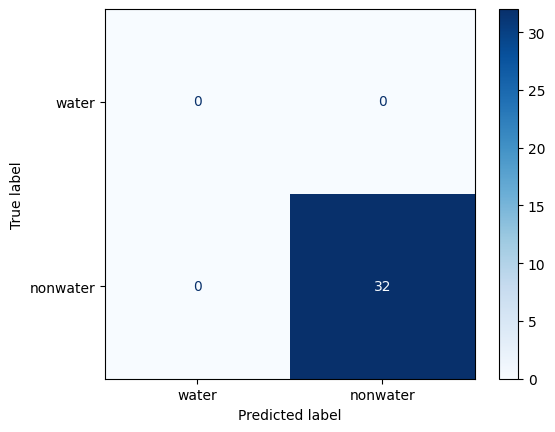

In [ ]:
vfm_built_allconf = confusion_matrix_reporter(vfm_swlc_allpoints, 'vfm_water',
                                                  'VFM Built-Up All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
VFM Bare Ground All Confidences accuracy: 0.712
VFM Bare Ground All Confidences f1 score: 0.631
VFM Bare Ground All Confidences Precision (aka user's accuracy for water): 0.736
VFM Bare Ground All Confidences Recall (aka producer's accuracy for water): 0.552
VFM Bare Ground All Confidences Specificity (aka producer's accuracy for nonwater): 0.840
VFM Bare Ground All Confidences Normalized Matthew's Correlation Coefficien: 0.707


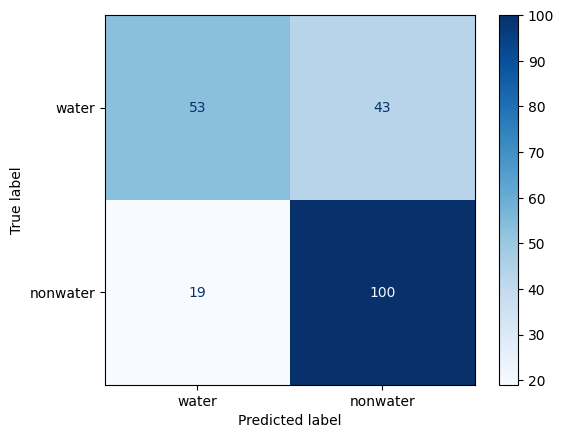

In [ ]:
vfm_bare_allconf = confusion_matrix_reporter(vfm_swlc_allpoints, 'vfm_water',
                                                  'VFM Bare Ground All Confidences',
                                                  filter_prop = 'land_cover', filter_value = 7)

## Step 4 Part 4.2: Land Cover with High Confidence Points

In [ ]:
# HYDRAFloods sampled with Slope, High Confidence
hf_swlc_highconf = dw_renamed.sampleRegions(hf_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# Hydrosar sampled with Land Cover, High Confidence
hs_swlc_highconf = dw_renamed.sampleRegions(hs_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# GFM sampled with land cover, High Confidence
gfm_swlc_highconf = dw_renamed.sampleRegions(gfm_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# DSWx-HLS Sampled with Land Cover, High Confidence
dswxhls_swlc_highconf = dw_renamed.sampleRegions(dswxhls_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# DSWx-S1 sampled with land cover, High Confidence
dswxs1_swlc_highconf = dw_renamed.sampleRegions(dswxs1_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# VFM sampled with land cover, High Confidence
vfm_swlc_highconf = dw_renamed.sampleRegions(vfm_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

# MCDWD sampled with land cover, High Confidence
mcdwd_swlc_highconf = dw_renamed.sampleRegions(mcdwd_sampled_highconf, projection = my_proj_string,
                                            scale=my_scale, geometries = True)

### HYDRAFloods Analysis by Land Cover, High Confidence Points Only

path1
HYDRAFloods Cropland High Confidence accuracy: 0.969
HYDRAFloods Cropland High Confidence f1 score: 0.786
HYDRAFloods Cropland High Confidence Precision (aka user's accuracy for water): 1.000
HYDRAFloods Cropland High Confidence Recall (aka producer's accuracy for water): 0.647
HYDRAFloods Cropland High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
HYDRAFloods Cropland High Confidence Normalized Matthew's Correlation Coefficien: 0.895


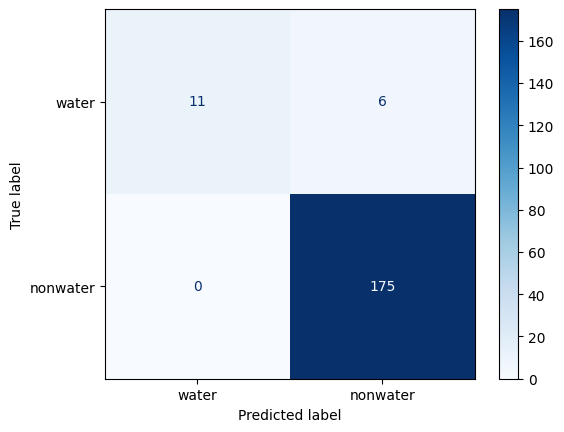

In [ ]:
hf_cropland_highconf = confusion_matrix_reporter(hf_swlc_highconf, 'hydrafloods_water',
                                                  'HYDRAFloods Cropland High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
HYDRAFloods Built High Confidence accuracy: 1.000
HYDRAFloods Built High Confidence f1 score: 0.000
HYDRAFloods Built High Confidence Precision (aka user's accuracy for water): 0.000
HYDRAFloods Built High Confidence Recall (aka producer's accuracy for water): 0.000
HYDRAFloods Built High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
HYDRAFloods Built High Confidence Normalized Matthew's Correlation Coefficien: 0.500


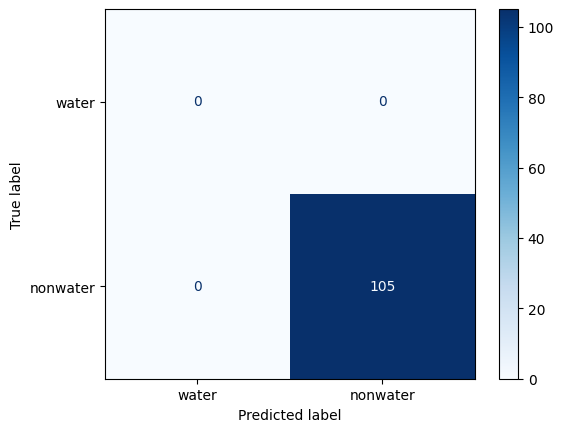

In [ ]:
hf_built_highconf = confusion_matrix_reporter(hf_swlc_highconf, 'hydrafloods_water',
                                                  'HYDRAFloods Built High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
HYDRAFloods Bare High Confidence accuracy: 0.902
HYDRAFloods Bare High Confidence f1 score: 0.857
HYDRAFloods Bare High Confidence Precision (aka user's accuracy for water): 0.915
HYDRAFloods Bare High Confidence Recall (aka producer's accuracy for water): 0.806
HYDRAFloods Bare High Confidence Specificity (aka producer's accuracy for nonwater): 0.957
HYDRAFloods Bare High Confidence Normalized Matthew's Correlation Coefficien: 0.893


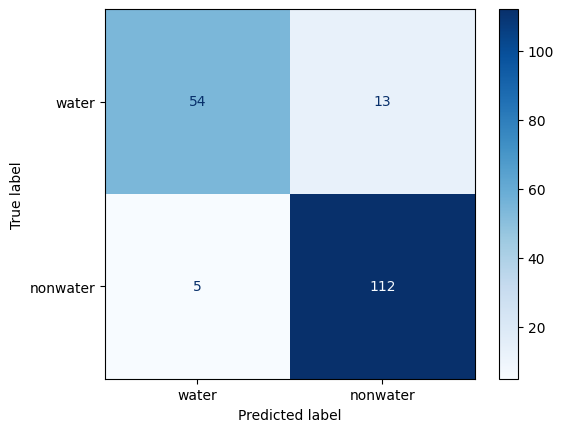

In [ ]:
hf_bare_highconf = confusion_matrix_reporter(hf_swlc_highconf, 'hydrafloods_water',
                                                  'HYDRAFloods Bare High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 7)

### HYDROSAR Analysis by Land Cover, High Confidence Points Only

path1
HYDROSAR Cropland High Confidence accuracy: 0.974
HYDROSAR Cropland High Confidence f1 score: 0.828
HYDROSAR Cropland High Confidence Precision (aka user's accuracy for water): 1.000
HYDROSAR Cropland High Confidence Recall (aka producer's accuracy for water): 0.706
HYDROSAR Cropland High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
HYDROSAR Cropland High Confidence Normalized Matthew's Correlation Coefficien: 0.914


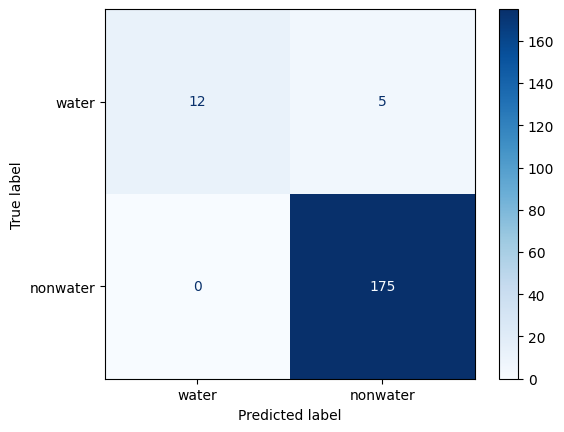

In [ ]:
hs_cropland_highconf = confusion_matrix_reporter(hs_swlc_highconf, 'hydrosar_water',
                                                  'HYDROSAR Cropland High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
HYDROSAR Built-Up High Confidence accuracy: 1.000
HYDROSAR Built-Up High Confidence f1 score: 0.000
HYDROSAR Built-Up High Confidence Precision (aka user's accuracy for water): 0.000
HYDROSAR Built-Up High Confidence Recall (aka producer's accuracy for water): 0.000
HYDROSAR Built-Up High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
HYDROSAR Built-Up High Confidence Normalized Matthew's Correlation Coefficien: 0.500


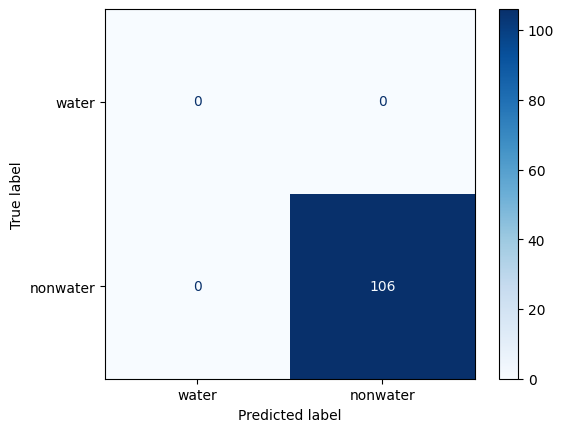

In [ ]:
hs_built_highconf = confusion_matrix_reporter(hs_swlc_highconf, 'hydrosar_water',
                                                  'HYDROSAR Built-Up High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
HYDROSAR Bare Ground High Confidence accuracy: 0.848
HYDROSAR Bare Ground High Confidence f1 score: 0.741
HYDROSAR Bare Ground High Confidence Precision (aka user's accuracy for water): 0.976
HYDROSAR Bare Ground High Confidence Recall (aka producer's accuracy for water): 0.597
HYDROSAR Bare Ground High Confidence Specificity (aka producer's accuracy for nonwater): 0.991
HYDROSAR Bare Ground High Confidence Normalized Matthew's Correlation Coefficien: 0.840


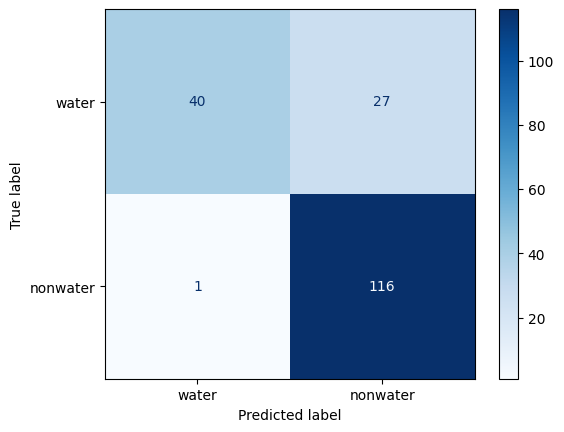

In [ ]:
hs_bare_highconf = confusion_matrix_reporter(hs_swlc_highconf, 'hydrosar_water',
                                                  'HYDROSAR Bare Ground High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 7)

### GFM Analysis by Land Cover, High Confidence Points Only

path1
GFM Cropland High Confidence accuracy: 0.979
GFM Cropland High Confidence f1 score: 0.867
GFM Cropland High Confidence Precision (aka user's accuracy for water): 1.000
GFM Cropland High Confidence Recall (aka producer's accuracy for water): 0.765
GFM Cropland High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
GFM Cropland High Confidence Normalized Matthew's Correlation Coefficien: 0.932


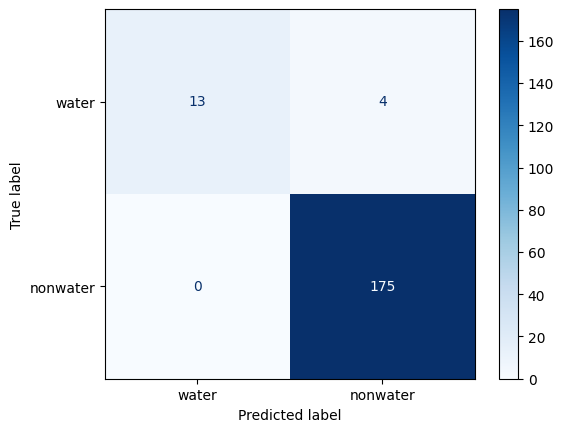

In [ ]:
gfm_cropland_highconf = confusion_matrix_reporter(gfm_swlc_highconf, 'gfm_water',
                                                  'GFM Cropland High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
GFM Built-Up High Confidence accuracy: 1.000
GFM Built-Up High Confidence f1 score: 0.000
GFM Built-Up High Confidence Precision (aka user's accuracy for water): 0.000
GFM Built-Up High Confidence Recall (aka producer's accuracy for water): 0.000
GFM Built-Up High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
GFM Built-Up High Confidence Normalized Matthew's Correlation Coefficien: 0.500


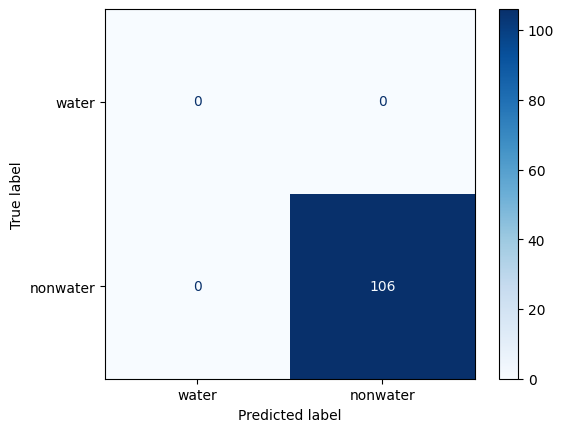

In [ ]:
gfm_built_highconf = confusion_matrix_reporter(gfm_swlc_highconf, 'gfm_water',
                                                  'GFM Built-Up High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
GFM Bare Ground High Confidence accuracy: 0.951
GFM Bare Ground High Confidence f1 score: 0.928
GFM Bare Ground High Confidence Precision (aka user's accuracy for water): 1.000
GFM Bare Ground High Confidence Recall (aka producer's accuracy for water): 0.866
GFM Bare Ground High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
GFM Bare Ground High Confidence Normalized Matthew's Correlation Coefficien: 0.948


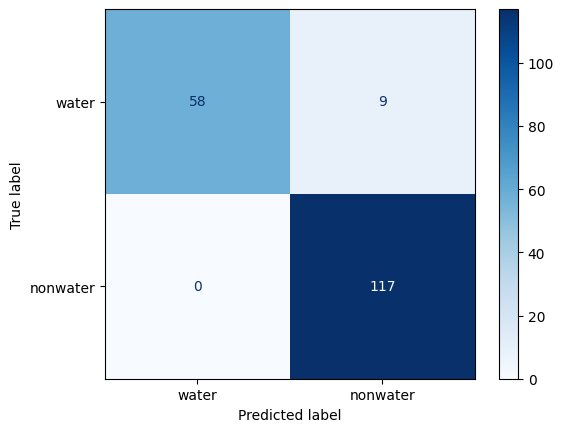

In [ ]:
gfm_bare_highconf = confusion_matrix_reporter(gfm_swlc_highconf, 'gfm_water',
                                                  'GFM Bare Ground High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 7)

### DSWx-HLS Analysis by Land Cover, High Confidence Points Only

path1
DSWx-HLS Cropland High Confidence accuracy: 0.958
DSWx-HLS Cropland High Confidence f1 score: 0.692
DSWx-HLS Cropland High Confidence Precision (aka user's accuracy for water): 1.000
DSWx-HLS Cropland High Confidence Recall (aka producer's accuracy for water): 0.529
DSWx-HLS Cropland High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-HLS Cropland High Confidence Normalized Matthew's Correlation Coefficien: 0.856


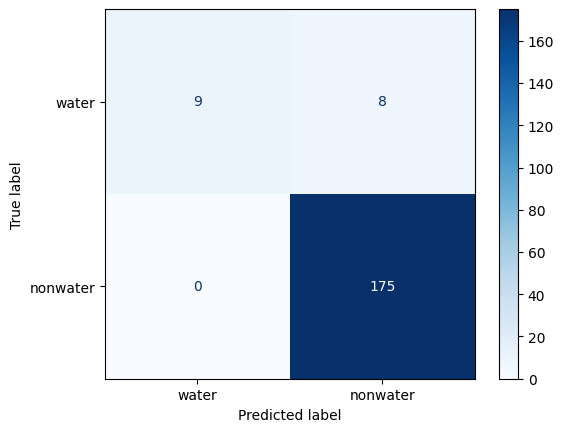

In [ ]:
dswxhls_cropland_highconf = confusion_matrix_reporter(dswxhls_swlc_highconf, 'dswxhls_water',
                                                  'DSWx-HLS Cropland High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
DSWx-HLS Built High Confidence accuracy: 1.000
DSWx-HLS Built High Confidence f1 score: 0.000
DSWx-HLS Built High Confidence Precision (aka user's accuracy for water): 0.000
DSWx-HLS Built High Confidence Recall (aka producer's accuracy for water): 0.000
DSWx-HLS Built High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-HLS Built High Confidence Normalized Matthew's Correlation Coefficien: 0.500


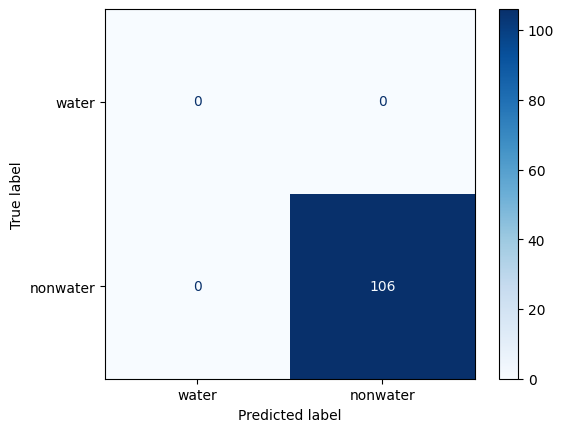

In [ ]:
dswxhls_built_highconf = confusion_matrix_reporter(dswxhls_swlc_highconf, 'dswxhls_water',
                                                  'DSWx-HLS Built High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
DSWx-HLS Bare Ground High Confidence accuracy: 0.679
DSWx-HLS Bare Ground High Confidence f1 score: 0.213
DSWx-HLS Bare Ground High Confidence Precision (aka user's accuracy for water): 1.000
DSWx-HLS Bare Ground High Confidence Recall (aka producer's accuracy for water): 0.119
DSWx-HLS Bare Ground High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-HLS Bare Ground High Confidence Normalized Matthew's Correlation Coefficien: 0.641


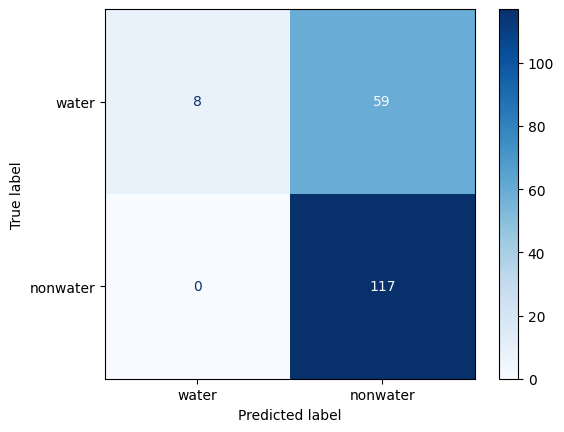

In [ ]:
dswxhls_bare_highconf = confusion_matrix_reporter(dswxhls_swlc_highconf, 'dswxhls_water',
                                                  'DSWx-HLS Bare Ground High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 7)

### DSWx-S1 Analysis by Land Cover, High Confidence Points Only

path1
DSWx-S1 Cropland High Confidence accuracy: 0.938
DSWx-S1 Cropland High Confidence f1 score: 0.455
DSWx-S1 Cropland High Confidence Precision (aka user's accuracy for water): 1.000
DSWx-S1 Cropland High Confidence Recall (aka producer's accuracy for water): 0.294
DSWx-S1 Cropland High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-S1 Cropland High Confidence Normalized Matthew's Correlation Coefficien: 0.762


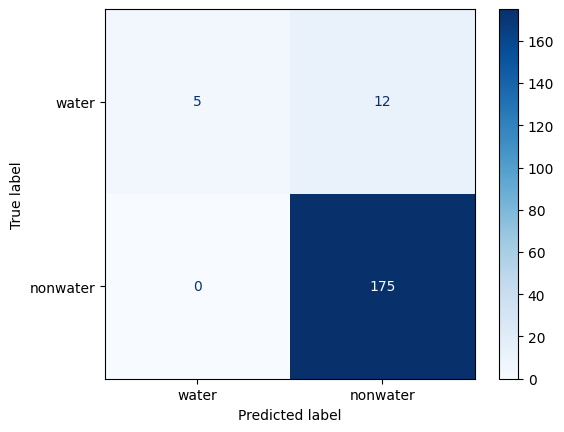

In [ ]:
dswxs1_cropland_highconf = confusion_matrix_reporter(dswxs1_swlc_highconf, 'dswxs1_water',
                                                  'DSWx-S1 Cropland High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
DSWx-S1 Built High Confidence accuracy: 1.000
DSWx-S1 Built High Confidence f1 score: 0.000
DSWx-S1 Built High Confidence Precision (aka user's accuracy for water): 0.000
DSWx-S1 Built High Confidence Recall (aka producer's accuracy for water): 0.000
DSWx-S1 Built High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-S1 Built High Confidence Normalized Matthew's Correlation Coefficien: 0.500


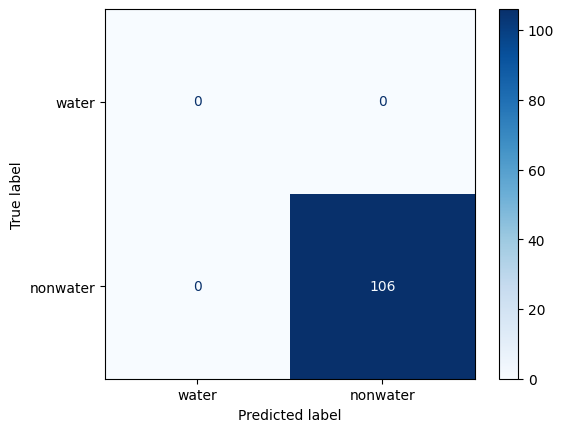

In [ ]:
dswxs1_built_highconf = confusion_matrix_reporter(dswxs1_swlc_highconf, 'dswxs1_water',
                                                  'DSWx-S1 Built High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
DSWx-S1 Bare Ground High Confidence accuracy: 0.641
DSWx-S1 Bare Ground High Confidence f1 score: 0.029
DSWx-S1 Bare Ground High Confidence Precision (aka user's accuracy for water): 1.000
DSWx-S1 Bare Ground High Confidence Recall (aka producer's accuracy for water): 0.015
DSWx-S1 Bare Ground High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
DSWx-S1 Bare Ground High Confidence Normalized Matthew's Correlation Coefficien: 0.549


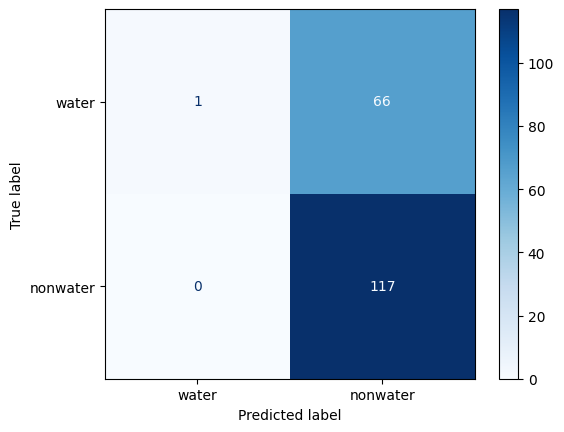

In [ ]:
dswxs1_bare_highconf = confusion_matrix_reporter(dswxs1_swlc_highconf, 'dswxs1_water',
                                                  'DSWx-S1 Bare Ground High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 7)

### MCDWD Analysis by Land Cover, High Confidence Points Only

path1
MCDWD Cropland High Confidence accuracy: 0.948
MCDWD Cropland High Confidence f1 score: 0.583
MCDWD Cropland High Confidence Precision (aka user's accuracy for water): 1.000
MCDWD Cropland High Confidence Recall (aka producer's accuracy for water): 0.412
MCDWD Cropland High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
MCDWD Cropland High Confidence Normalized Matthew's Correlation Coefficien: 0.812


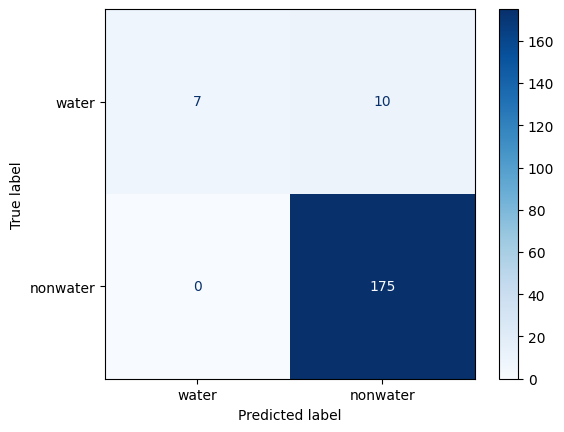

In [ ]:
mcdwd_cropland_highconf = confusion_matrix_reporter(mcdwd_swlc_highconf, 'mcdwd_water',
                                                  'MCDWD Cropland High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
MCDWD Built-Up High Confidence accuracy: 1.000
MCDWD Built-Up High Confidence f1 score: 0.000
MCDWD Built-Up High Confidence Precision (aka user's accuracy for water): 0.000
MCDWD Built-Up High Confidence Recall (aka producer's accuracy for water): 0.000
MCDWD Built-Up High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
MCDWD Built-Up High Confidence Normalized Matthew's Correlation Coefficien: 0.500


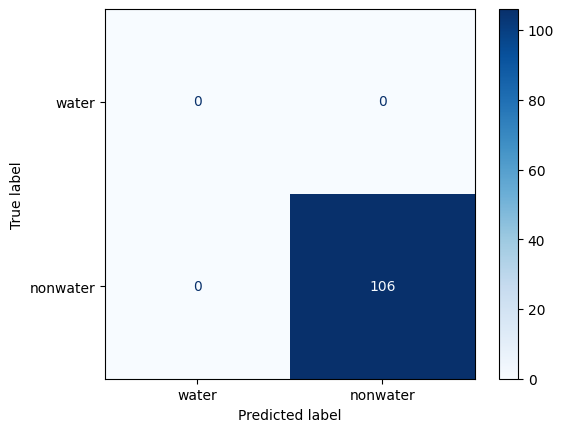

In [ ]:
mcdwd_built_highconf = confusion_matrix_reporter(mcdwd_swlc_highconf, 'mcdwd_water',
                                                  'MCDWD Built-Up High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
MCDWD Bare Ground High Confidence accuracy: 0.685
MCDWD Bare Ground High Confidence f1 score: 0.237
MCDWD Bare Ground High Confidence Precision (aka user's accuracy for water): 1.000
MCDWD Bare Ground High Confidence Recall (aka producer's accuracy for water): 0.134
MCDWD Bare Ground High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
MCDWD Bare Ground High Confidence Normalized Matthew's Correlation Coefficien: 0.650


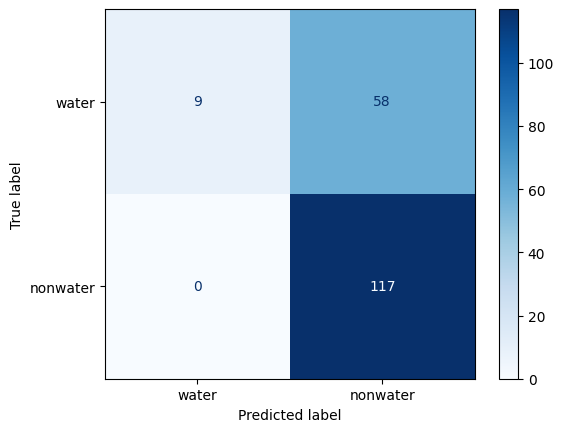

In [ ]:
mcdwd_bare_highconf = confusion_matrix_reporter(mcdwd_swlc_highconf, 'mcdwd_water',
                                                  'MCDWD Bare Ground High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 7)

### VFM Analysis by Land Cover, High Confidence Points Only

path1
VFM Cropland High Confidence accuracy: 0.968
VFM Cropland High Confidence f1 score: 0.870
VFM Cropland High Confidence Precision (aka user's accuracy for water): 0.833
VFM Cropland High Confidence Recall (aka producer's accuracy for water): 0.909
VFM Cropland High Confidence Specificity (aka producer's accuracy for nonwater): 0.976
VFM Cropland High Confidence Normalized Matthew's Correlation Coefficien: 0.926


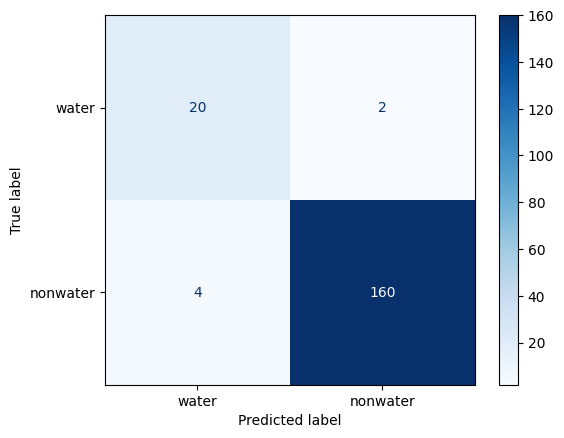

In [ ]:
vfm_cropland_highconf = confusion_matrix_reporter(vfm_swlc_highconf, 'vfm_water',
                                                  'VFM Cropland High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 4)

path1
VFM Built-Up High Confidence accuracy: 1.000
VFM Built-Up High Confidence f1 score: 0.000
VFM Built-Up High Confidence Precision (aka user's accuracy for water): 0.000
VFM Built-Up High Confidence Recall (aka producer's accuracy for water): 0.000
VFM Built-Up High Confidence Specificity (aka producer's accuracy for nonwater): 1.000
VFM Built-Up High Confidence Normalized Matthew's Correlation Coefficien: 0.500


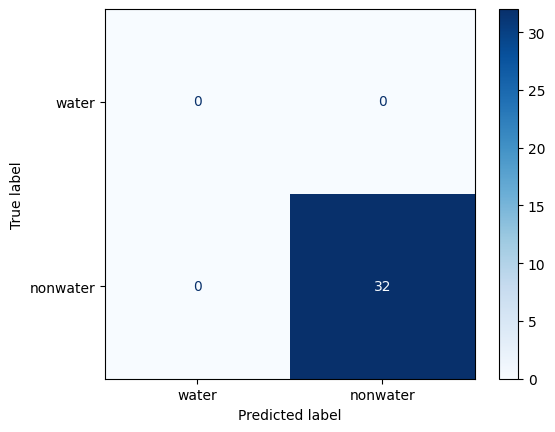

In [ ]:
vfm_built_highconf = confusion_matrix_reporter(vfm_swlc_highconf, 'vfm_water',
                                                  'VFM Built-Up High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 6)

path1
VFM Bare Ground High Confidence accuracy: 0.787
VFM Bare Ground High Confidence f1 score: 0.667
VFM Bare Ground High Confidence Precision (aka user's accuracy for water): 0.865
VFM Bare Ground High Confidence Recall (aka producer's accuracy for water): 0.542
VFM Bare Ground High Confidence Specificity (aka producer's accuracy for nonwater): 0.945
VFM Bare Ground High Confidence Normalized Matthew's Correlation Coefficien: 0.776


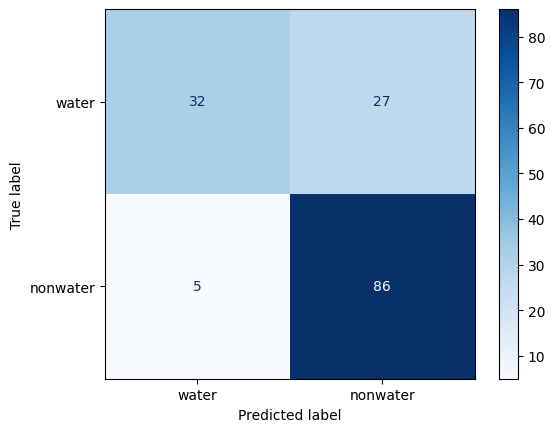

In [ ]:
vfm_bare_highconf = confusion_matrix_reporter(vfm_swlc_highconf, 'vfm_water',
                                                  'VFM Bare Ground High Confidence',
                                                  filter_prop = 'land_cover', filter_value = 7)

# Write everything to a CSV

In [ ]:
vfm_bare_highconf

In [ ]:
pwd

In [ ]:
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive/')

In [ ]:
os.chdir('drive/My Drive')#/Flood_Intercomparison/case_studies/confirmed_case_studies/chad_09_26')

In [ ]:
os.chdir('Flood_Intercomparison')

In [ ]:
os.chdir('Case_Studies/confirmed_case_studies/chad_09_26')

In [ ]:
import csv

In [ ]:
#filename = 'Statistics_chad_09_26_20250326.csv'
filename = 'Statistics_chad_09_26_20250326_updated.csv'

headers = ['Description', 'Sample_Size', 'Overall_Accuracy', 'Precision', 'Recall', 'Specificity', 'NPV', 'F1_score', 'Normalized_Matthews_Correlation_Coefficient']

with open(filename, 'w') as csvfile:
  csvwriter = csv.writer(csvfile)

  csvwriter.writerow(headers)

  # All Confidence Points
  csvwriter.writerow(hydrafloods_allconf)
  csvwriter.writerow(hydrosar_allconf)
  csvwriter.writerow(gfm_allconf)
  csvwriter.writerow(dswxhls_allconf)
  csvwriter.writerow(dswxs1_allconf)
  csvwriter.writerow(mcdwd_allconf)
  csvwriter.writerow(vfm_allconf)

  # High Confidence Points
  csvwriter.writerow(hydrafloods_highconf)
  csvwriter.writerow(hydrosar_highconf)
  csvwriter.writerow(gfm_highconf)
  csvwriter.writerow(dswxhls_highconf)
  csvwriter.writerow(dswxs1_highconf)
  csvwriter.writerow(mcdwd_highconf)
  csvwriter.writerow(vfm_highconf)

  # Slope -- All Confidence Points
  csvwriter.writerow(hf_lowslope_allconf)
  csvwriter.writerow(hs_lowslo_allconf)
  csvwriter.writerow(gfm_loslo_allconf)
  csvwriter.writerow(dswxhls_loslo_allconf)
  csvwriter.writerow(dswxs1_loslo_allconf)
  csvwriter.writerow(mcdwd_loslo_allconf)
  csvwriter.writerow(vfm_loslo_allconf)

  csvwriter.writerow(hf_modlowslope_allconf)
  csvwriter.writerow(hs_modlowslo_allconf)
  csvwriter.writerow(gfm_modloslo_allconf)
  csvwriter.writerow(dswxhls_modloslo_allconf)
  csvwriter.writerow(dswxs1_modloslo_allconf)
  csvwriter.writerow(mcdwd_modloslo_allconf)
  csvwriter.writerow(vfm_modloslo_allconf)


  csvwriter.writerow(hf_modhighslope_allconf)
  csvwriter.writerow(hs_modhighslo_allconf)
  csvwriter.writerow(gfm_modhislo_allconf)
  csvwriter.writerow(dswxhls_modhislo_allconf)
  csvwriter.writerow(dswxs1_modhislo_allconf)
  csvwriter.writerow(mcdwd_modhislo_allconf)
  csvwriter.writerow(vfm_modhislo_allconf)

  # Slope -- High Confidence Points
  csvwriter.writerow(hf_loslo_highconf)
  csvwriter.writerow(hs_lowslo_highconf)
  csvwriter.writerow(gfm_lowslo_highconf)
  csvwriter.writerow(dswxhls_lowslo_highconf)
  csvwriter.writerow(dswxs1_lowslo_highconf)
  csvwriter.writerow(mcdwd_lowslo_highconf)
  csvwriter.writerow(vfm_lowslo_highconf)

  csvwriter.writerow(hf_modlowslo_highconf)
  csvwriter.writerow(hs_modlowslo_highconf)
  csvwriter.writerow(gfm_modlowslo_highconf)
  csvwriter.writerow(dswxhls_modlowslo_highconf)
  csvwriter.writerow(dswxs1_modlowslo_highconf)
  csvwriter.writerow(mcdwd_modlowslo_highconf)
  csvwriter.writerow(vfm_modlowslo_highconf)

  csvwriter.writerow(hf_modhislo_highconf)
  csvwriter.writerow(hs_modhighslo_highconf)
  csvwriter.writerow(gfm_modhighslo_highconf)
  csvwriter.writerow(dswxhls_modhighslo_highconf)
  csvwriter.writerow(dswxs1_modhighslo_highconf)
  csvwriter.writerow(mcdwd_modhighslo_highconf)
  csvwriter.writerow(vfm_modhighslo_highconf)

  # Land Cover -- All Confidence Points
  csvwriter.writerow(hf_cropland_allconf)
  csvwriter.writerow(hs_cropland_allconf)
  csvwriter.writerow(gfm_cropland_allconf)
  csvwriter.writerow(dswxhls_cropland_allconf)
  csvwriter.writerow(dswxs1_cropland_allconf)
  csvwriter.writerow(mcdwd_cropland_allconf)
  csvwriter.writerow(vfm_cropland_allconf)

  csvwriter.writerow(hf_built_allconf)
  csvwriter.writerow(hs_built_allconf)
  csvwriter.writerow(gfm_built_allconf)
  csvwriter.writerow(dswxhls_built_allconf)
  csvwriter.writerow(dswxs1_built_allconf)
  csvwriter.writerow(mcdwd_built_allconf)
  csvwriter.writerow(vfm_built_allconf)

  csvwriter.writerow(hf_bare_allconf)
  csvwriter.writerow(hs_bare_allconf)
  csvwriter.writerow(gfm_bare_allconf)
  csvwriter.writerow(dswxhls_bare_allconf)
  csvwriter.writerow(dswxs1_bare_allconf)
  csvwriter.writerow(mcdwd_bare_allconf)
  csvwriter.writerow(vfm_bare_allconf)

  # Land cover -- High Confidence Points
  csvwriter.writerow(hf_cropland_highconf)
  csvwriter.writerow(hs_cropland_highconf)
  csvwriter.writerow(gfm_cropland_highconf)
  csvwriter.writerow(dswxhls_cropland_highconf)
  csvwriter.writerow(dswxs1_cropland_highconf)
  csvwriter.writerow(mcdwd_cropland_highconf)
  csvwriter.writerow(vfm_cropland_highconf)

  csvwriter.writerow(hf_built_highconf)
  csvwriter.writerow(hs_built_highconf)
  csvwriter.writerow(gfm_built_highconf)
  csvwriter.writerow(dswxhls_built_highconf)
  csvwriter.writerow(dswxs1_built_highconf)
  csvwriter.writerow(mcdwd_built_highconf)
  csvwriter.writerow(vfm_built_highconf)

  csvwriter.writerow(hf_bare_highconf)
  csvwriter.writerow(hs_bare_highconf)
  csvwriter.writerow(gfm_bare_highconf)
  csvwriter.writerow(dswxhls_bare_highconf)
  csvwriter.writerow(dswxs1_bare_highconf)
  csvwriter.writerow(mcdwd_bare_highconf)
  csvwriter.writerow(vfm_bare_highconf)

In [ ]:
ls T*